In [3]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

In [5]:
import os
import xarray as xr
import numpy as np

# Set path to your directory
data_dir = "/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/HRRR_Data"

# Loop through all files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith(".nc") and filename.startswith("profiler_sitesF.ncep_wfip3"):
        filepath = os.path.join(data_dir, filename)
     #   print(f"Processing {filename}...")

        # Open the dataset
        ds = xr.open_dataset(filepath)

        # Read site names from 'dsite'
        site_names = ds['dsite'].values
        site_names_str = np.array([
            name.decode('utf-8') if isinstance(name, bytes) else name 
            for name in site_names
        ])

        # print(site_names_str)

        # Find full name for BLOC
        bloc_index = np.where(site_names_str == 'WFIP-3 Block Island airport location')[0][0]

        # Extract just BLOC data using correct dimension name
        bloc_ds = ds.sel(sites=bloc_index)

        # Build output filename
        output_filename = filename.replace("profiler_sitesF", "BLOC_only")
        output_path = os.path.join(data_dir, output_filename)

        # Save BLOC data to new NetCDF
        bloc_ds.to_netcdf(output_path)

        ds.close()
       # print(f"Saved BLOC data to {output_filename}")

# print("✅ All files processed successfully.")


## Calculating Wind Veer and Shear

In [7]:
def wind_direction_difference(dir1, dir2): 
    """
    Calculate the difference in wind direction between two levels,
    accounting for the 0-360 degree wraparound.
    
    Parameters:
    dir1, dir2: Wind directions in degrees (0-360)
    
    Returns:
    Difference in degrees (between -180 and 180).
    """
    # Calculate the raw difference
    diff = dir2 - dir1
    
    # Use modulo arithmetic to handle wraparound
    diff = (diff + 180) % 360 - 180
    return diff

def calculate_wind_veer(file_paths, start_date=None, end_date=None):
    """
    Calculate wind veer and wind shear from netCDF files, using Azim for wind direction and qc_Azim for quality control.
    
    Parameters:
        file_paths (list): List of netCDF file paths.
        start_date (datetime): Optional start date as a datetime object.
        end_date (datetime): Optional end date as a datetime object.
    
    Returns:
        tuple: Times (datetime objects), wind veer values, and wind shear values.
    """
    all_times = []
    all_wind_veer = []

    print("Start Date: ", start_date)
    print("End Date: ", end_date)

    # Convert start_date and end_date to UTC (if need be)
    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        #print(file_path)
        
        # Load netCDF file using xarray
        ds = xr.open_dataset(file_path)
        
        # Extract data
        time_var = ds['time']
        height_var = ds['height'].values
        vhm = ds['Vhm'].values
        qc_vhm = ds['qc_Vhm'].values  # Quality control variable for wind speed
        azim = ds['Azim'].values  # Wind direction (vector-averaged) in degrees
        qc_azim = ds['qc_Azim'].values  # Quality control variable for wind direction
        
        times = pd.to_datetime(time_var.values, utc=True)  # Convert to datetime
        
        # Filter by date range if specified
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            times = times[valid_idx]
            vhm = vhm[valid_idx, :]
            qc_vhm = qc_vhm[valid_idx, :]
            azim = azim[valid_idx, :]
            qc_azim = qc_azim[valid_idx, :]

        # Ensure height indices for 40m and 140m are correct
        try:
            idx_40m = np.where(height_var == 40)[0][0]
            idx_140m = np.where(height_var == 140)[0][0]
        except IndexError:
            raise ValueError("Height levels 40m or 140m not found in the height variable.")
        
        # Calculate wind veer (difference in wind direction between 140m and 40m)
        wind_direction_40m = azim[:, idx_40m]  # Wind direction at 40m
        wind_direction_140m = azim[:, idx_140m]  # Wind direction at 140m

        
        # Calculate wind shear (difference in wind speed with height, normalized over vertical distance)
        height_diff = height_var[idx_140m] - height_var[idx_40m]  # Vertical distance between 40m and 140m
        wind_speed_40m = vhm[:, idx_40m]  # Wind speed at 40m
        wind_speed_140m = vhm[:, idx_140m]  # Wind speed at 140m        

        # Compute wind veer as the shortest rotational path between the two heights
        difference = wind_direction_difference(wind_direction_40m, wind_direction_140m)
        
        wind_veer =  difference / height_diff
        
        # Mask invalid values using qc_Vhm (wind speed) and qc_Azim (wind direction)
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0) & (qc_azim[:, idx_140m] == 0) & (qc_azim[:, idx_40m] == 0)
        times = times[valid_mask]
        wind_veer = wind_veer[valid_mask]

        # Append data to lists
        all_times.extend(times)
        all_wind_veer.extend(wind_veer)



    return all_times, all_wind_veer

In [8]:
import numpy as np
import pandas as pd
import xarray as xr

def wind_direction(u, v):
    """
    Compute wind direction from u and v components.
    """
    wd = (270 - np.degrees(np.arctan2(v, u))) % 360
    return wd

def wind_direction_difference(dir1, dir2): 
    """
    Calculate difference in wind direction, accounting for wraparound.
    """
    diff = dir2 - dir1
    diff = (diff + 180) % 360 - 180
    return diff

def calculate_wind_veer_HRRR(file_paths, start_date=None, end_date=None):
    """
    Calculate wind veer from HRRR BLOC extracted column files.
    
    Parameters:
        file_paths (list): List of HRRR NetCDF file paths.
        start_date (datetime): Optional start date.
        end_date (datetime): Optional end date.
    
    Returns:
        tuple: Times and wind veer values.
    """
    all_times = []
    all_wind_veer = []

    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        ds = xr.open_dataset(file_path)

        # Extract time info
        init_times = pd.to_datetime(ds['model_initialization'].values)
        forecast_hours = ds['forecast'].values

        # Build actual timestamps
        times = []
        for init_time, forecast_hour in zip(init_times, forecast_hours):
            valid_time = init_time + pd.to_timedelta(forecast_hour, unit="h")
            times.append(valid_time)
        times = pd.to_datetime(times)

        # Extract heights
        height_var = ds['height'].values  # shape (61,)

        # Extract wind components (u1, v1 = interpolated winds)
        u = ds['u1'].values  # shape (31, 61)
        v = ds['v1'].values

        # Compute wind direction (shape: 31, 61)
        azim = wind_direction(u, v)

        # Apply date filtering if specified
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            times = times[valid_idx]
            azim = azim[valid_idx, :]

        # Get indices for 40m and 140m
        try:
            idx_40m = np.where(height_var == 40)[0][0]
            idx_140m = np.where(height_var == 140)[0][0]
        except IndexError:
            raise ValueError("Height levels 40m or 140m not found.")

        # Compute veer at each time step
        wind_dir_40m = azim[:, idx_40m]
        wind_dir_140m = azim[:, idx_140m]
        wind_veer = wind_direction_difference(wind_dir_40m, wind_dir_140m) / (height_var[idx_140m] - height_var[idx_40m])

        # Accumulate
        all_times.extend(times)
        all_wind_veer.extend(wind_veer)

        ds.close()

    return np.array(all_times), np.array(all_wind_veer)


## Wind Shear using Power Law

In [10]:
import numpy as np
import pandas as pd
import xarray as xr

def calculate_power_law_exponent(v1, v2, z1, z2):
    if np.any(v1 <= 0) or np.any(v2 <= 0) or z1 <= 0 or z2 <= 0:
        raise ValueError("Wind speeds and heights must be positive numbers.")
    if z2 <= z1:
        raise ValueError("Height z2 must be greater than height z1.")
    return np.log(v2 / v1) / np.log(z2 / z1)

def calculate_wind_shear_with_alpha(file_paths, start_date=None, end_date=None):
    all_times = []
    all_alpha = []

    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        #print(f"Processing file: {file_path}")
        ds = xr.open_dataset(file_path)

        time_var = ds['time']
        height_var = ds['height'].values
        vhm = ds['Vhm'].values
        qc_vhm = ds['qc_Vhm'].values
        
        #print(f"Height variable: {height_var}")
        #print(f"Vhm shape: {vhm.shape}, QC shape: {qc_vhm.shape}")

        times = pd.to_datetime(time_var.values, utc=True)
        
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            #print(f"Valid time indices: {np.sum(valid_idx)}")
            times = times[valid_idx]
            vhm = vhm[valid_idx, :]
            qc_vhm = qc_vhm[valid_idx, :]
        
        idx_40m = np.where(height_var == 40)[0]
        idx_140m = np.where(height_var == 140)[0]
        
        if len(idx_40m) == 0 or len(idx_140m) == 0:
            print(f"Available heights: {height_var}")
            raise ValueError("Height levels 40m or 140m not found in the height variable.")
        
        idx_40m, idx_140m = idx_40m[0], idx_140m[0]
        #print(f"Indices for 40m: {idx_40m}, 140m: {idx_140m}")

        wind_speed_40m = vhm[:, idx_40m]
        wind_speed_140m = vhm[:, idx_140m]
        
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0)
        #print(f"Valid mask has {np.sum(valid_mask)} valid entries")
        
        times = times[valid_mask]
        wind_speed_40m = wind_speed_40m[valid_mask]
        wind_speed_140m = wind_speed_140m[valid_mask]

        if len(times) == 0:
            #print("on file: ", file_path)
            #print("No valid data points after filtering by QC.")
            continue
        
        try:
            alpha = calculate_power_law_exponent(wind_speed_40m, wind_speed_140m, 40, 140)
        except ValueError as e:
            print(f"Error in alpha calculation: {e}")
            continue

        #print(f"Calculated alpha values: {alpha[:5]} (showing first 5)")
        all_times.extend(times)
        all_alpha.extend(alpha)

    return all_times, all_alpha


In [11]:
import numpy as np
import pandas as pd
import xarray as xr

def calculate_power_law_exponent(v1, v2, z1, z2):
    """
    Standard power law shear calculation.
    """
    if np.any(v1 <= 0) or np.any(v2 <= 0) or z1 <= 0 or z2 <= 0:
        raise ValueError("Wind speeds and heights must be positive numbers.")
    if z2 <= z1:
        raise ValueError("Height z2 must be greater than height z1.")
    return np.log(v2 / v1) / np.log(z2 / z1)

def calculate_wind_shear_HRRR(file_paths, start_date=None, end_date=None):
    """
    Calculate wind shear from HRRR BLOC files.
    """
    all_times = []
    all_alpha = []

    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        ds = xr.open_dataset(file_path)

        # Extract time info
        init_times = pd.to_datetime(ds['model_initialization'].values)
        forecast_hours = ds['forecast'].values

        # Build actual timestamps
        times = []
        for init_time, forecast_hour in zip(init_times, forecast_hours):
            valid_time = init_time + pd.to_timedelta(forecast_hour, unit="h")
            times.append(valid_time)
        times = pd.to_datetime(times)

        # Extract heights
        height_var = ds['height'].values

        # Extract interpolated wind speed
        vhm = ds['wspd1'].values  # (31, 61)

        # Apply date filtering if specified
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            times = times[valid_idx]
            vhm = vhm[valid_idx, :]

        # Find 40m and 140m indices
        try:
            idx_40m = np.where(height_var == 40)[0][0]
            idx_140m = np.where(height_var == 140)[0][0]
        except IndexError:
            raise ValueError("Height levels 40m or 140m not found.")

        wind_speed_40m = vhm[:, idx_40m]
        wind_speed_140m = vhm[:, idx_140m]

        if len(times) == 0:
            continue

        try:
            alpha = calculate_power_law_exponent(wind_speed_40m, wind_speed_140m, 40, 140)
        except ValueError as e:
            print(f"Error in alpha calculation: {e}")
            continue

        all_times.extend(times)
        all_alpha.extend(alpha)

        ds.close()

    return np.array(all_times), np.array(all_alpha)


### Wind Veer Plotting 

In [13]:
def plot_wind_veer(times, wind_veer):
    """
    Plot wind veer over time.
    
    Parameters:
        times (list): List of datetime objects.
        wind_veer (list): List of wind veer values.
    """
    # Debugging: Check the data before plotting
    if len(times) == 0 or len(wind_veer) == 0:
        print("Error: No data to plot.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(times, wind_veer, label="Wind Veer (140m - 40m)", color='blue')
    plt.xlabel("Time")
    plt.ylabel("Wind Veer (m/s)")
    plt.title("Wind Veer Over Time")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

## File Collection

In [15]:
import os
from datetime import datetime

def filter_files_by_date(directory, start_date, end_date):
    """
    Filters file paths in a directory that match a date range and sorts them by date.

    Parameters:
        directory (str): Directory containing the files.
        start_date (str): Start date in 'YYYYMMDD' format.
        end_date (str): End date in 'YYYYMMDD' format.

    Returns:
        list: List of file paths within the date range, sorted by date.
    """
    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')

    filtered_files = []

    for file_name in os.listdir(directory):
        # CHANGEME below is for site A2
        if 'bloc.lidar.z03.c0.' in file_name and file_name.endswith('.sta.nc'):
        
        # CHANGEME below is for site A2
        #if 'sa2.lidar.z03.c0.' in file_name and file_name.endswith('.sta.nc'):
        
        # CHANGEME below is for site C1A
        #if 'sc1.lidar.z03.c0.'in file_name and file_name.endswith('.sta.nc'):
            try:
                # Extract the date part from the filename
                date_str = file_name.split('.')[4].strip()  # Strip any leading/trailing spaces
                
                # Convert to datetime object
                file_date = datetime.strptime(date_str, '%Y%m%d')
                
                # Check if the file date is within the range
                if start_date <= file_date <= end_date:
                    filtered_files.append((file_date, os.path.join(directory, file_name)))
                    
            except (IndexError, ValueError) as e:
                continue
    
    # Sort the files by the date (first element in the tuple)
    filtered_files.sort(key=lambda x: x[0])
    
    # Return the list of file paths sorted by date
    return [file_path for _, file_path in filtered_files]

# CHANGEME Usage for BLOC
directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_Data'
# CHANGEME Usage for Site A2
#directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteA2'
# CHANGEME Usage for Site C1a
#directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'

start_date = '20231201'  # Replace with any start date
end_date = '20250124'    # Replace with any end date

matching_files = filter_files_by_date(directory, start_date, end_date)
#print("Matching files:")
#for file_path in matching_files:
#    print(file_path)

In [16]:
import os
from datetime import datetime, timedelta

def convert_julian_to_date(year, julian_day):
    """
    Convert YYYY and DDD to a datetime object.
    """
    return datetime(year, 1, 1) + timedelta(days=julian_day - 1)

def filter_BLOC_files_by_date(directory, start_date, end_date):
    """
    Filters BLOC HRRR files by a given date range.
    
    Assumes filenames like: BLOC_only.ncep_wfip3.YYYYDDD.0000.nc
    """
    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')

    filtered_files = []

    for file_name in os.listdir(directory):
        if file_name.startswith('BLOC_only.ncep_wfip3.') and file_name.endswith('.nc'):
            try:
                # Extract date string: e.g. '2024223'
                date_part = file_name.split('.')[2]
                year = int(date_part[:4])
                julian_day = int(date_part[4:])

                file_date = convert_julian_to_date(year, julian_day)
                
                if start_date <= file_date <= end_date:
                    filtered_files.append((file_date, os.path.join(directory, file_name)))

            except (IndexError, ValueError) as e:
                continue

    # Sort by date
    filtered_files.sort(key=lambda x: x[0])
    
    return [file_path for _, file_path in filtered_files]

# ✅ Usage for BLOC
directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/HRRR_Data'
start_date = '20240101'
end_date = '20241231'

BLOC_HRRR_files = filter_BLOC_files_by_date(directory, start_date, end_date)

# If you want to print matching files:
#for file_path in BLOC_HRRR_files:
  #  print(file_path)


### Set Times Below - run each time choose new time frame

In [18]:

times_HRRR, HRRR_wind_veer = calculate_wind_veer_HRRR(BLOC_HRRR_files)
times_HRRR, HRRR_wind_shear = calculate_wind_shear_HRRR(BLOC_HRRR_files)

## Annual HRRRv4 BLOC (2024)

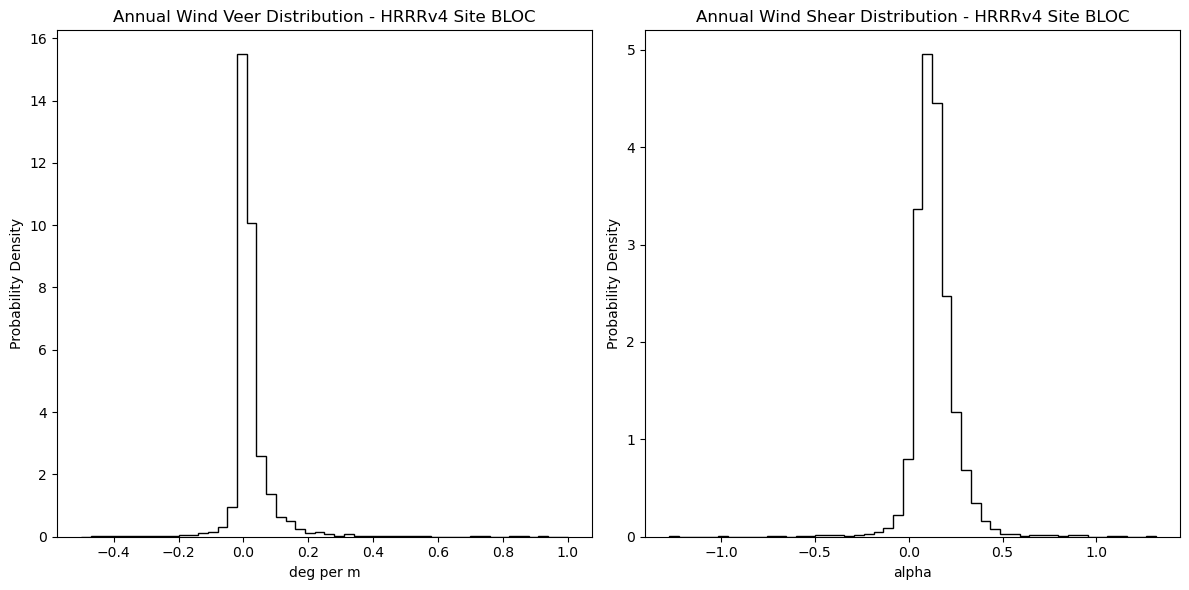

In [20]:

# Create the histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Wind Veer distribution on the first subplot
axs[0].hist(HRRR_wind_veer, bins=50, edgecolor='black', histtype='step',range=[-0.5,1.0], density=True)
axs[0].set_xlabel('deg per m')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Annual Wind Veer Distribution - HRRRv4 Site BLOC')

# Plot the Wind Shear distribution on the second subplot
axs[1].hist(HRRR_wind_shear, bins=50, edgecolor='black', histtype='step', density=True)
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Annual Wind Shear Distribution - HRRRv4 Site BLOC')

# Show the plot
plt.tight_layout()
plt.show()


## Annual BLOC

Start Date:  2024-01-01 00:00:00
End Date:  2024-12-31 00:00:00


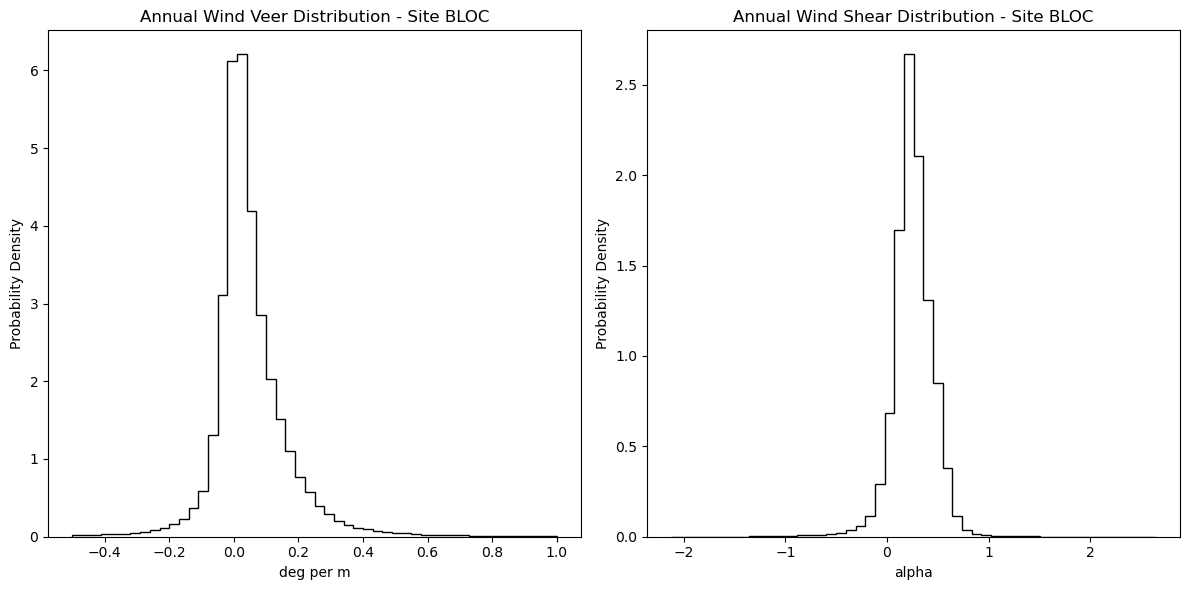

In [22]:
directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_Data'
start_date = '20240101'
end_date = '20241231'

matching_files = filter_files_by_date(directory, start_date, end_date)
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)
times_LiDAR, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times_LiDAR, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)


# Create the histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Wind Veer distribution on the first subplot
axs[0].hist(wind_veer, bins=50, edgecolor='black', histtype='step',range=[-0.5,1.0], density=True)
axs[0].set_xlabel('deg per m')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Annual Wind Veer Distribution - Site BLOC')

# Plot the Wind Shear distribution on the second subplot
axs[1].hist(wind_shear, bins=50, edgecolor='black', histtype='step', density=True)
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Annual Wind Shear Distribution - Site BLOC')

# Show the plot
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def localize_times(times):
    times = pd.to_datetime(times)
    if isinstance(times, pd.Series):
        if times.dt.tz is None:
            times = times.dt.tz_localize('UTC')
    else:  # in case times accidentally comes in as array of timestamps
        if times.tzinfo is None:
            times = times.tz_localize('UTC')
    return times

def getDailyAvgWindVeer(times, wind_veer, start_date, end_date):
    """
    Returns the daily average wind veer and corresponding times, averaged across all days at each time of day.
    The result is a DataFrame with time of day and the corresponding average wind veer.
    """
    # Check if the lengths of times and wind_veer match
    if not len(times) == len(wind_veer):
        raise ValueError("The lengths of 'times' and 'wind_veer' must be the same.")

    times = pd.to_datetime(times)

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
  
    df = pd.DataFrame({
        'time': times,
        'wind_veer': wind_veer
    })
    
    # Filtering between start and end date
    #df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
    
    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping data to calculate daily averages
    daily_avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)
    daily_std_veer = df.groupby('time_of_day')['wind_veer'].std().reindex(all_times, fill_value=np.nan)

    # Print the daily_avg_veer to check if values are being calculated correctly

    # Return a DataFrame containing the time of day and the corresponding daily average veer
    return pd.DataFrame({
        'time_of_day': daily_avg_veer.index,
        'average_wind_veer': daily_avg_veer.values,
        'std' : daily_std_veer.values
    })

# Plotting function to plot multiple dataframes
import matplotlib.cm as cm

def getDailyAvgWindShear(times, wind_shear, start_date, end_date):
    """
    Gets daily average wind shear averaged across all days at each time of day.
    The x-axis will represent the time of day (00:00 to 23:59, UTC), with error bars.
    """
    # Check if the lengths of times, and wind_shear match
    if not (len(times) == len(wind_shear)):
        raise ValueError("The lengths of 'times' and 'wind_shear' must be the same.")

    times = pd.to_datetime(times)

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    df = pd.DataFrame({
        'time': times,
        'wind_shear': wind_shear
    })

    # Filtering between start and end date
    #df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping data to calculate daily averages and standard deviations (for error bars)
    daily_avg_shear = df.groupby('time_of_day')['wind_shear'].median().reindex(all_times, fill_value=np.nan)
    daily_std_shear = df.groupby('time_of_day')['wind_shear'].std().reindex(all_times, fill_value=np.nan)


    return pd.DataFrame({
        'time_of_day': daily_avg_shear.index,
        'average_wind_shear': daily_avg_shear.values,
        'std': daily_std_shear.values
    })


def get_color_palette(num_dataframes):
    # Simple 3-color palette for small datasets (high contrast)
    simple_palette = ["#2ca02c","#1f77b4","#ff7f0e"]  # Green, Blue, Orange

    # October to November (Fall to Late Fall)
    oct_nov_palette = [
        "#8B4513",  # October - Deep Brown (Autumn Leaves)
        "#D2691E",  # November - Burnt Orange (Late Fall Foliage)
        "#B8860B",  # December - Goldenrod (Winter transition)
        "#4682B4",  # January - Steel Blue (Cold winter sky)
        "#1E90FF",  # February - Bright Blue (Crisp winter day)
        "#228B22",  # March - Forest Green (Spring begins)
        "#32CD32",  # April - Bright Lime Green (Fresh growth)
        "#66CDAA",  # May - Medium Aquamarine (Spring in full bloom)
        "#FFD700",  # June - Gold (Warm summer light)
        "#FFA500",  # July - Orange (Hot summer sun)
        "#FF4500",  # August - Red-Orange (Late summer warmth)
        "#CD5C5C",  # September - Indian Red (Early fall leaves)
        "#DC143C",  # October - Crimson (Peak fall colors)
        "#A52A2A"   # November - Brown (Fading fall)

        ]

    # December to December (Winter to Winter)
    dec_dec_palette = [
        "#4682B4",  # December - Steel Blue (Cold and wintery)
        "#1E90FF",  # January - Bright Blue (Cold clarity)
        "#87CEEB",  # February - Sky Blue (Crisp winter air)
        "#228B22",  # March - Forest Green (Early spring)
        "#32CD32",  # April - Lime Green (Spring growth)
        "#66CDAA",  # May - Medium Aquamarine (Lush spring)
        "#FFD700",  # June - Gold (Bright summer)
        "#FFA500",  # July - Orange (Hot and sunny)
        "#FF4500",  # August - Red-Orange (Warm summer nights)
        "#CD5C5C",  # September - Indian Red (Autumn transition)
        "#DC143C",  # October - Crimson (Fall peak)
        "#D2691E",  # November - Burnt Orange (Late autumn)
        "#8B4513",  # December - Deep Brown (Winter transition)
        "#4682B4"   # January - Looping back to winter blue
    ]

    if num_dataframes > 3:
        return dec_dec_palette
    elif num_dataframes == 3:
        return simple_palette
    else:
        return simple_palette[:num_dataframes]  # Trim if fewer than 3


def plotMultipleDataFrames(dataframes, labels=None, title="Multiple DataFrame Plot", xlabel="Time of Day", ylabel="Average Wind Veer (deg/m)"):
    """
    Plots multiple dataframes on the same plot.
    Each dataframe should contain 'time_of_day' and 'average_wind_veer' columns.
    Adds a vertical line indicating the time at which the maximum wind veer happens.
    """
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    vertical_lines_x = set()

    # Define a list of colors (you can extend this list if needed)
    colors = get_color_palette(len(dataframes))

    # Add a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)

    # Loop through each dataframe and plot it
    for idx, df in enumerate(dataframes):
        # Check that 'time_of_day' and 'average_wind_veer' columns exist
        if 'time_of_day' not in df and 'average_wind_veer' and 'average_wind_shear' not in df:
            print(f"DataFrame {idx} is missing required columns.")
            continue

        # If labels are provided, use them, otherwise use the index
        label = labels[idx] if labels is not None else f"Dataset {idx+1}"

        # Get the color from the color palette
        line_color = colors[idx]

        # Plot the data
        if 'average_wind_veer' in df:
            plot_line, = ax.plot(df['time_of_day'], df['average_wind_veer'], label=label, marker='o', color=line_color)
            
            # Find the time at which the maximum veer occurs
            max_veer_idx = df['average_wind_veer'].idxmax()
            max_veer_time = df['time_of_day'][max_veer_idx]
            ax.errorbar(df['time_of_day'], df['average_wind_veer'], yerr=df['std'], marker='o', color=line_color, capsize=3)
            ax.axvline(x=max_veer_time, 
                       color=line_color, 
                       linestyle='--', 
                       label=f"Max Veer in {label} of {df['average_wind_veer'][max_veer_idx]:.2g} deg/m at {max_veer_time}")
        else:
            plot_line, = ax.plot(df['time_of_day'], df['average_wind_shear'], label=label, marker='o', color=line_color)
            
            # Find the time at which the maximum veer occurs
            max_shear_idx = df['average_wind_shear'].idxmax()
            max_shear_time = df['time_of_day'][max_shear_idx]
            ax.errorbar(df['time_of_day'], df['average_wind_shear'], yerr=df['std'], marker='o', color=line_color, capsize=3)
            ax.axvline(x=max_shear_time, 
                       color=line_color, 
                       linestyle='--', 
                       label=f"Max Shear in {label} of {df['average_wind_shear'][max_shear_idx]:.2g} m/sm at {max_shear_time}")

    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Rotate x-ticks for better readability
    plt.xticks(rotation=45)

    # Add legend outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()


def getDailyAvgWindVeerHRRR(times, wind_veer, start_date, end_date):
    if len(times) != len(wind_veer):
        raise ValueError("Lengths must match")

    times = localize_times(times)
    start_date = localize_times(start_date)
    end_date = localize_times(end_date)

    df = pd.DataFrame({'time': times, 'wind_veer': wind_veer})
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    all_times = pd.date_range('00:00', '23:00', freq='h').strftime('%H:%M')

    daily_avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)
    daily_std_veer = df.groupby('time_of_day')['wind_veer'].std().reindex(all_times, fill_value=np.nan)

    return pd.DataFrame({
        'time_of_day': daily_avg_veer.index,
        'average_wind_veer': daily_avg_veer.values,
        'std': daily_std_veer.values
    })


def getDailyAvgWindShearHRRR(times, wind_shear, start_date, end_date):
    if len(times) != len(wind_shear):
        raise ValueError("Lengths must match")

    times = localize_times(times)
    start_date = localize_times(start_date)
    end_date = localize_times(end_date)

    df = pd.DataFrame({'time': times, 'wind_shear': wind_shear})
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    all_times = pd.date_range('00:00', '23:00', freq='h').strftime('%H:%M')

    daily_avg_shear = df.groupby('time_of_day')['wind_shear'].median().reindex(all_times, fill_value=np.nan)
    daily_std_shear = df.groupby('time_of_day')['wind_shear'].std().reindex(all_times, fill_value=np.nan)

    return pd.DataFrame({
        'time_of_day': daily_avg_shear.index,
        'average_wind_shear': daily_avg_shear.values,
        'std': daily_std_shear.values
    })



In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date):
    """
    Plots daily average wind veer and wind shear averaged across all days at each time of day.
    The x-axis will represent the time of day (00:00 to 23:59, UTC), with error bars.
    """
    # Check if the lengths of times, wind_veer, and wind_shear match
    if not (len(times) == len(wind_veer) == len(wind_shear)):
        raise ValueError("The lengths of 'times', 'wind_veer', and 'wind_shear' must be the same.")

    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        times = times.tz_localize('UTC')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')

    df = pd.DataFrame({
        'time': times,
        'wind_veer': wind_veer,
        'wind_shear': wind_shear
    })

    # Filtering between start and end date
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping data to calculate daily averages and standard deviations (for error bars)
    daily_avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)
    daily_avg_shear = df.groupby('time_of_day')['wind_shear'].median().reindex(all_times, fill_value=np.nan)
    daily_std_veer = df.groupby('time_of_day')['wind_veer'].std().reindex(all_times, fill_value=np.nan)
    daily_std_shear = df.groupby('time_of_day')['wind_shear'].std().reindex(all_times, fill_value=np.nan)

    # Find times and values of max veer and shear
    max_veer_value = daily_avg_veer.max()
    max_veer_time = daily_avg_veer.idxmax()

    max_shear_value = daily_avg_shear.max()
    max_shear_time = daily_avg_shear.idxmax()

    print(f"Maximum Wind Veer: {max_veer_value} deg/m at {max_veer_time}")
    print(f"Maximum Wind Shear: {max_shear_value} m/s/m at {max_shear_time}")

    fig, ax1 = plt.subplots(figsize=(12, 6))
    '''
    # Plot Wind Veer with error bars (blue) on top of histogram
    ax1.errorbar(
        daily_avg_veer.index, daily_avg_veer.values, 
        yerr=daily_std_veer.values, fmt='o', color='blue', 
        alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1
    )
    veer_line, = ax1.plot(
        daily_avg_veer.index, daily_avg_veer.values, 
        color='blue', linestyle='--', label='Wind Veer (deg/m)', zorder=1
    )

    # Plot Wind Shear with error bars (green) on top of histogram
    ax2 = ax1.twinx()
    ax2.errorbar(
        daily_avg_shear.index, daily_avg_shear.values, 
        yerr=daily_std_shear.values, fmt='o', color='green', 
        alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1
    )
    shear_line, = ax2.plot(
        daily_avg_shear.index, daily_avg_shear.values, 
        color='green', linestyle='-', label='Wind Shear (m/s/m)', zorder=1
    )
    '''
    # Shift the x-values of the Wind Shear error bars and line plot slightly to the right
    shift_value = 0.1  # Adjust this value to your needs
    
    # Plot Wind Veer with error bars (blue) on top of histogram
    ax1.errorbar(
        daily_avg_veer.index, daily_avg_veer.values, 
        yerr=daily_std_veer.values, fmt='o', color='blue', 
        alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1
    )
    veer_line, = ax1.plot(
        daily_avg_veer.index, daily_avg_veer.values, 
        color='blue', linestyle='--', label='Wind Veer (deg/m)', zorder=1
    )
    
    # Plot Wind Shear with error bars (green) and shift the x-values by `shift_value`
    ax2 = ax1.twinx()
    shifted_x_shear = np.array(range(len(daily_avg_shear.index))) + shift_value  # Shift x-values horizontally
    ax2.errorbar(
        shifted_x_shear, daily_avg_shear.values,  # Apply shifted x-values
        yerr=daily_std_shear.values, fmt='o', color='green', 
        alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1
    )
    shear_line, = ax2.plot(
        shifted_x_shear, daily_avg_shear.values,  # Apply shifted x-values
        color='green', linestyle='-', label='Wind Shear (m/s/m)', zorder=1
    )

    # Add markers for Max Veer and Max Shear (purple and orange, higher zorder)
    ax1.scatter(max_veer_time, max_veer_value, color='purple', zorder=2, 
                label='Max Veer')
    ax2.scatter(max_shear_time, max_shear_value, color='orange', zorder=2, 
                label='Max Shear')

    # Add vertical lines for max veer and shear (on top of all, highest zorder)
    ax1.axvline(x=max_veer_time, color='purple', linestyle='--', label='_nolegend_', zorder=3)
    ax2.axvline(x=max_shear_time, color='orange', linestyle='--', label='_nolegend_', zorder=3)

    # Update to use correct xticks and xticklabels
    ax1.set_xticks(np.arange(len(all_times)))  # This should already give you 24 ticks
    ax1.set_xticklabels(all_times, rotation=45)
    
    ax1.set_xlabel('Time of Day (UTC)')
    ax1.set_ylabel('Wind Veer (deg/m)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax2.set_ylabel('Wind Shear (m/s/m)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # CHANGEME Title for Site A2
    #ax1.set_title(f'Site A2 Daily Average Wind Veer and Wind Shear from {start_date.date()} to {end_date.date()}')

    # CHANGEME Title for Site BLOC
    ax1.set_title(f'Site BLOC HRRR Model Output Daily Average Wind Veer and Wind Shear from {start_date.date()} to {end_date.date()}\n'
                 f'Hub Height: 40 m to 140 m')


    # Create a proxy artist for Max Veer and Max Shear points (to avoid float handles)
    max_veer_proxy = Line2D([0], [0], marker='o', color='purple', linestyle='None', markersize=8)
    max_shear_proxy = Line2D([0], [0], marker='o', color='orange', linestyle='None', markersize=8)

    # Add legend for the lines (Veer, Shear) and Max markers only
    lines = [veer_line, shear_line]
    labels = ['Wind Veer', 'Wind Shear']
    ax1.legend(lines, labels, loc='upper left')

    # Add legend for max points (using proxy artists)
    ax2.legend(handles=[max_veer_proxy, max_shear_proxy], labels=['Max Veer', 'Max Shear'], loc='upper right')


    plt.tight_layout()
    plt.show()


 AUGUST 2024
Maximum Wind Veer: 0.02954971231520176 deg/m at 02:00
Maximum Wind Shear: 0.19067002832889557 m/s/m at 02:00


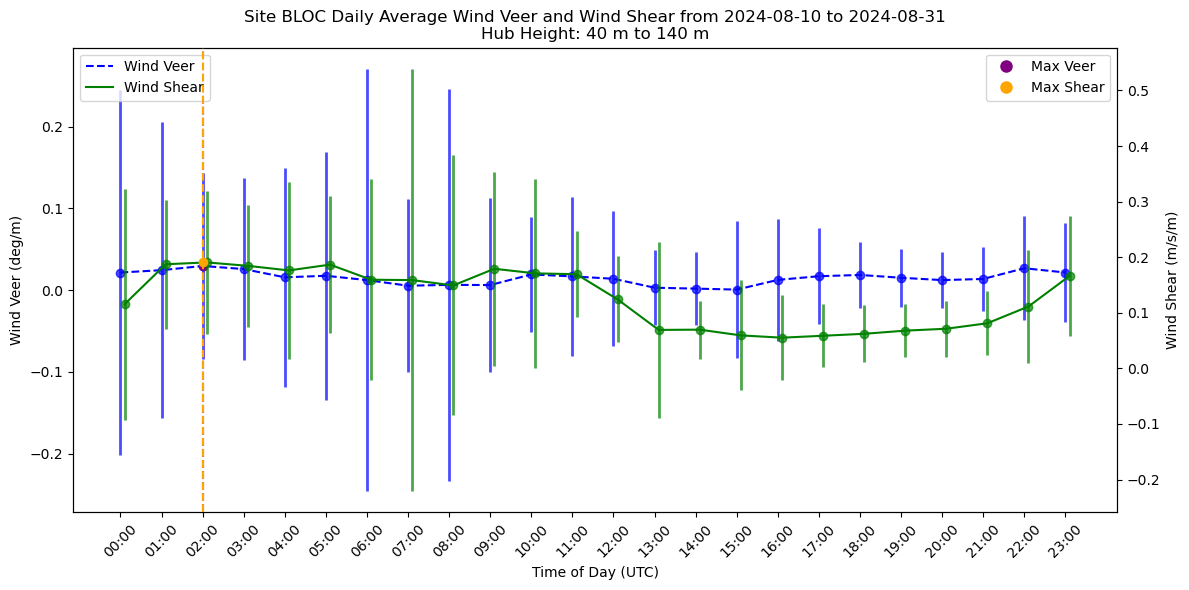


 SEPTEMBER 2024
Maximum Wind Veer: 0.0185546875 deg/m at 12:00
Maximum Wind Shear: 0.13116693496704102 m/s/m at 23:00


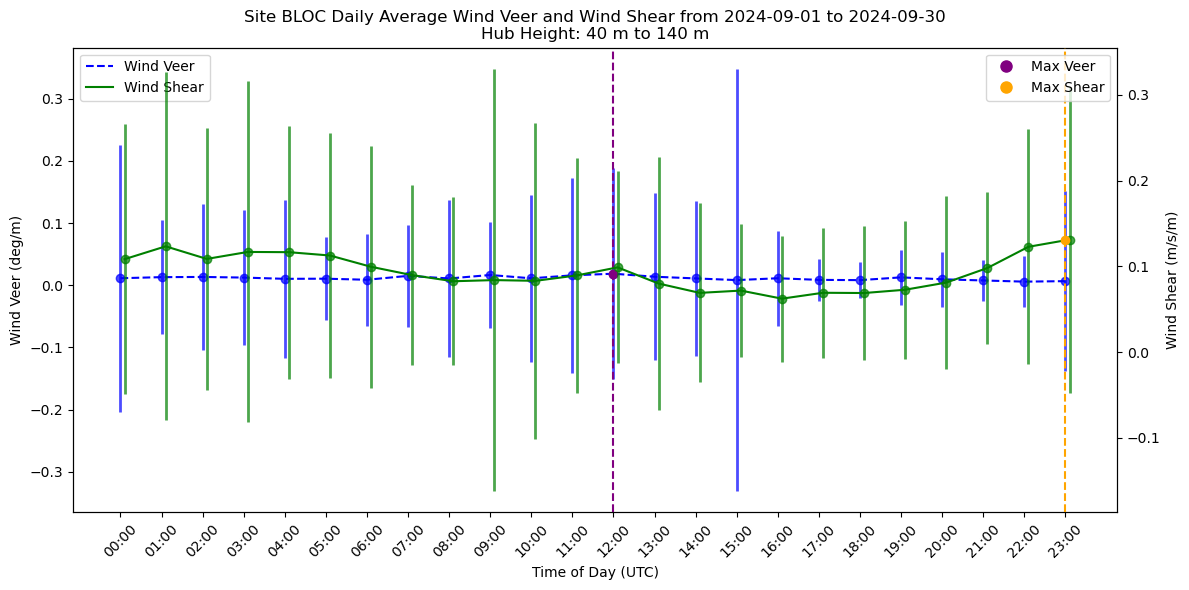


 OCTOBER 2024
Maximum Wind Veer: 0.017309723421931267 deg/m at 11:00
Maximum Wind Shear: 0.171803817152977 m/s/m at 23:00


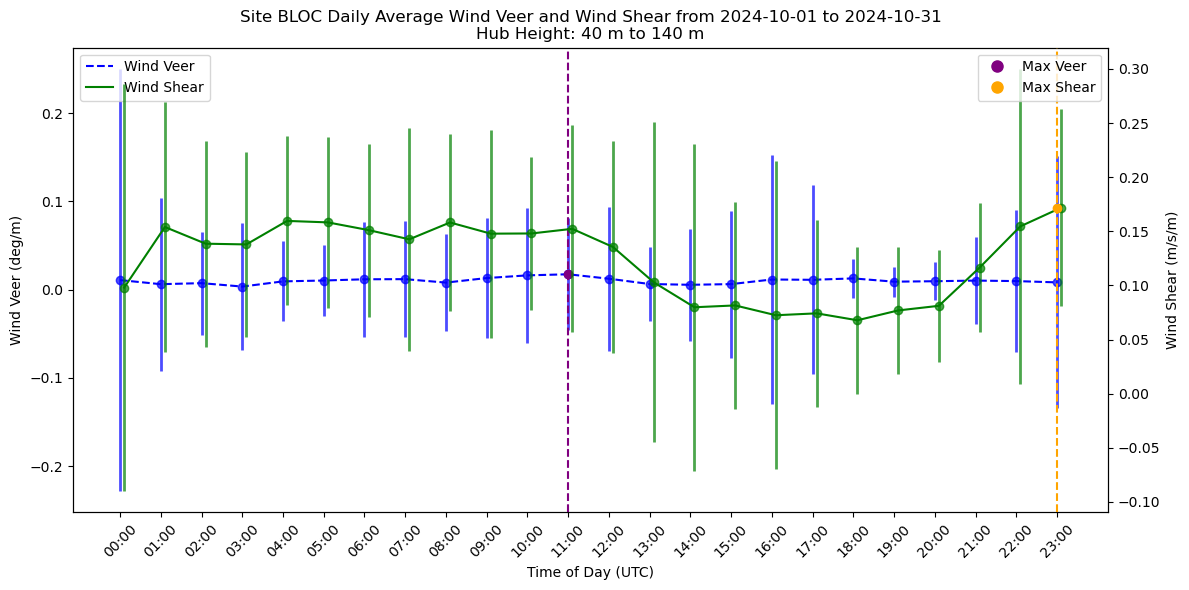


 NOVEMBER 2024
Maximum Wind Veer: 0.012677307240664959 deg/m at 11:00
Maximum Wind Shear: 0.18314212560653687 m/s/m at 22:00


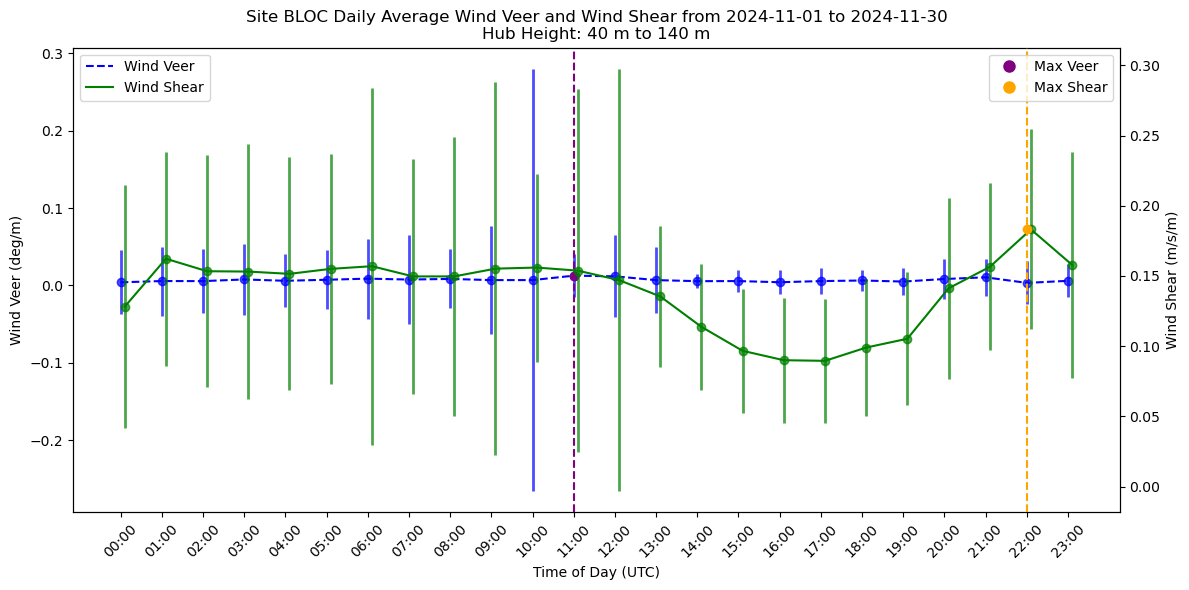


 DECEMBER 2024
Maximum Wind Veer: 0.010436401702463627 deg/m at 14:00
Maximum Wind Shear: 0.15354178845882416 m/s/m at 21:00


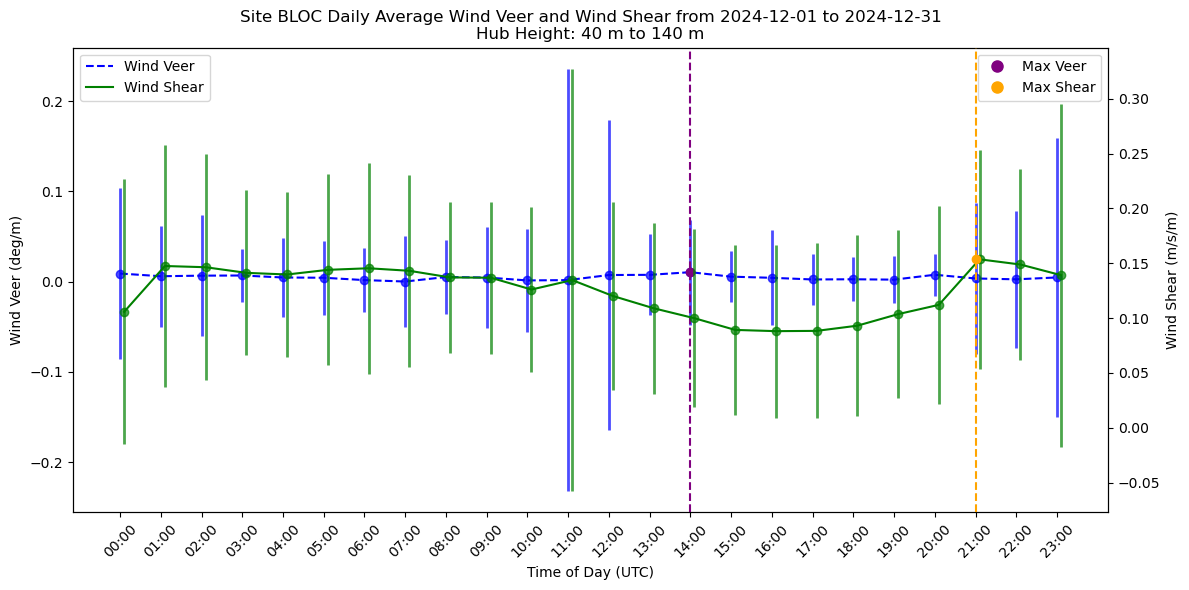


 JANUARY 2025
Maximum Wind Veer: 0.0031723021529614925 deg/m at 21:00
Maximum Wind Shear: 0.15157531201839447 m/s/m at 02:00


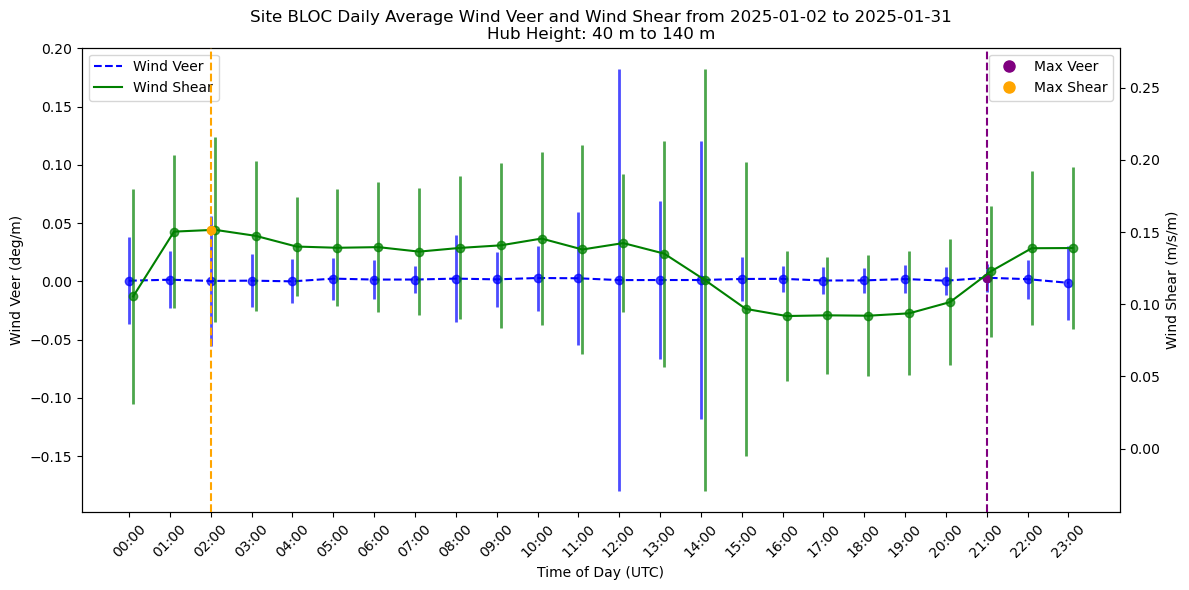


 FEBRUARY 2025
Maximum Wind Veer: 0.01415611244738102 deg/m at 13:00
Maximum Wind Shear: 0.15563562512397766 m/s/m at 05:00


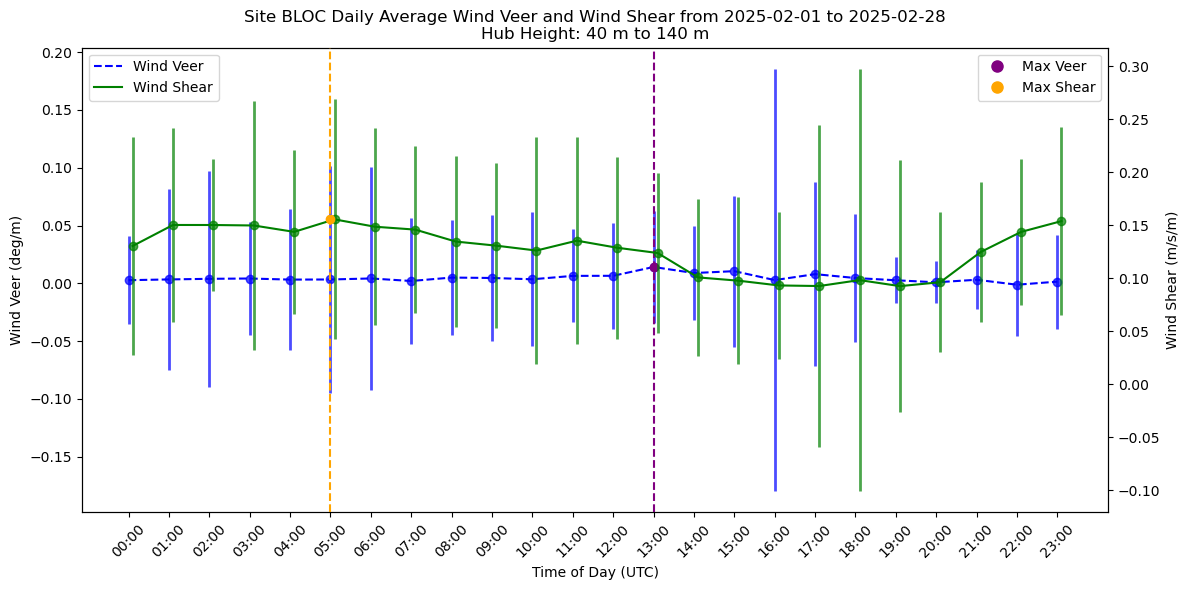


 MARCH 2025
Maximum Wind Veer: 0.019946593791246414 deg/m at 00:00
Maximum Wind Shear: 0.195881649851799 m/s/m at 05:00


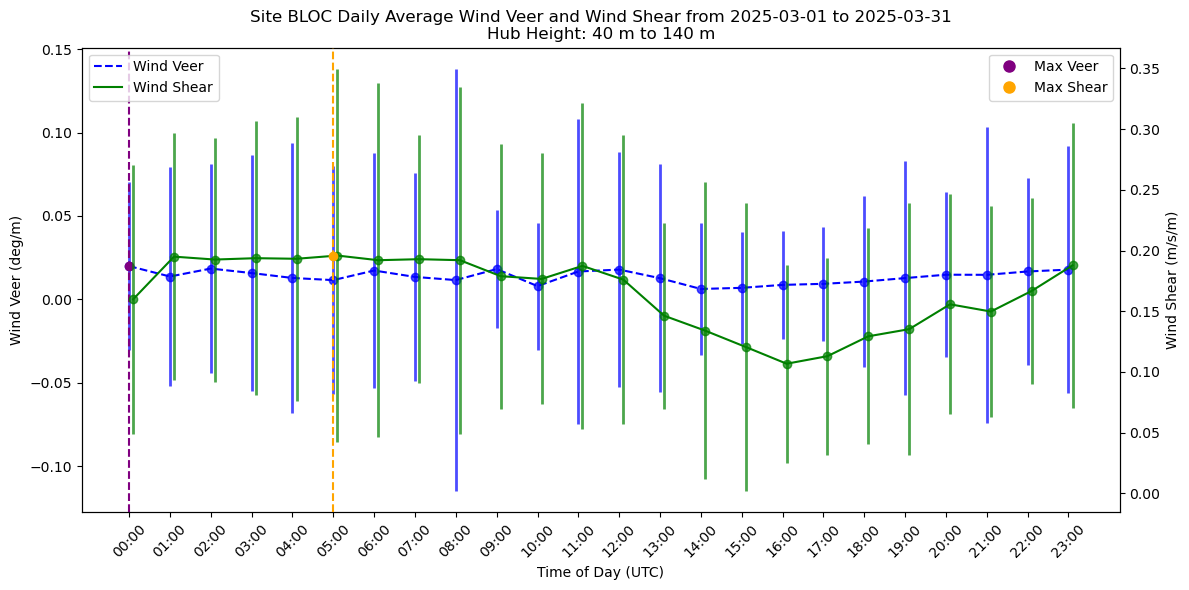


 APRIL 2025
Maximum Wind Veer: 0.04584640637040138 deg/m at 04:00
Maximum Wind Shear: 0.271353542804718 m/s/m at 03:00


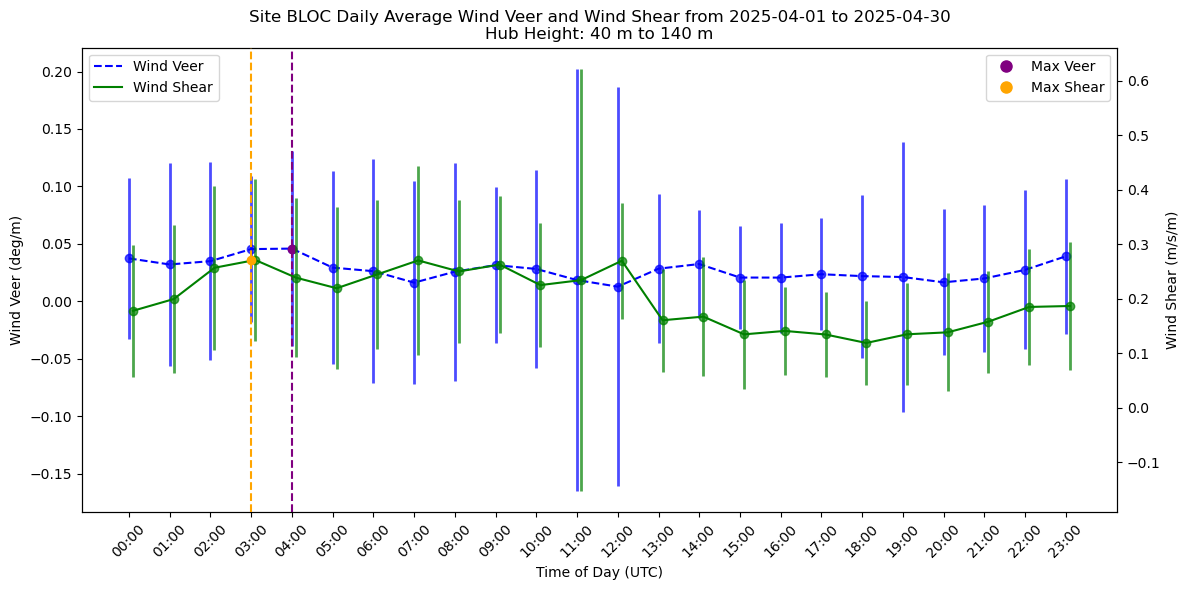


 MAY 2025
Maximum Wind Veer: 0.08297333121299744 deg/m at 04:00
Maximum Wind Shear: 0.2796400487422943 m/s/m at 03:00


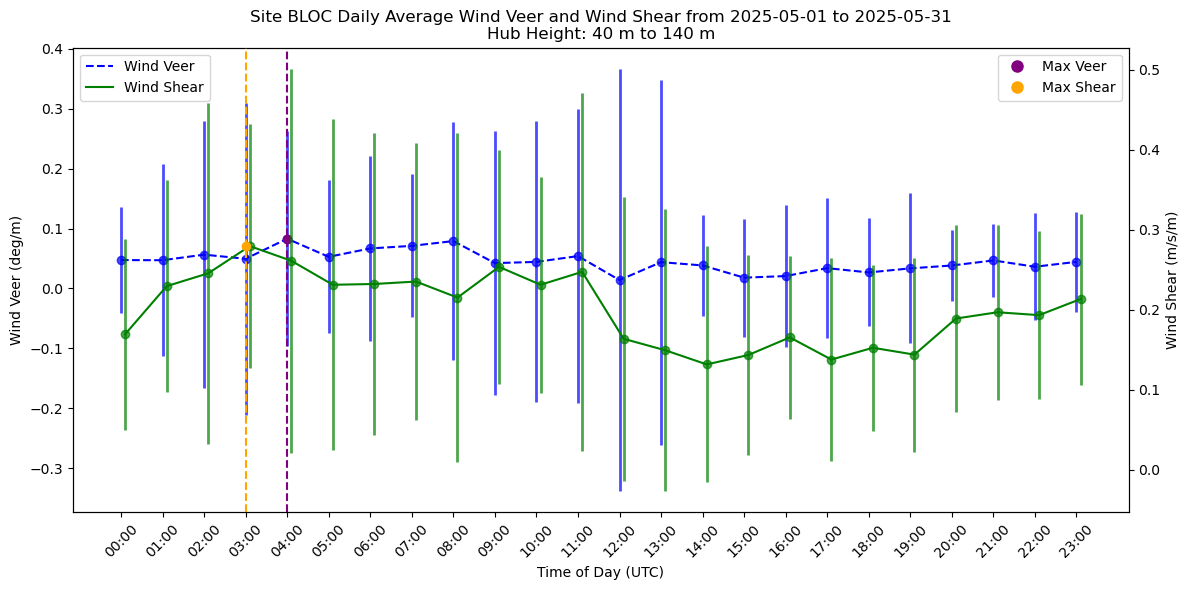


 JUNE 2025
Maximum Wind Veer: 0.1101362556219101 deg/m at 11:00
Maximum Wind Shear: 0.2678481340408325 m/s/m at 03:00


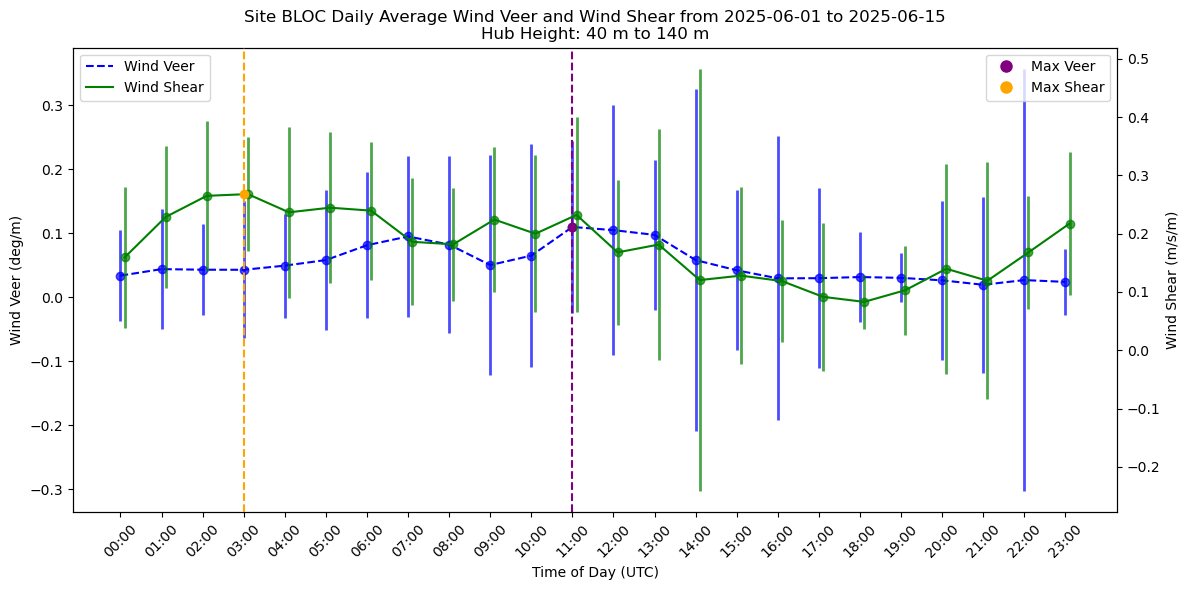

In [71]:
from datetime import datetime
import pandas as pd

# HRRR Directory
directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/HRRR_Data'

# HRRR months you have available — fully hardcoded based on your actual downloaded files
months = [
    # 2024 HRRR data
    ("AUGUST 2024", '20240810', '20240831'),
    ("SEPTEMBER 2024", '20240901', '20240930'),
    ("OCTOBER 2024", '20241001', '20241031'),
    ("NOVEMBER 2024", '20241101', '20241130'),
    ("DECEMBER 2024", '20241201', '20241231'),

    # 2025 HRRR data (files start at julian 002 = Jan 2)
    ("JANUARY 2025", '20250102', '20250131'),
    ("FEBRUARY 2025", '20250201', '20250228'),
    ("MARCH 2025", '20250301', '20250331'),
    ("APRIL 2025", '20250401', '20250430'),
    ("MAY 2025", '20250501', '20250531'),
    ("JUNE 2025", '20250601', '20250615')  # only have up to day 166
]

for month_name, start_date_str, end_date_str in months:
    print("\n", month_name)
    
    start_date = start_date_str
    end_date = end_date_str
    
    # Filter files for this month
    BLOC_HRRR_files = filter_BLOC_files_by_date(directory, start_date, end_date)

    if not BLOC_HRRR_files:
        print("No files found for", month_name)
        continue

    # Calculate veer and shear
    times, wind_veer = calculate_wind_veer_HRRR(BLOC_HRRR_files)
    times, wind_shear = calculate_wind_shear_HRRR(BLOC_HRRR_files)

    # Plot
    plotDailyAvgWindShearVeer(
        times, 
        wind_veer, 
        wind_shear, 
        pd.to_datetime(start_date), 
        pd.to_datetime(end_date)
    )



Processing JANUARY
No HRRR files found for January 2024
Start Date:  None
End Date:  None
Start Date:  None
End Date:  None


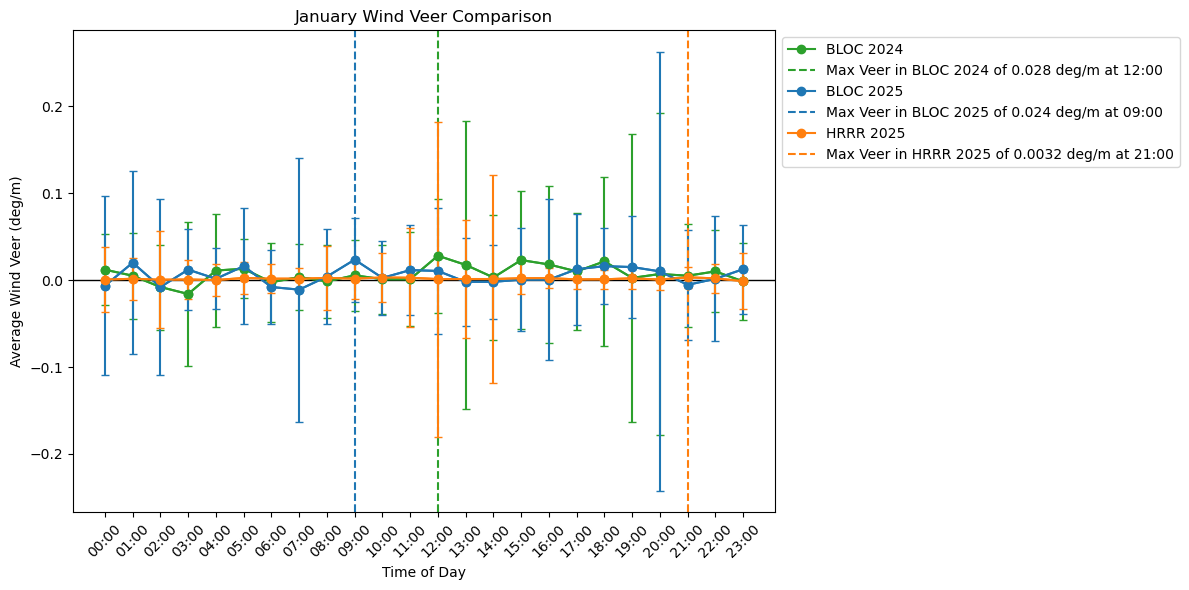

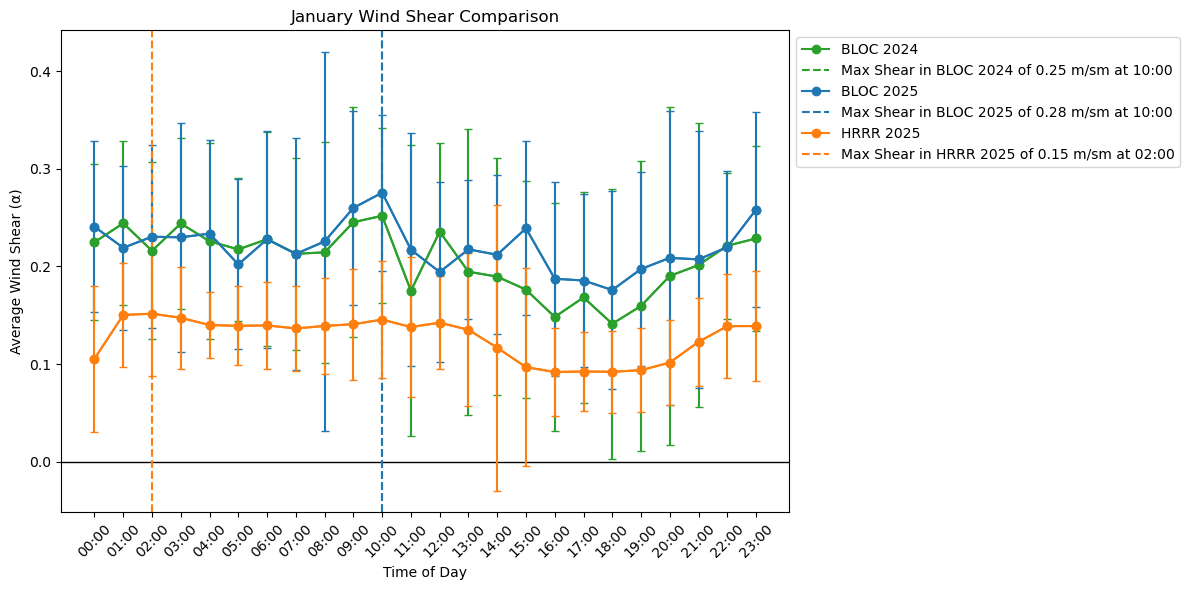

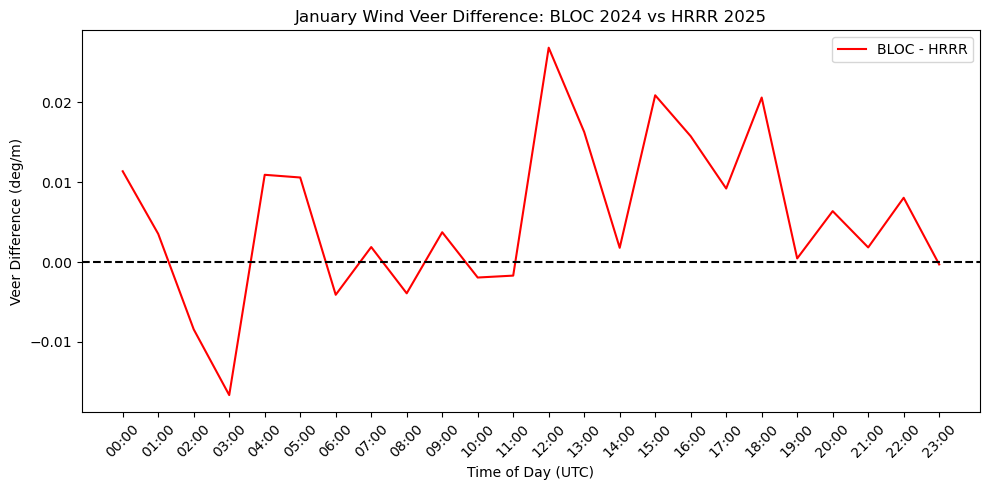

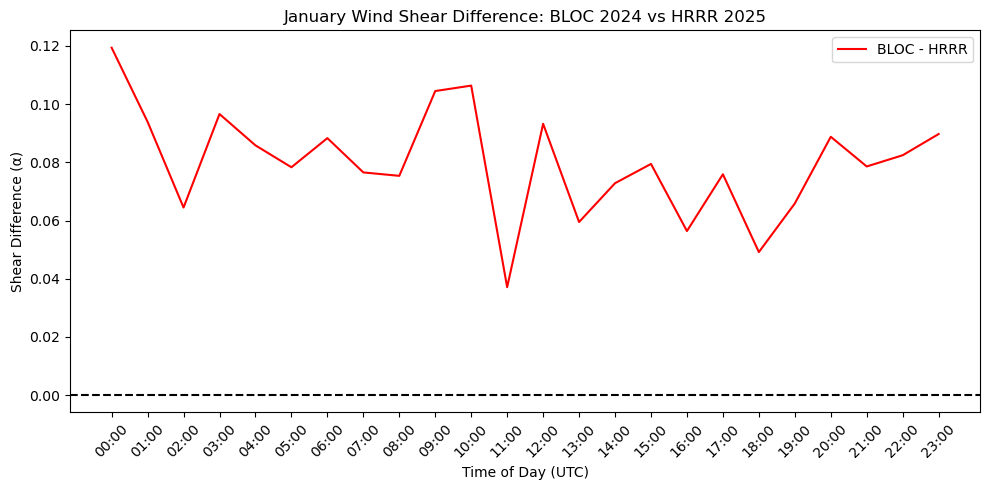

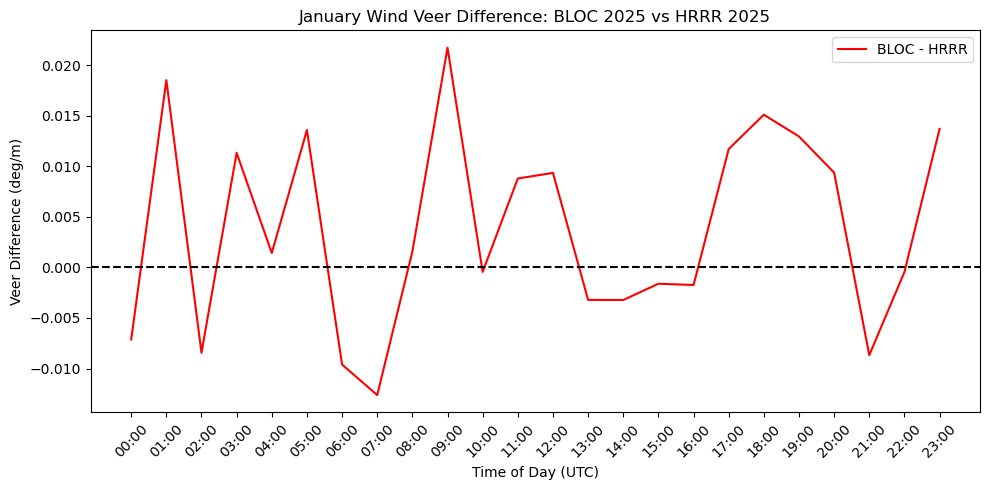

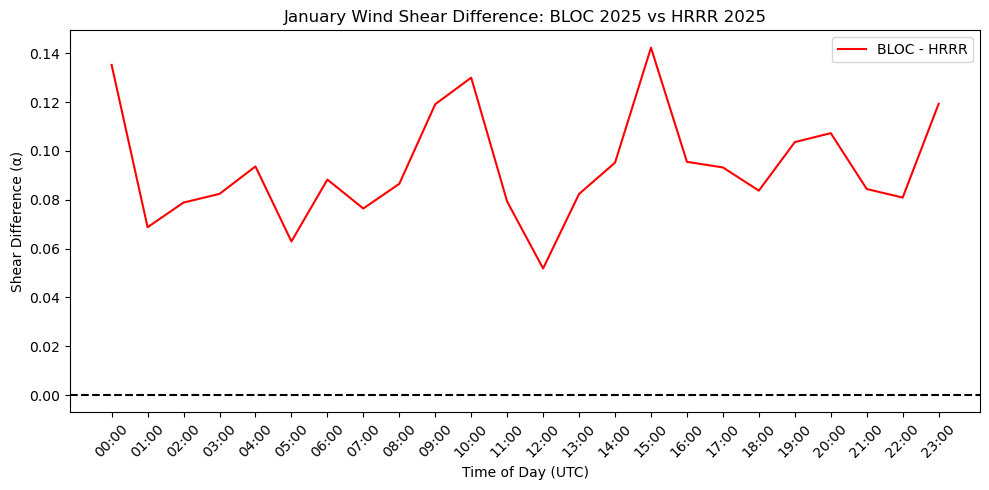


Processing FEBRUARY
No HRRR files found for February 2024
Start Date:  None
End Date:  None


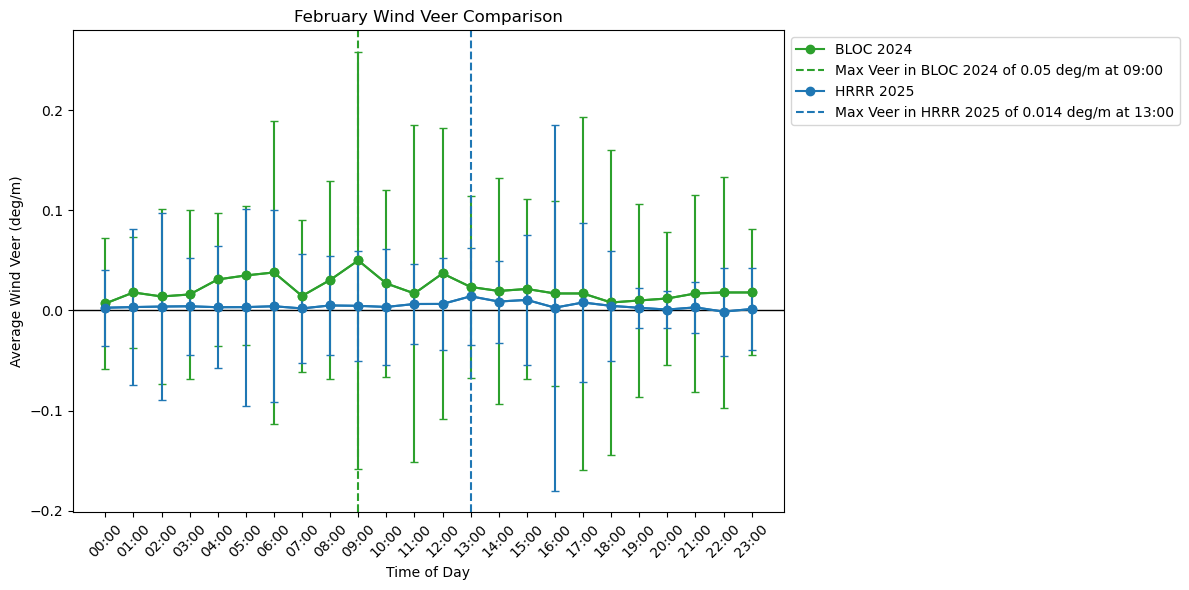

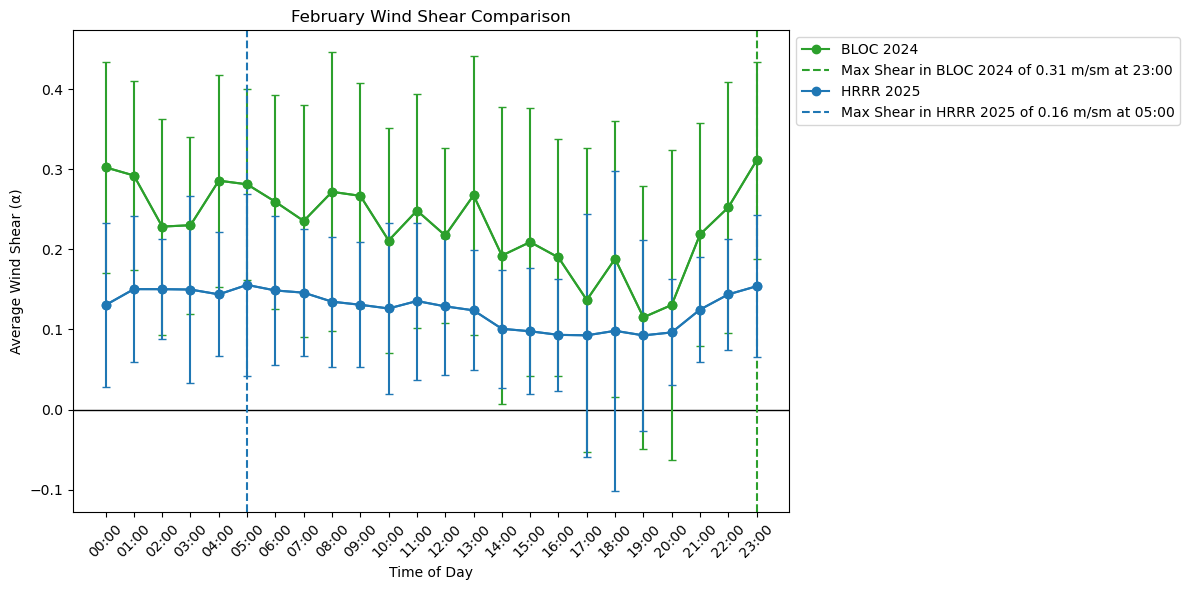

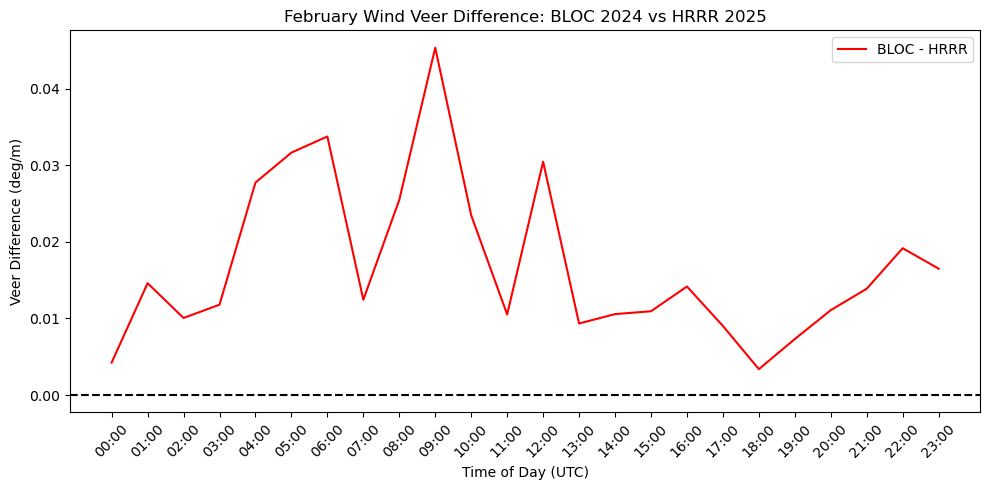

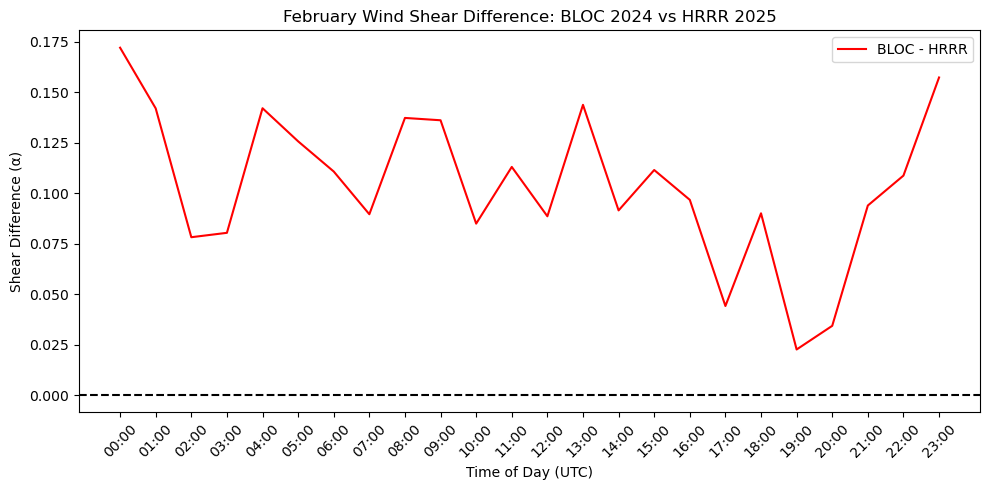


Processing MARCH
No HRRR files found for March 2024
Start Date:  None
End Date:  None


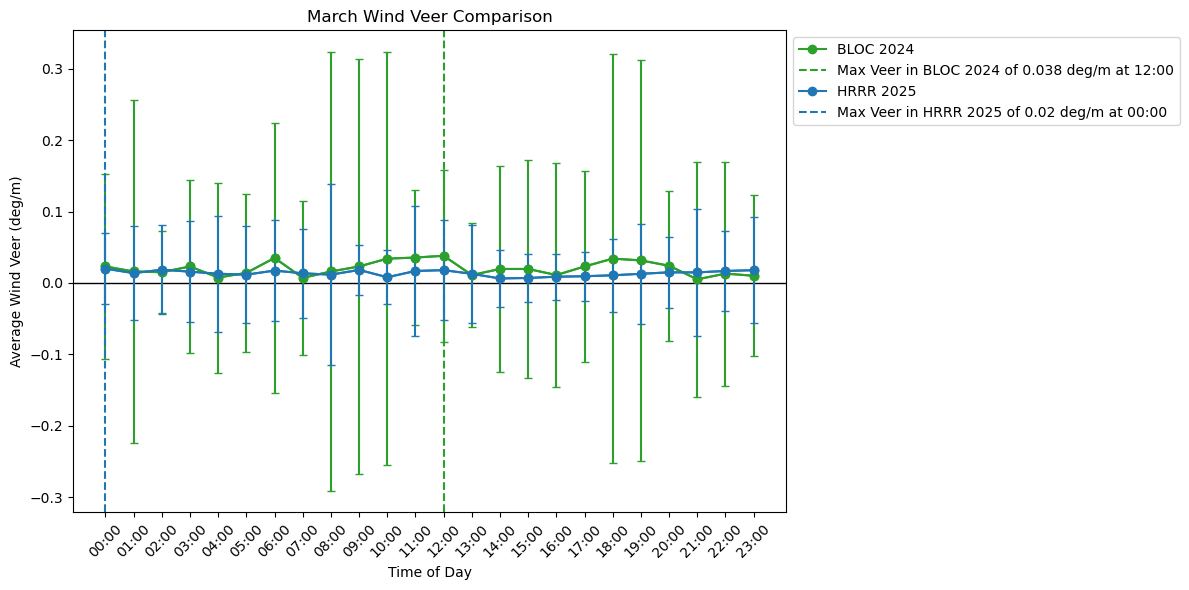

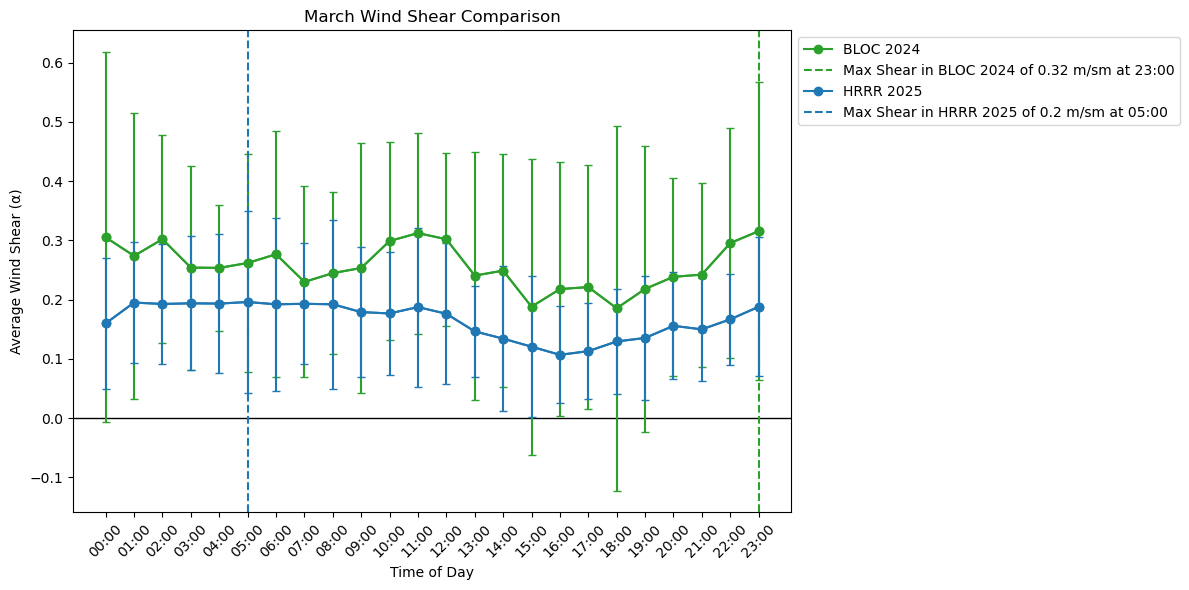

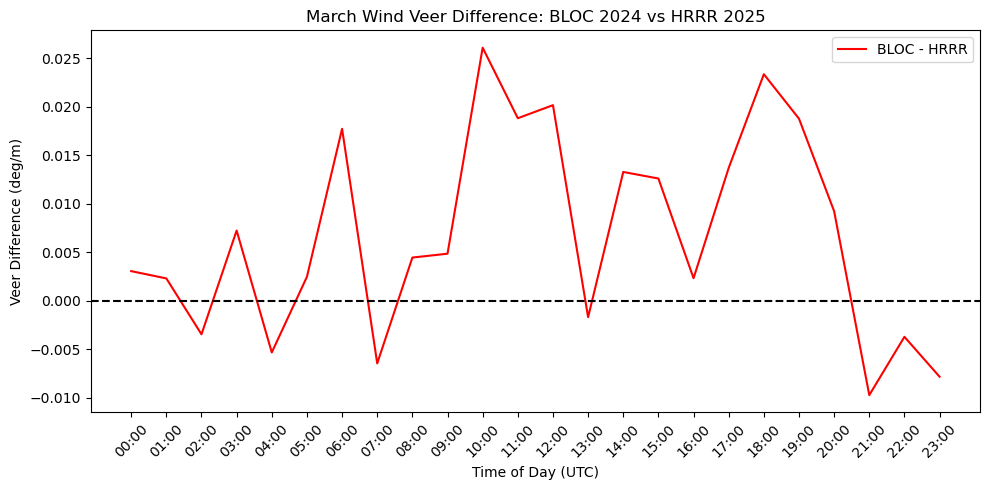

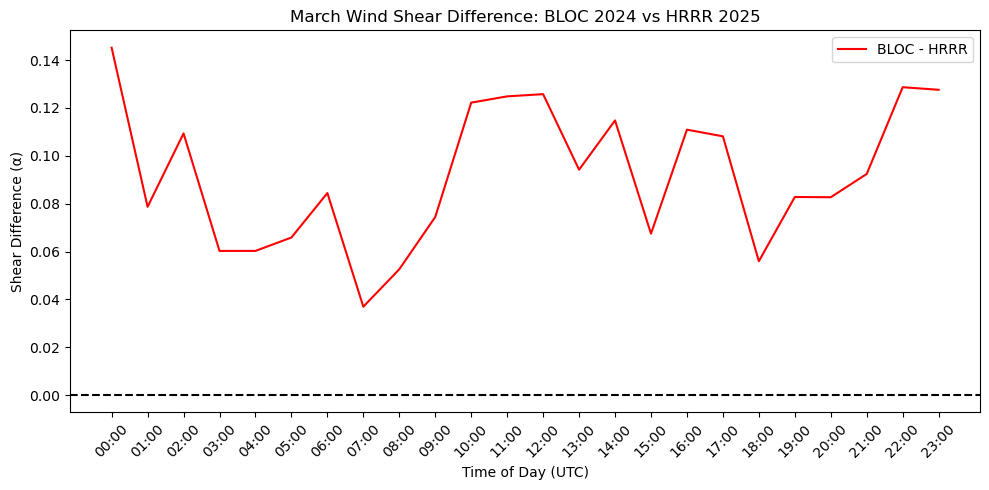


Processing APRIL
No HRRR files found for April 2024
Start Date:  None
End Date:  None


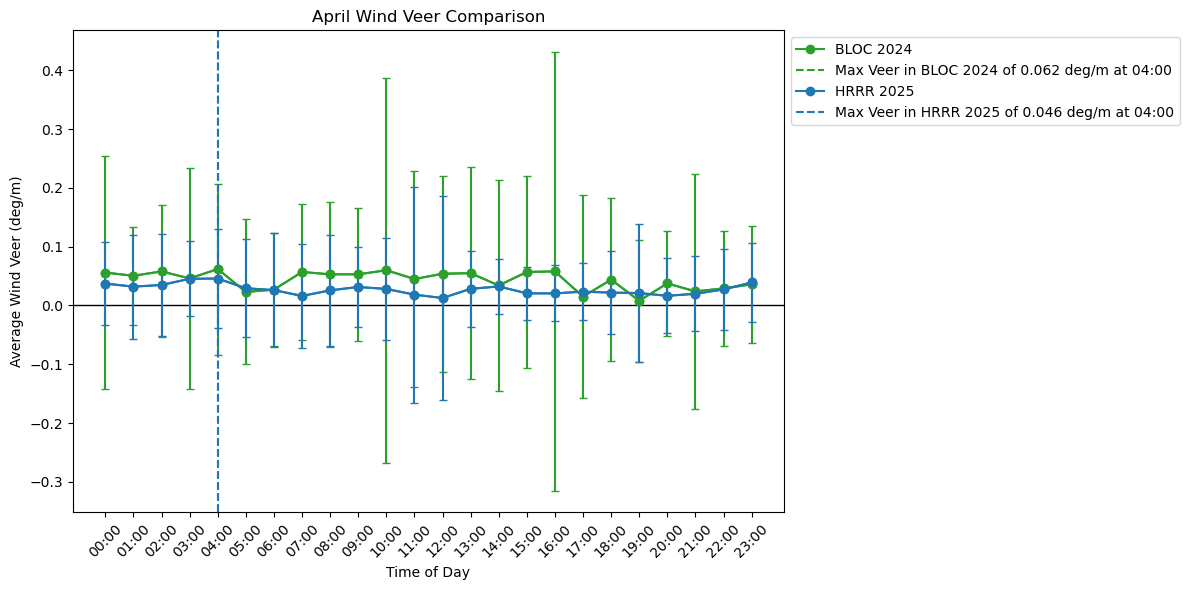

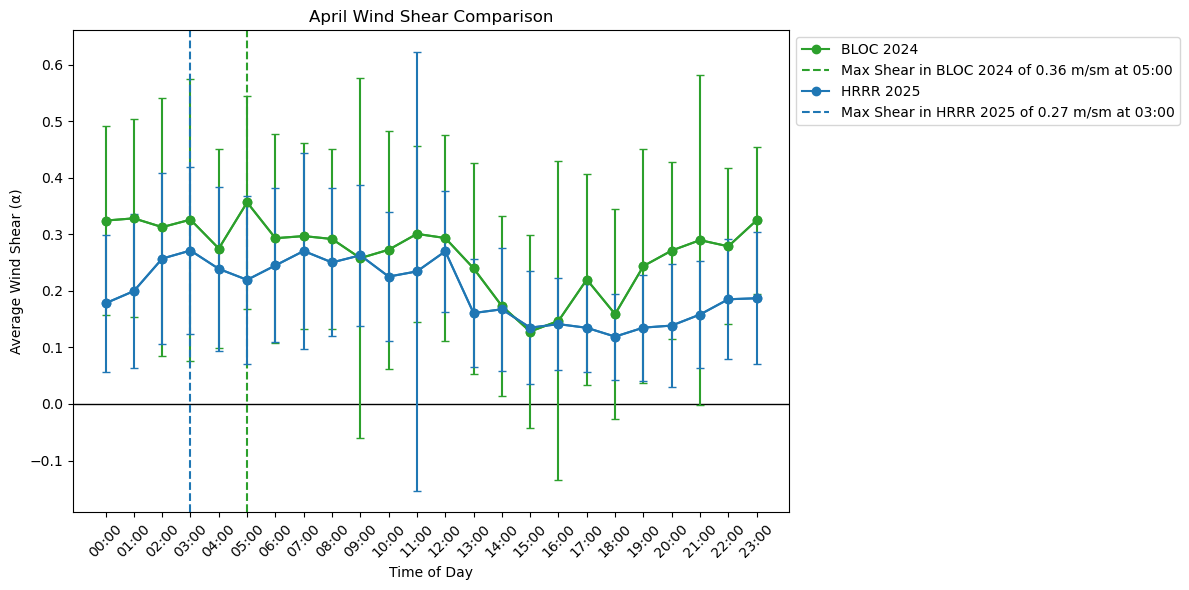

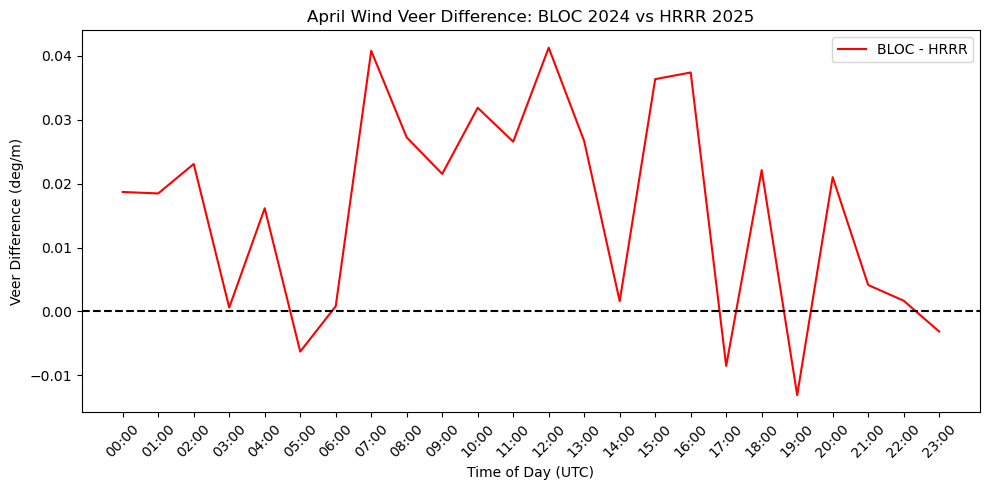

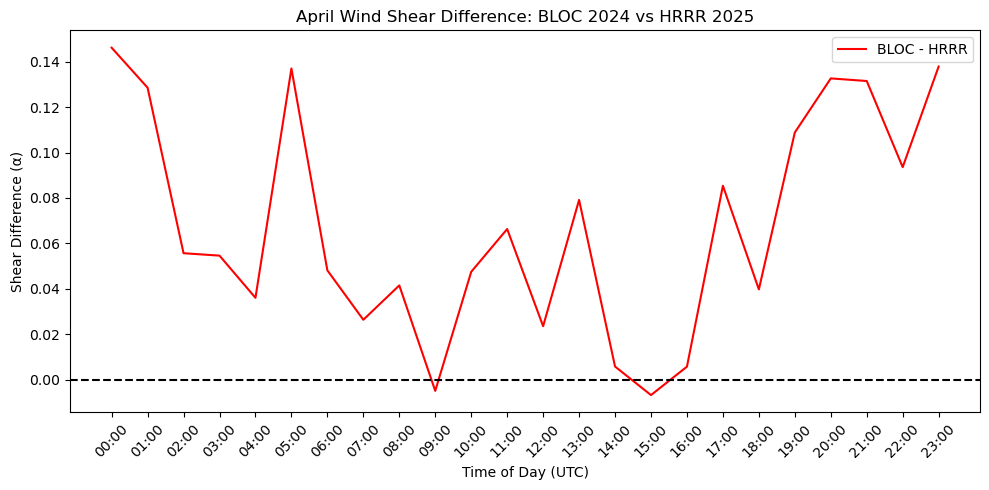


Processing MAY
No HRRR files found for May 2024
Start Date:  None
End Date:  None


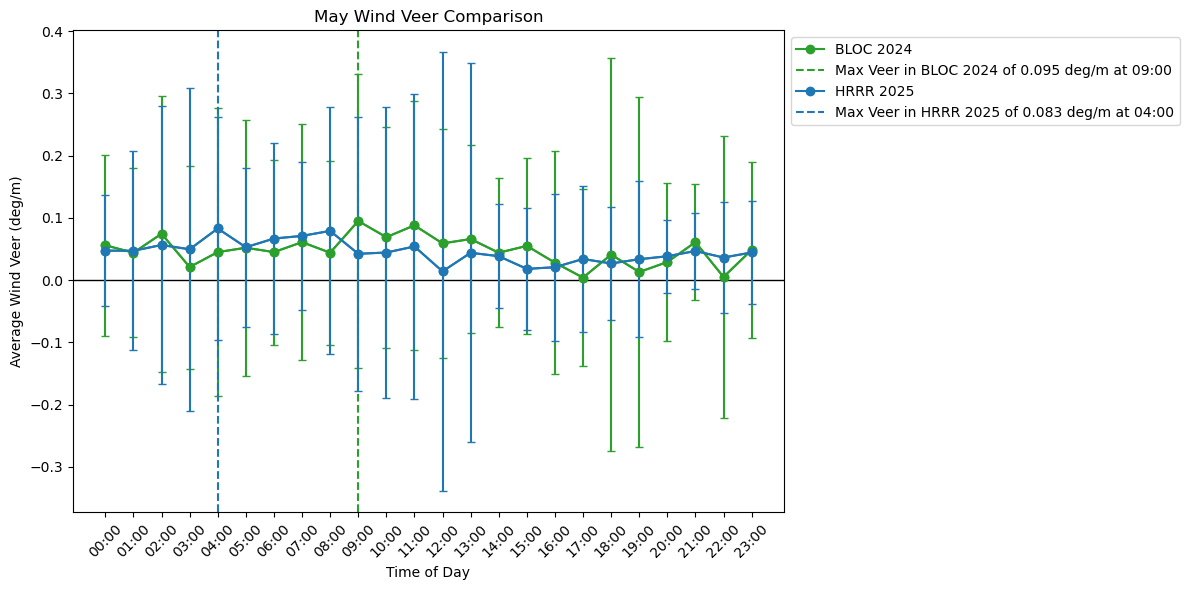

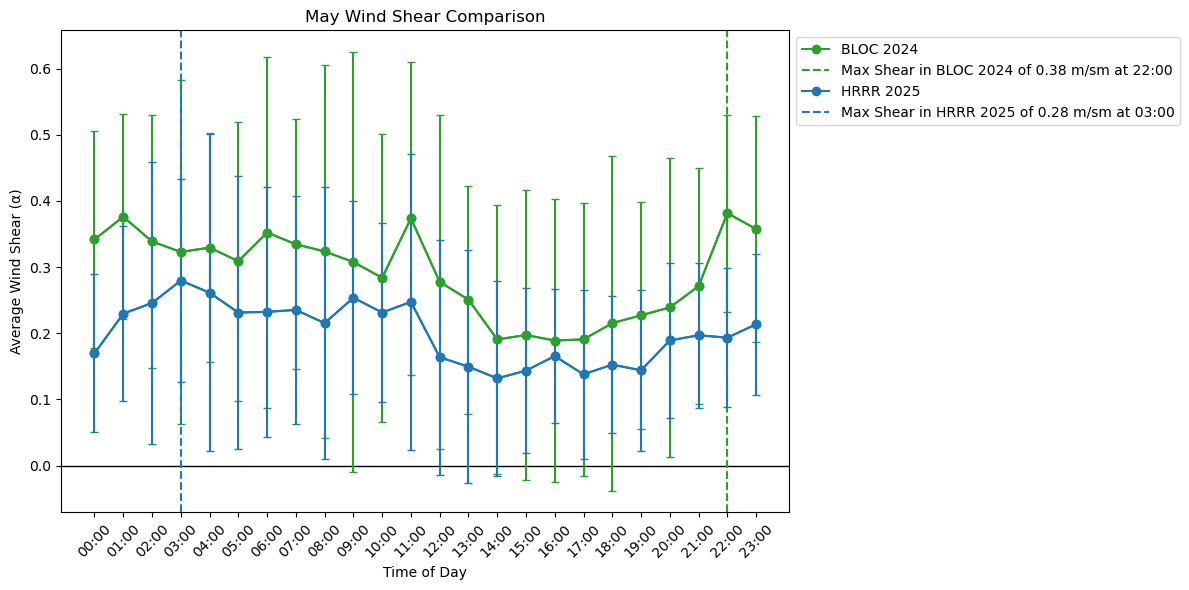

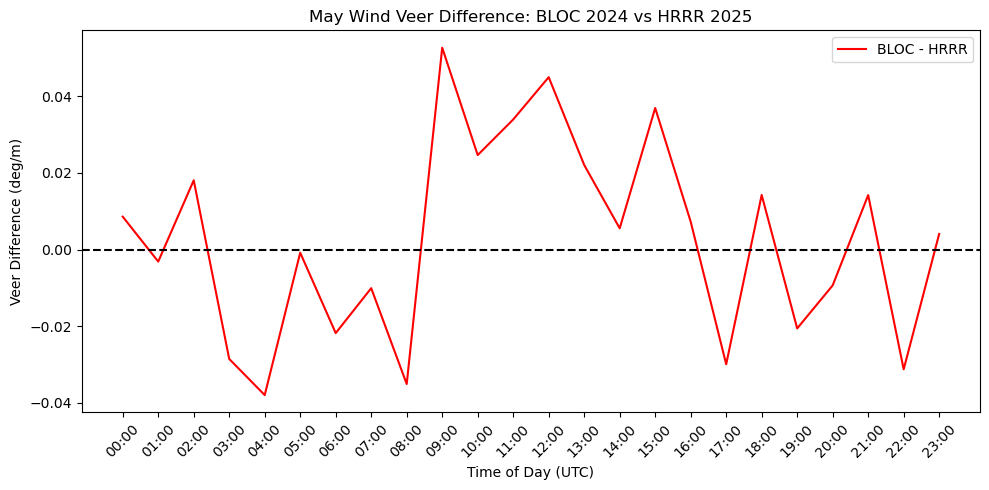

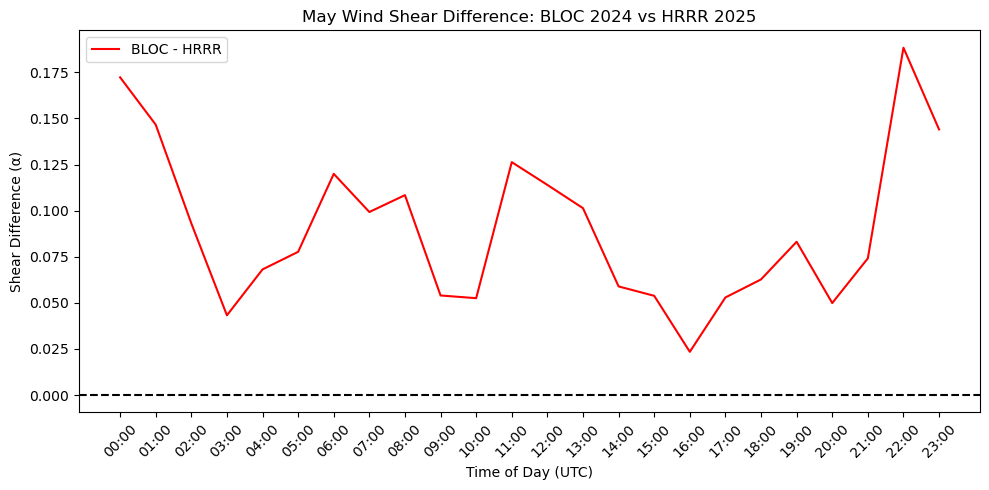


Processing JUNE
No HRRR files found for June 2024
Start Date:  None
End Date:  None


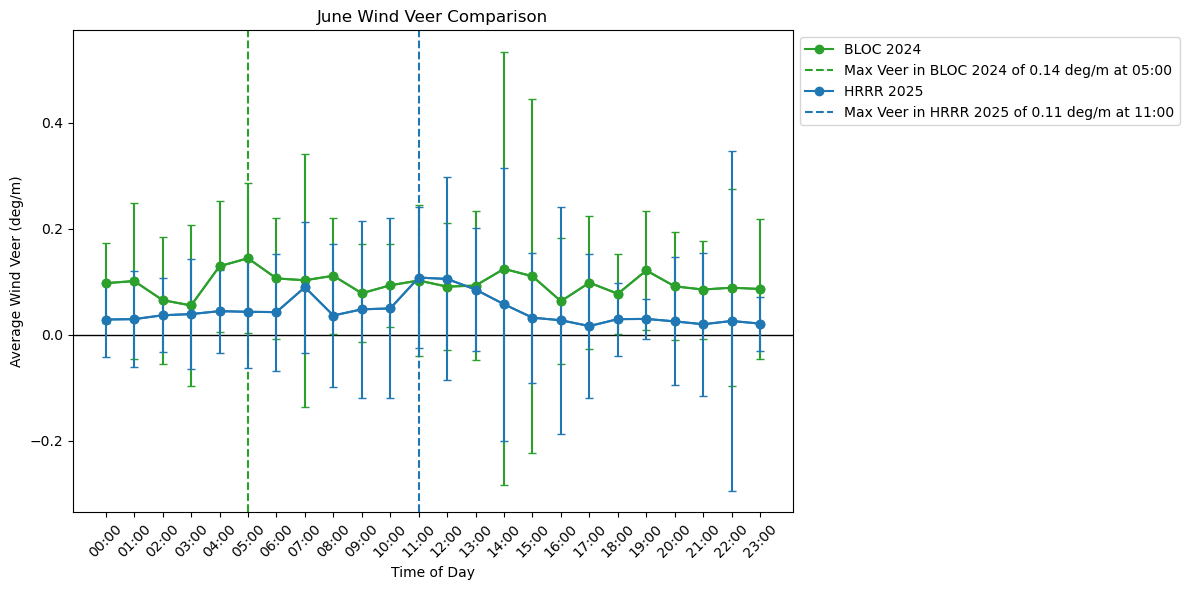

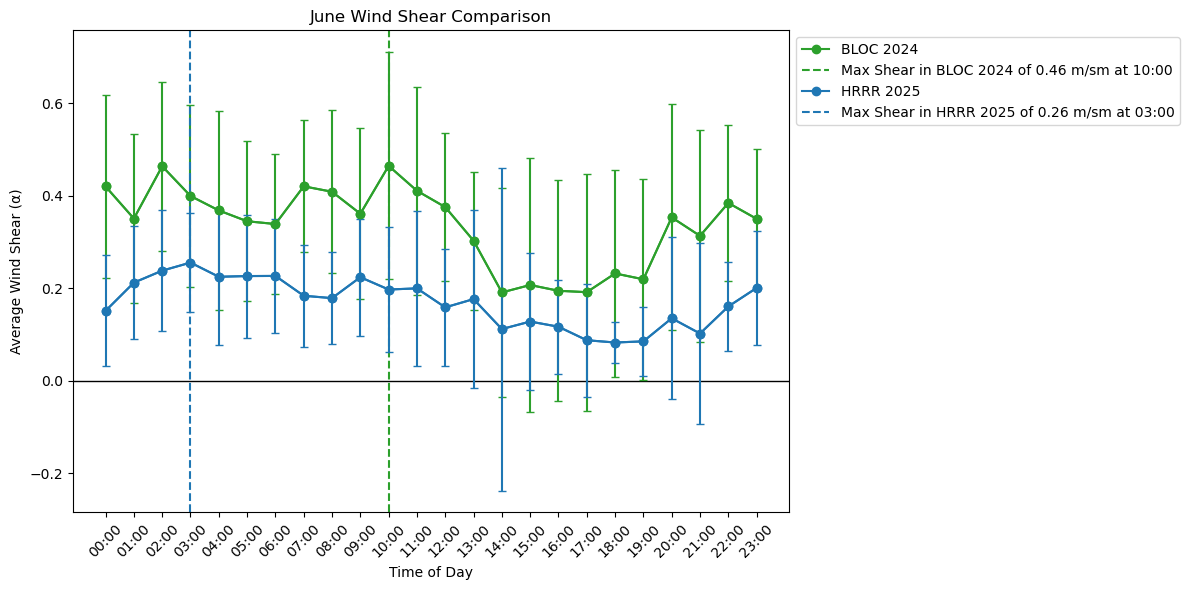

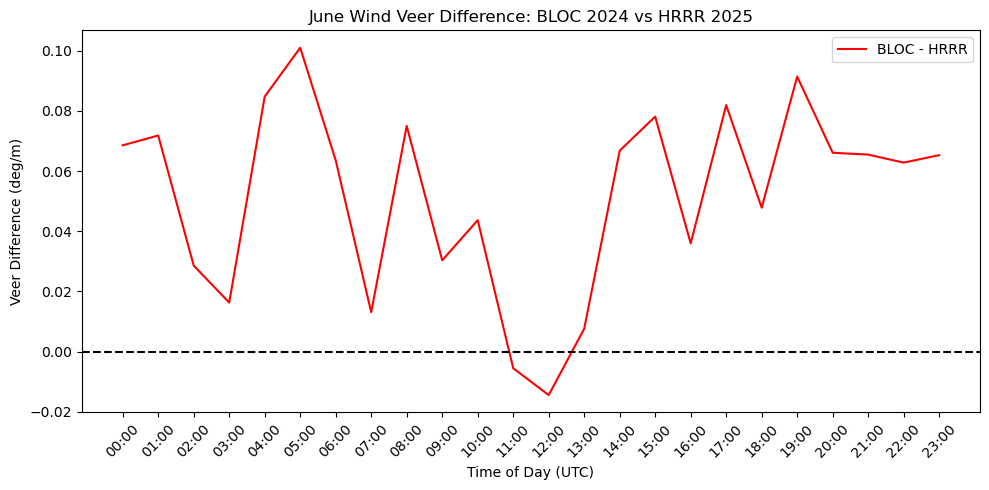

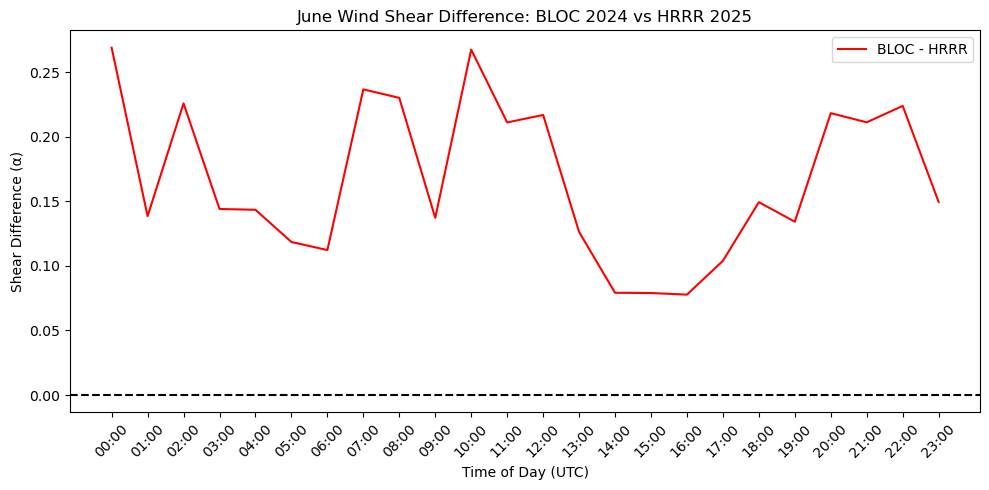


Processing JULY
No HRRR files found for July 2024
No HRRR files found for July 2025

Processing AUGUST
Start Date:  None
End Date:  None


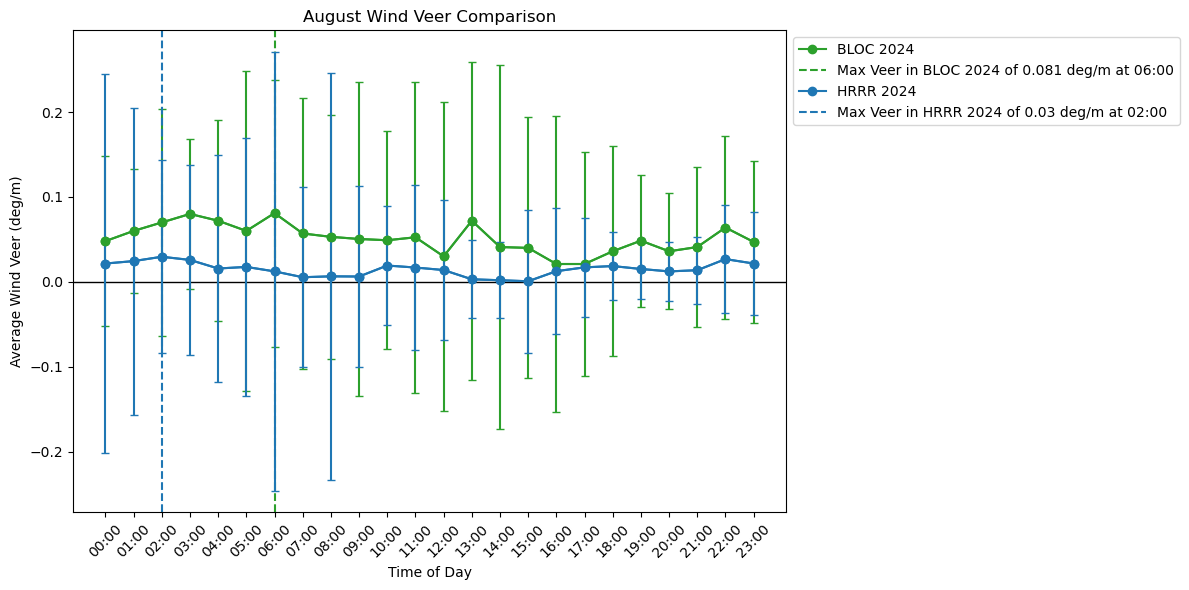

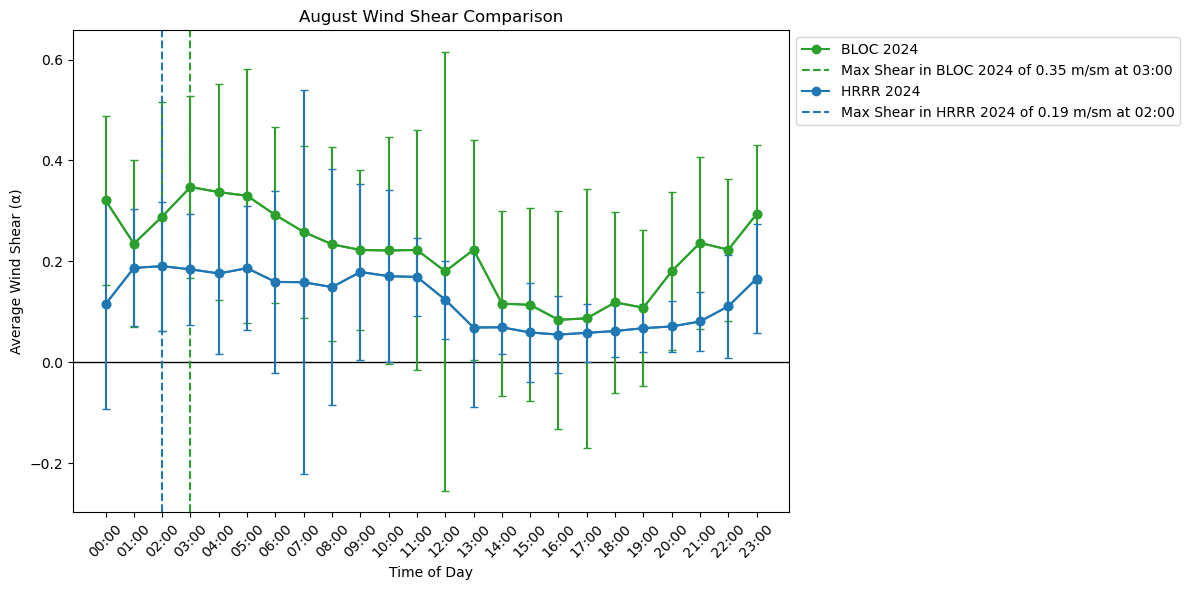

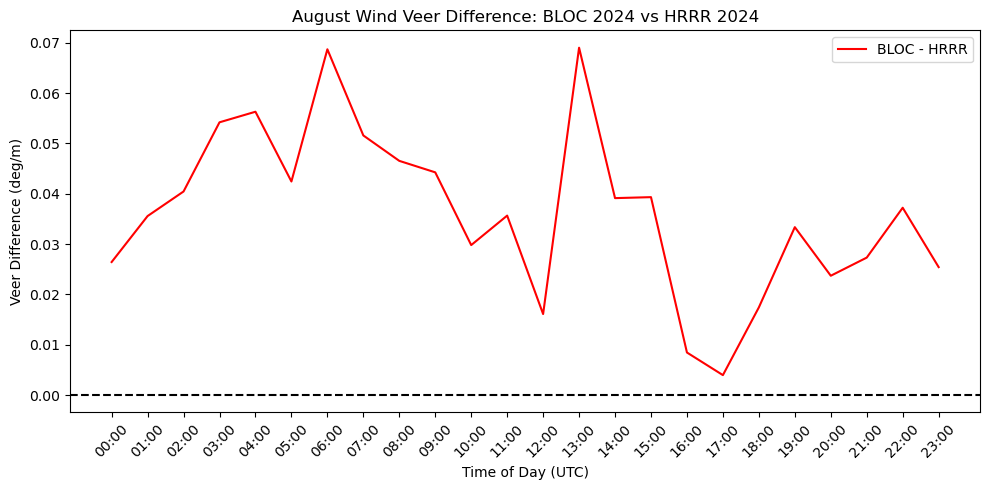

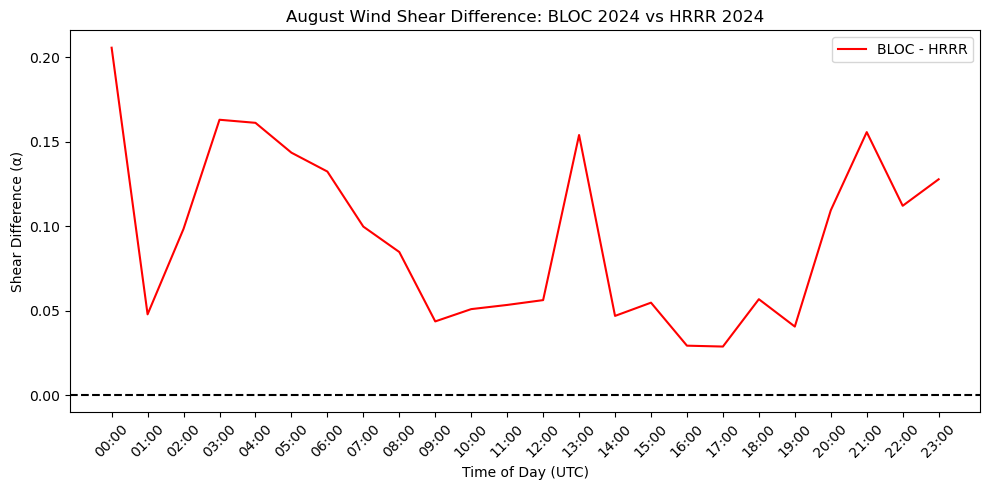

No HRRR files found for August 2025

Processing SEPTEMBER
Start Date:  None
End Date:  None


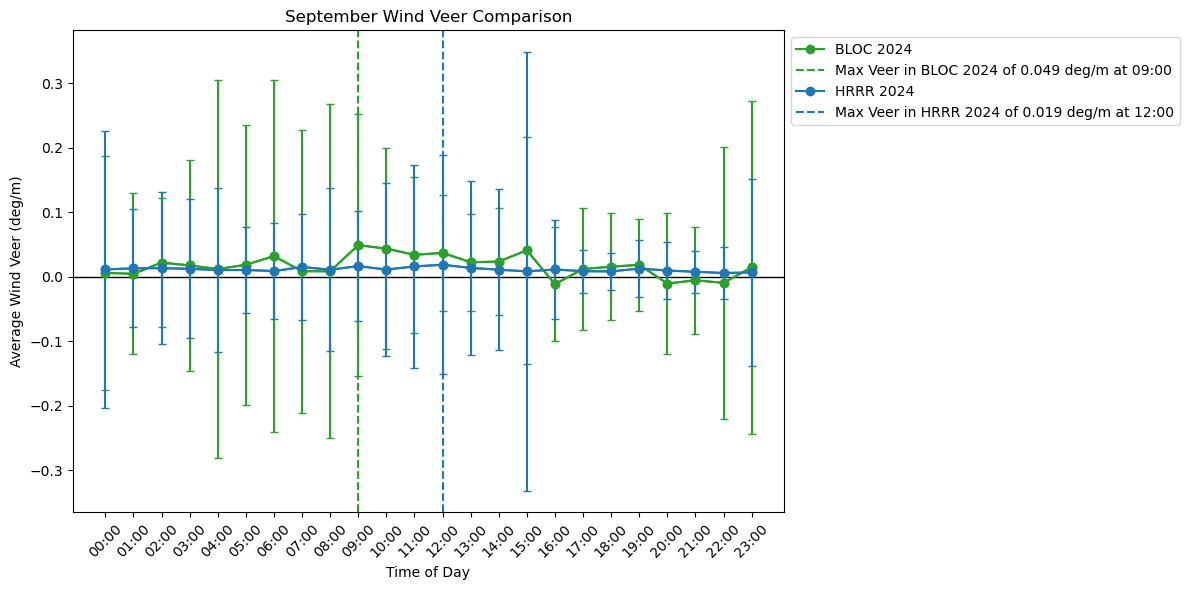

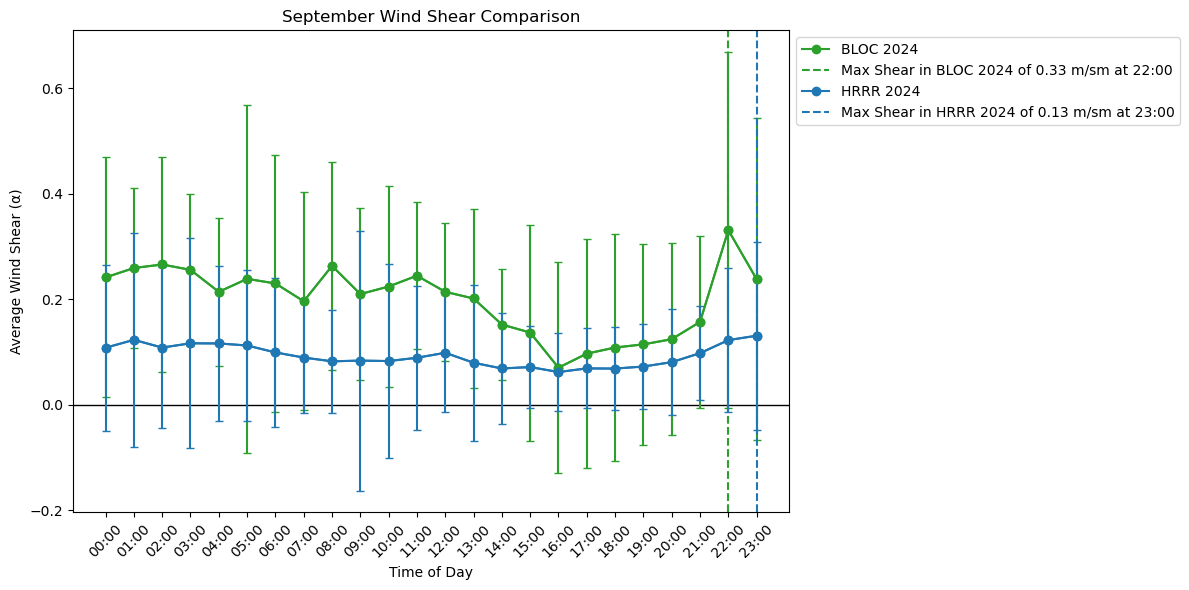

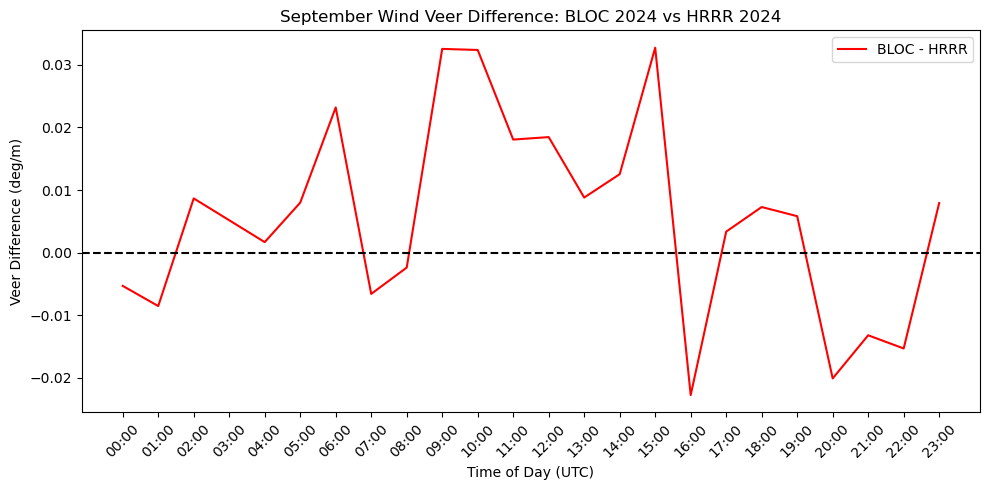

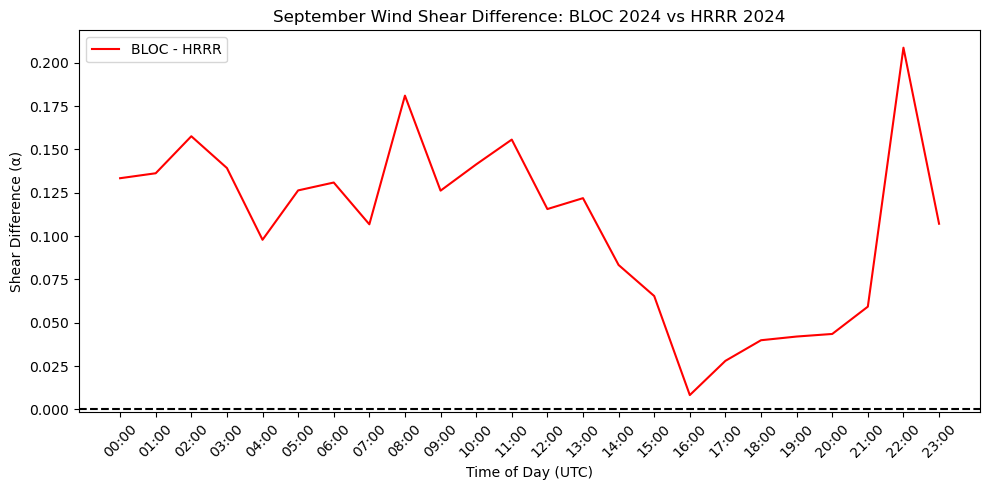

No HRRR files found for September 2025

Processing OCTOBER
Start Date:  None
End Date:  None


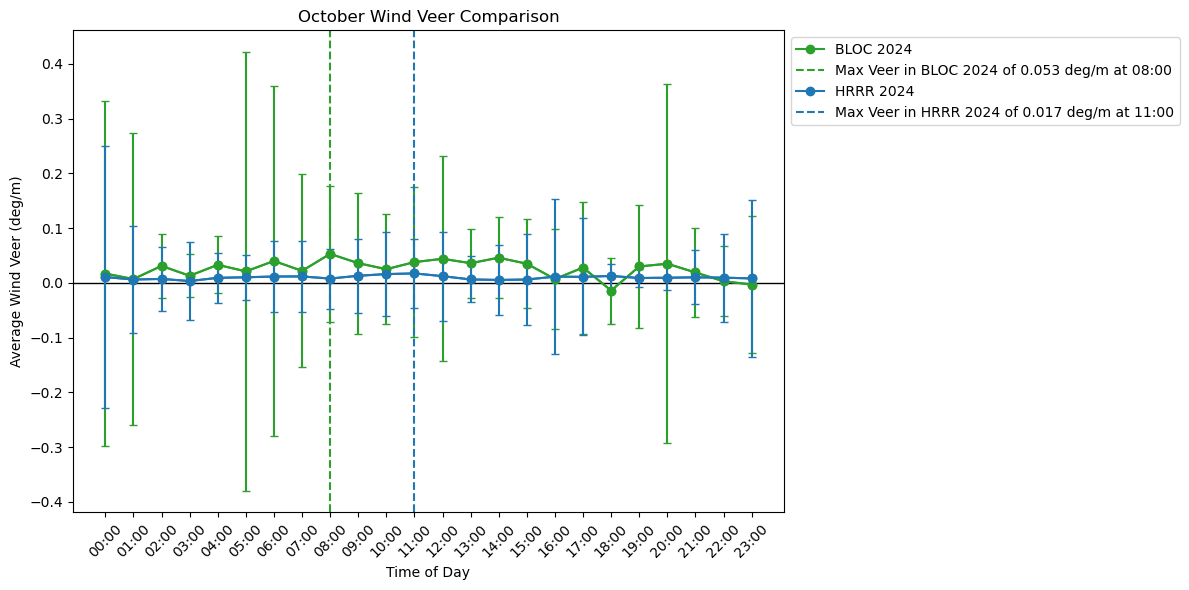

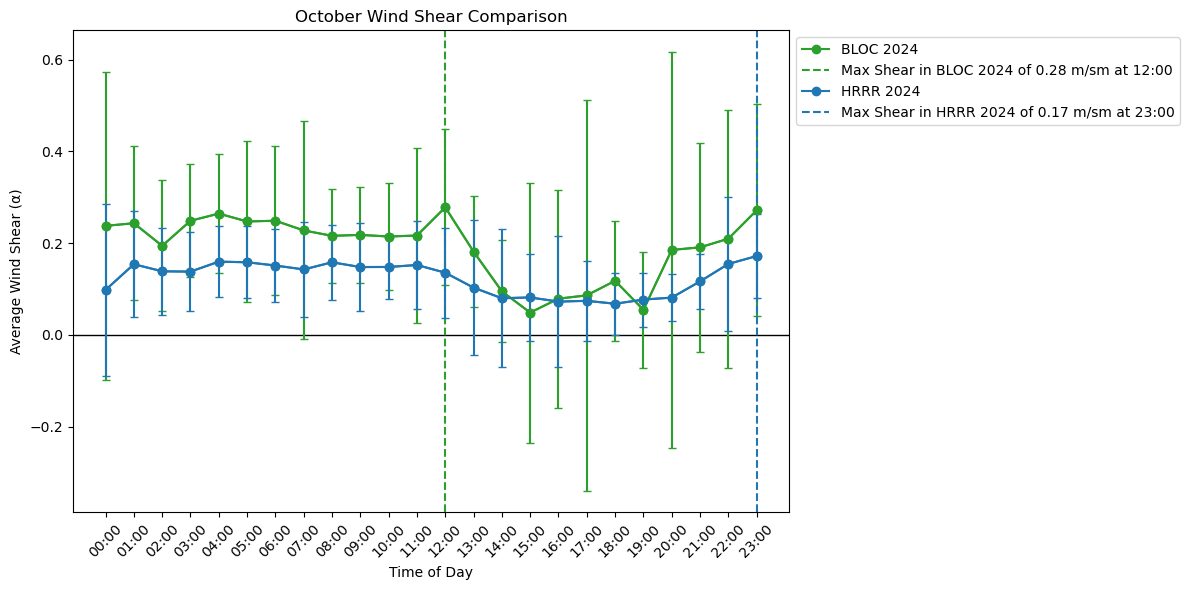

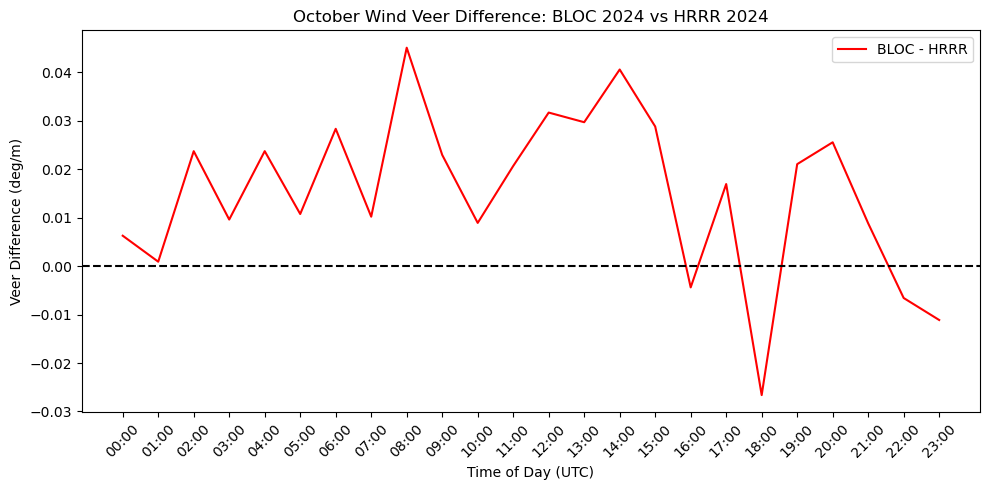

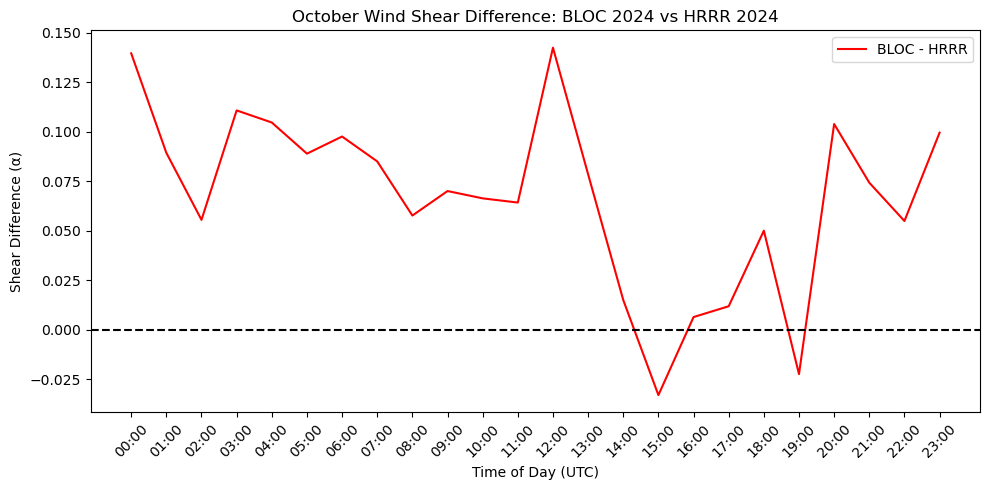

No HRRR files found for October 2025

Processing NOVEMBER
Start Date:  None
End Date:  None


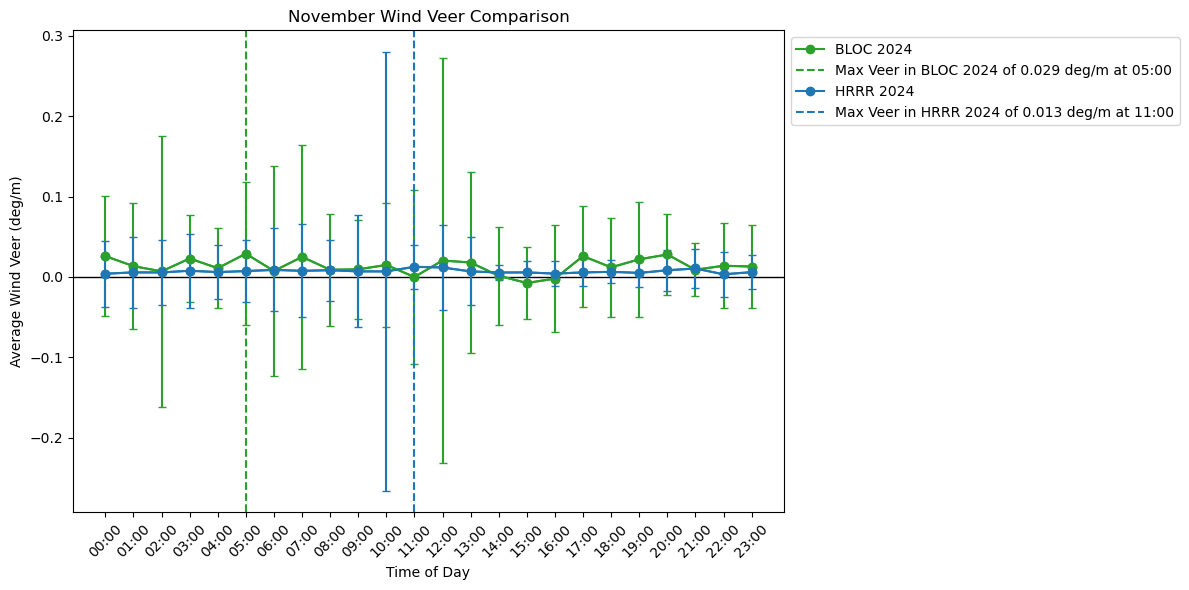

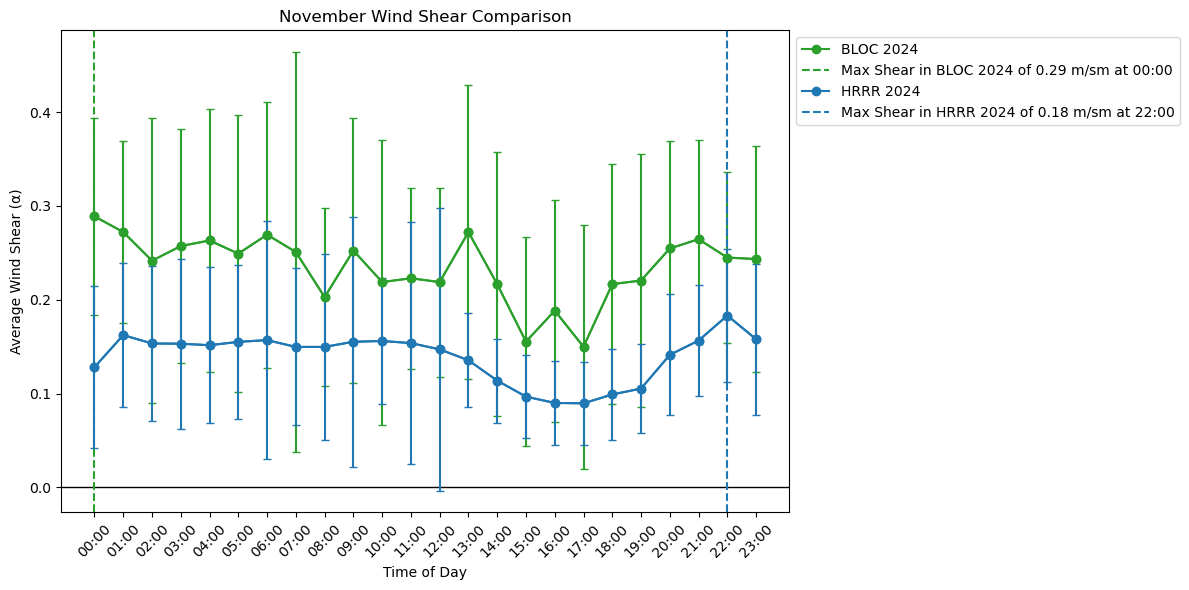

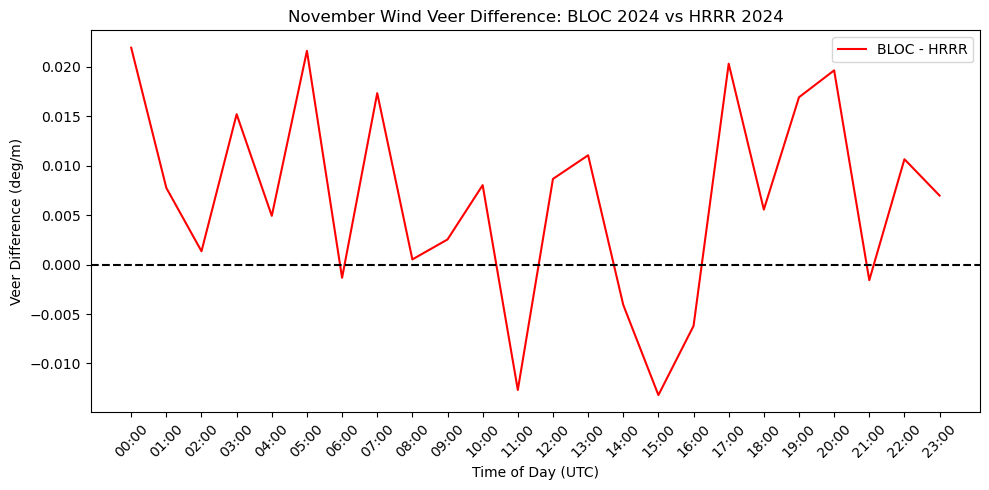

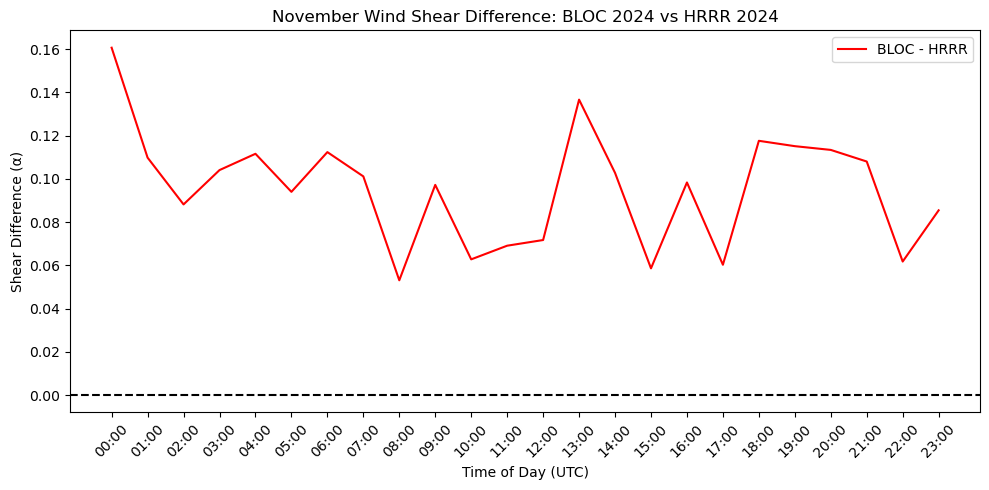

No HRRR files found for November 2025

Processing DECEMBER
Start Date:  None
End Date:  None
Start Date:  None
End Date:  None


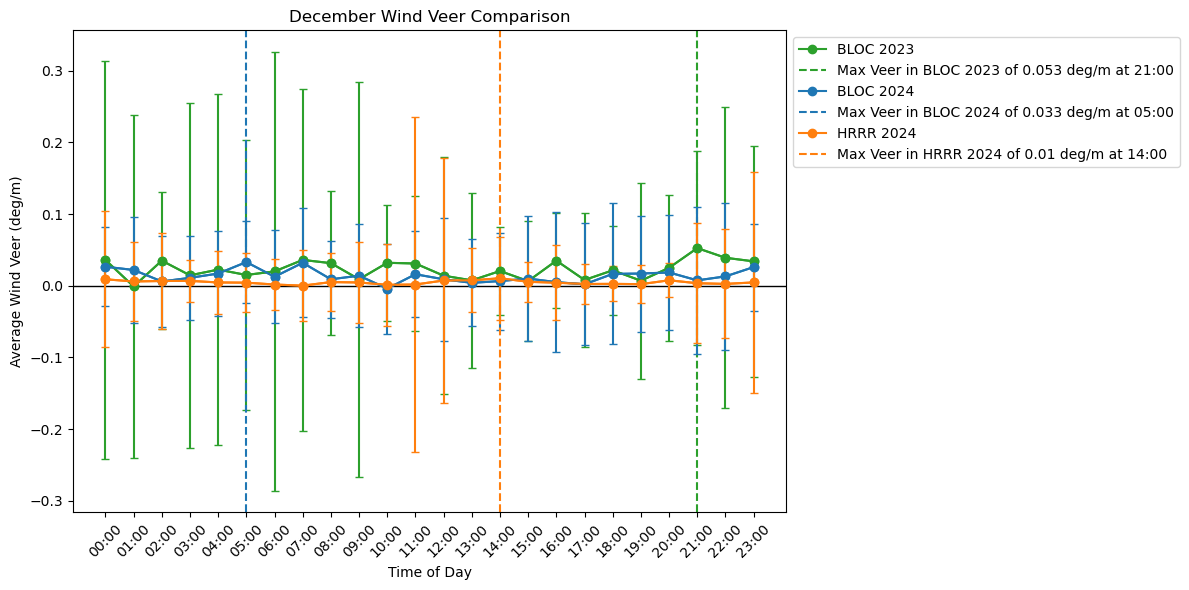

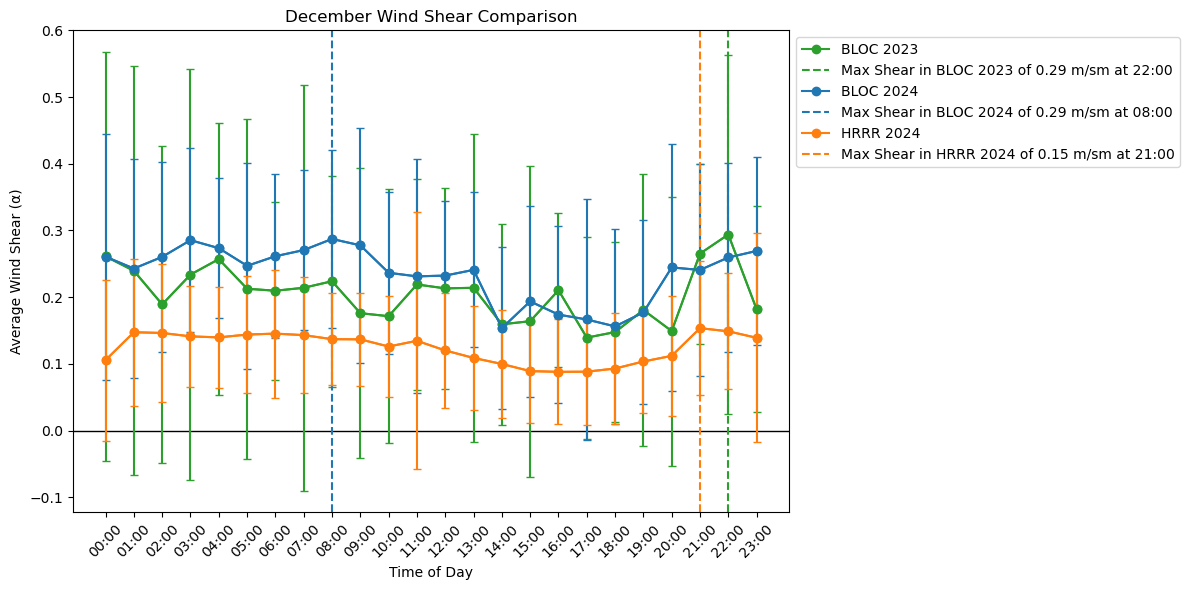

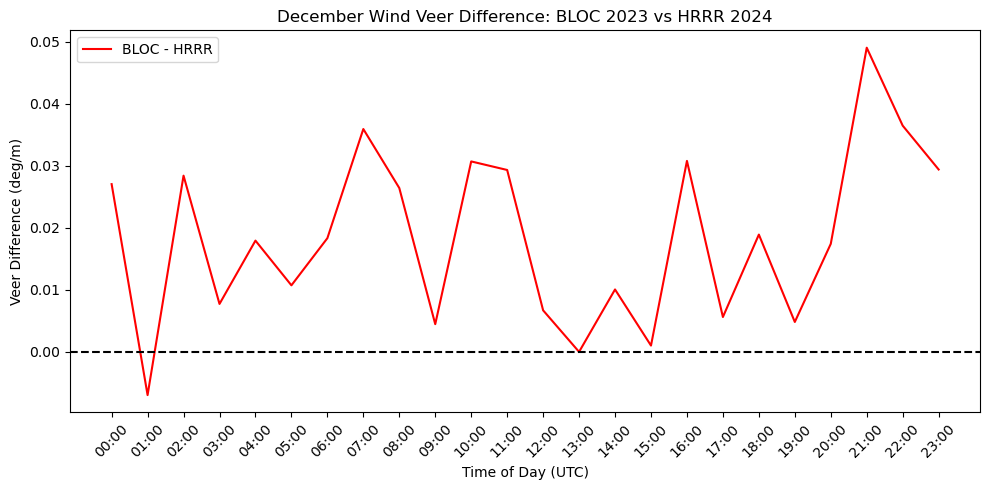

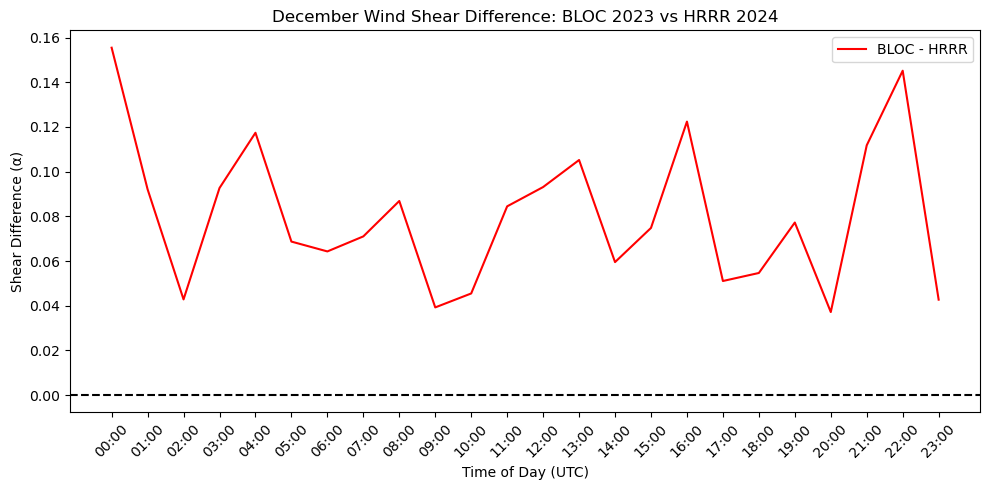

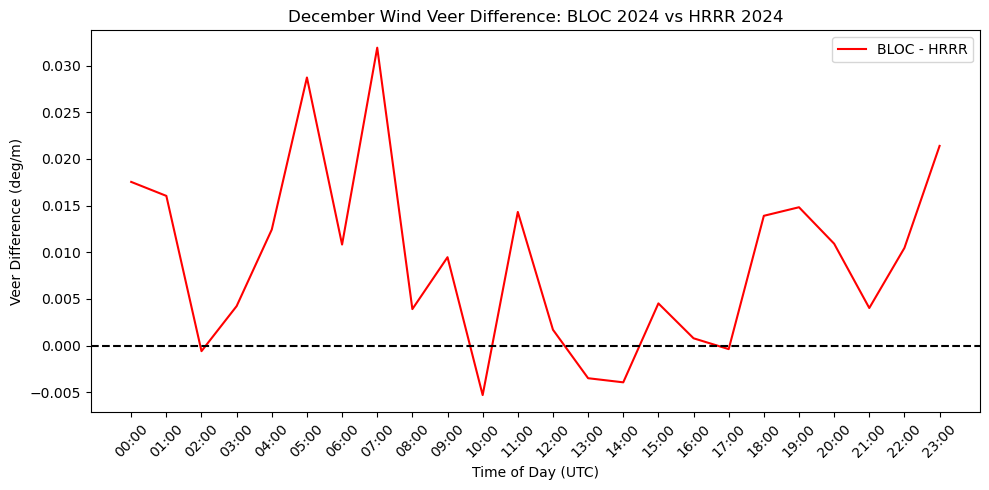

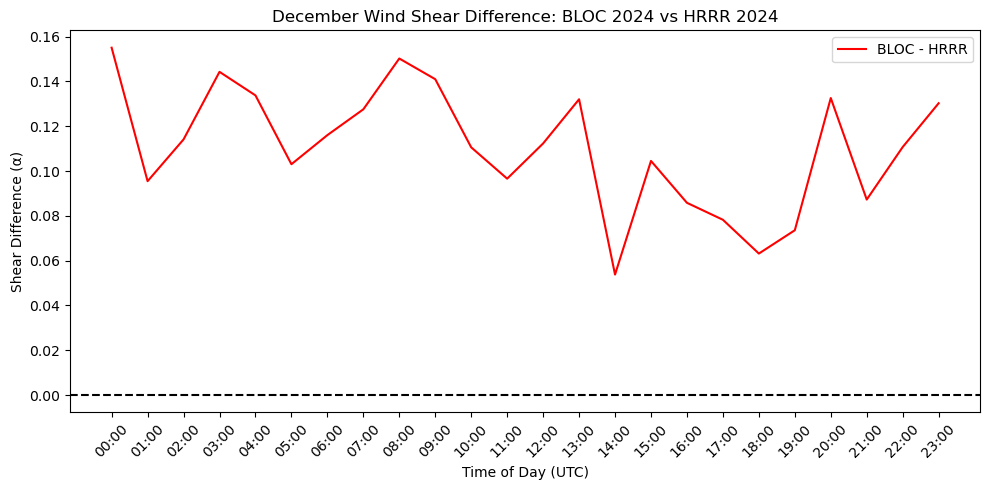

No HRRR files found for December 2025


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Directories
directory_BLOC = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_Data'
directory_HRRR = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/HRRR_Data'

# Define full months (Jan–Dec)
months_list = [
    ('January', '01'),
    ('February', '02'),
    ('March', '03'),
    ('April', '04'),
    ('May', '05'),
    ('June', '06'),
    ('July', '07'),
    ('August', '08'),
    ('September', '09'),
    ('October', '10'),
    ('November', '11'),
    ('December', '12')
]

# The HRRR model years you have loaded:
HRRR_years = [2024, 2025]

# The available BLOC years (based on your coverage)
BLOC_years = [2023, 2024, 2025]

for month_name, month_str in months_list:
    print(f"\nProcessing {month_name.upper()}")

    # First, process HRRR for each year (only 2024-2025)
    for year in HRRR_years:
        hrrr_start = f"{year}{month_str}01"
        hrrr_end = pd.to_datetime(hrrr_start).replace(day=1) + pd.offsets.MonthEnd(0)
        hrrr_end = hrrr_end.strftime('%Y%m%d')

        HRRR_files = filter_BLOC_files_by_date(directory_HRRR, hrrr_start, hrrr_end)

        if not HRRR_files:
            print(f"No HRRR files found for {month_name} {year}")
            continue

        times_HRRR, veer_HRRR = calculate_wind_veer_HRRR(HRRR_files)
        times_HRRR, shear_HRRR = calculate_wind_shear_HRRR(HRRR_files)

        HRRR_avg_veer = getDailyAvgWindVeerHRRR(times_HRRR, veer_HRRR, pd.to_datetime(hrrr_start), pd.to_datetime(hrrr_end))
        HRRR_avg_shear = getDailyAvgWindShearHRRR(times_HRRR, shear_HRRR, pd.to_datetime(hrrr_start), pd.to_datetime(hrrr_end))

        # Now collect all BLOC years for this month
        bloc_dfs_veer = []
        bloc_dfs_shear = []
        bloc_labels = []

        for bloc_year in BLOC_years:
            bloc_start = f"{bloc_year}{month_str}01"
            try:
                bloc_end = pd.to_datetime(bloc_start).replace(day=1) + pd.offsets.MonthEnd(0)
            except:
                continue  # skip if invalid date (e.g. Feb 2025 partial)

            bloc_end = bloc_end.strftime('%Y%m%d')
            BLOC_files = filter_files_by_date(directory_BLOC, bloc_start, bloc_end)

            if not BLOC_files:
                continue

            times_BLOC, veer_BLOC = calculate_wind_veer(BLOC_files)
            times_BLOC, shear_BLOC = calculate_wind_shear_with_alpha(BLOC_files)

            bloc_avg_veer = getDailyAvgWindVeer(times_BLOC, veer_BLOC, pd.to_datetime(bloc_start), pd.to_datetime(bloc_end))
            bloc_avg_shear = getDailyAvgWindShear(times_BLOC, shear_BLOC, pd.to_datetime(bloc_start), pd.to_datetime(bloc_end))

            bloc_dfs_veer.append(bloc_avg_veer)
            bloc_dfs_shear.append(bloc_avg_shear)
            bloc_labels.append(f"BLOC {bloc_year}")

        ### Plot Veer
        combined_veer_dfs = bloc_dfs_veer + [HRRR_avg_veer]
        combined_veer_labels = bloc_labels + [f'HRRR {year}']

        plotMultipleDataFrames(
            combined_veer_dfs,
            labels=combined_veer_labels,
            title=f"{month_name} Wind Veer Comparison",
            ylabel="Average Wind Veer (deg/m)"
        )

        ### Plot Shear
        combined_shear_dfs = bloc_dfs_shear + [HRRR_avg_shear]
        combined_shear_labels = bloc_labels + [f'HRRR {year}']

        plotMultipleDataFrames(
            combined_shear_dfs,
            labels=combined_shear_labels,
            title=f"{month_name} Wind Shear Comparison",
            ylabel="Average Wind Shear (α)"
        )

        ### Differences (BLOC - HRRR) for each BLOC year
        for bloc_df_veer, bloc_df_shear, bloc_label in zip(bloc_dfs_veer, bloc_dfs_shear, bloc_labels):
            # Veer difference
            merged_veer = pd.merge(HRRR_avg_veer, bloc_df_veer, on='time_of_day', suffixes=('_hrrr','_bloc'))
            diff_veer = merged_veer['average_wind_veer_bloc'] - merged_veer['average_wind_veer_hrrr']

            plt.figure(figsize=(10, 5))
            plt.plot(merged_veer['time_of_day'], diff_veer, color='red', label='BLOC - HRRR')
            plt.title(f"{month_name} Wind Veer Difference: {bloc_label} vs HRRR {year}")
            plt.xlabel("Time of Day (UTC)")
            plt.ylabel("Veer Difference (deg/m)")
            plt.axhline(0, linestyle='--', color='black')
            plt.xticks(rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Shear difference
            merged_shear = pd.merge(HRRR_avg_shear, bloc_df_shear, on='time_of_day', suffixes=('_hrrr','_bloc'))
            diff_shear = merged_shear['average_wind_shear_bloc'] - merged_shear['average_wind_shear_hrrr']

            plt.figure(figsize=(10, 5))
            plt.plot(merged_shear['time_of_day'], diff_shear, color='red', label='BLOC - HRRR')
            plt.title(f"{month_name} Wind Shear Difference: {bloc_label} vs HRRR {year}")
            plt.xlabel("Time of Day (UTC)")
            plt.ylabel("Shear Difference (α)")
            plt.axhline(0, linestyle='--', color='black')
            plt.xticks(rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()


Processing JANUARY
No HRRR files found for January 2024
Start Date:  None
End Date:  None
Start Date:  None
End Date:  None


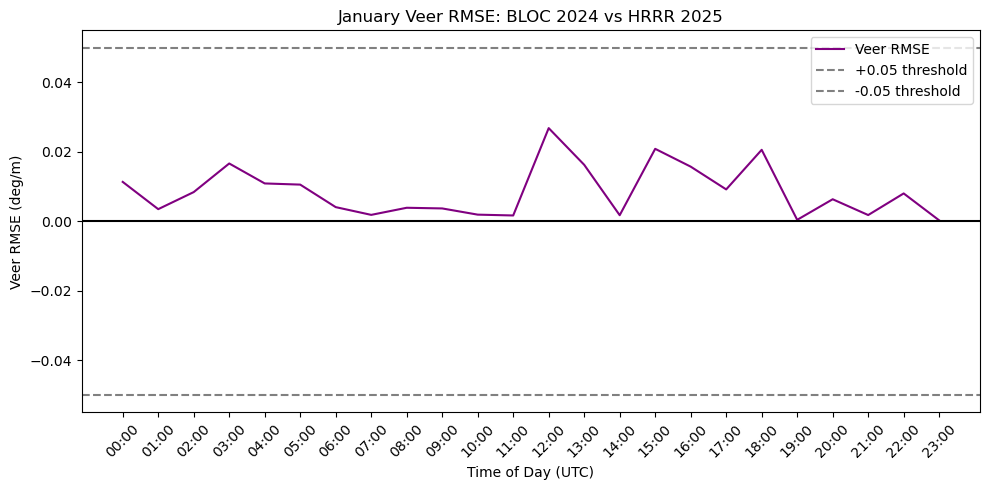

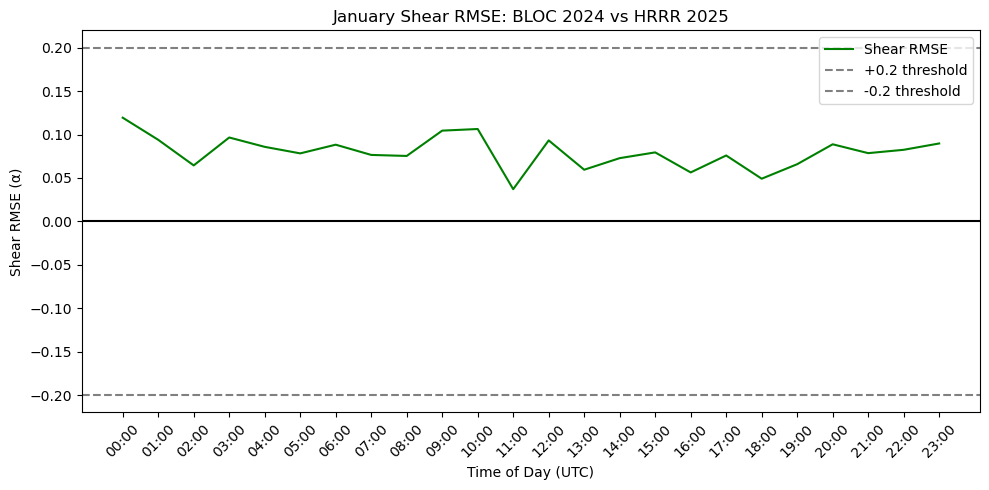

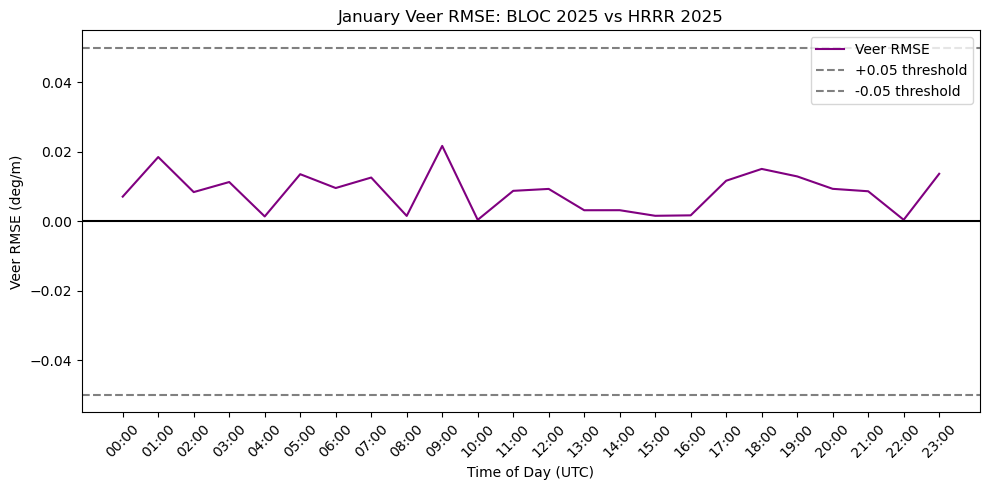

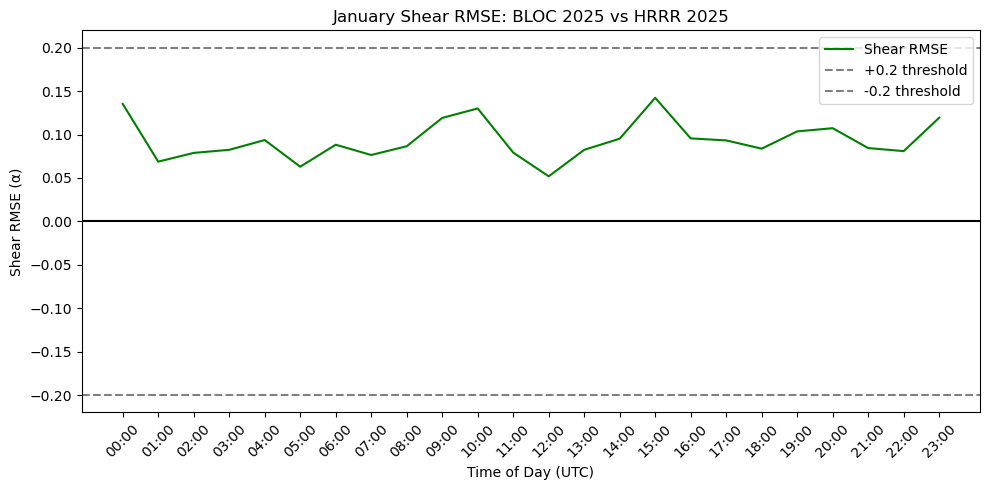


Processing FEBRUARY
No HRRR files found for February 2024
Start Date:  None
End Date:  None


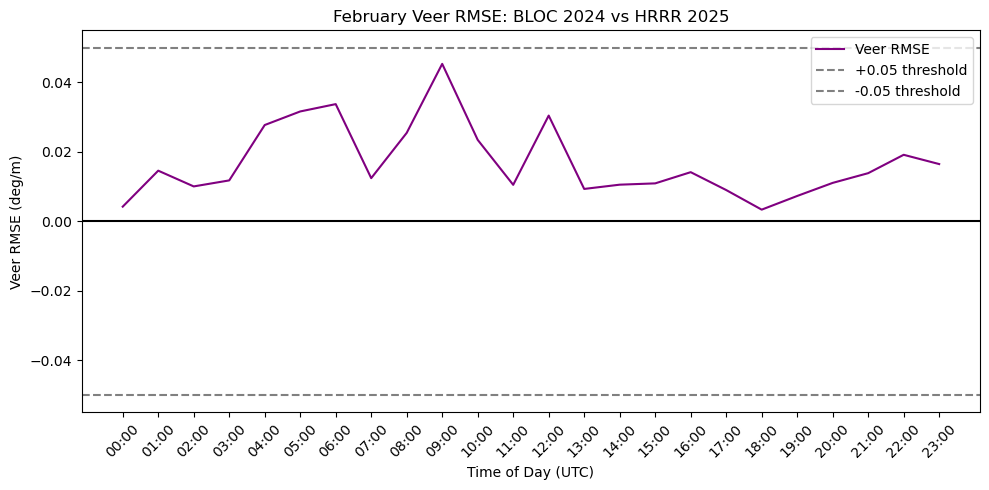

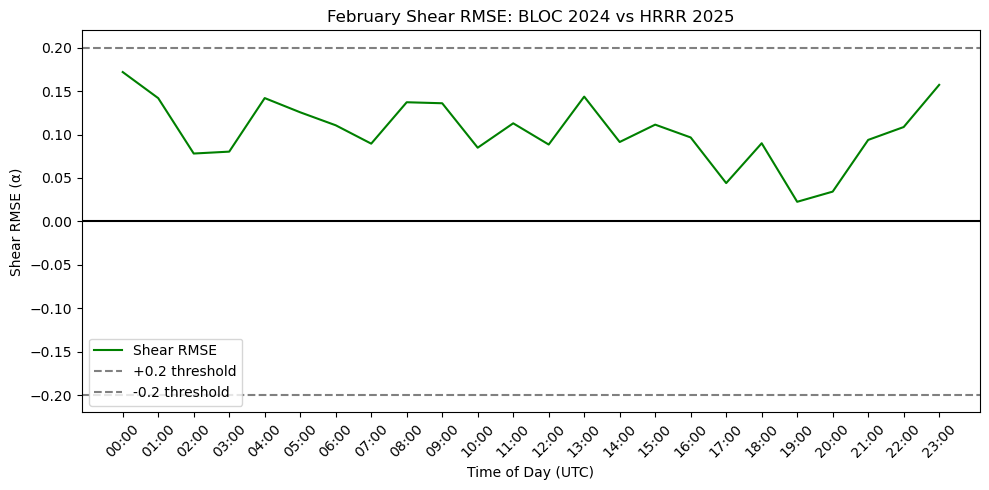


Processing MARCH
No HRRR files found for March 2024
Start Date:  None
End Date:  None


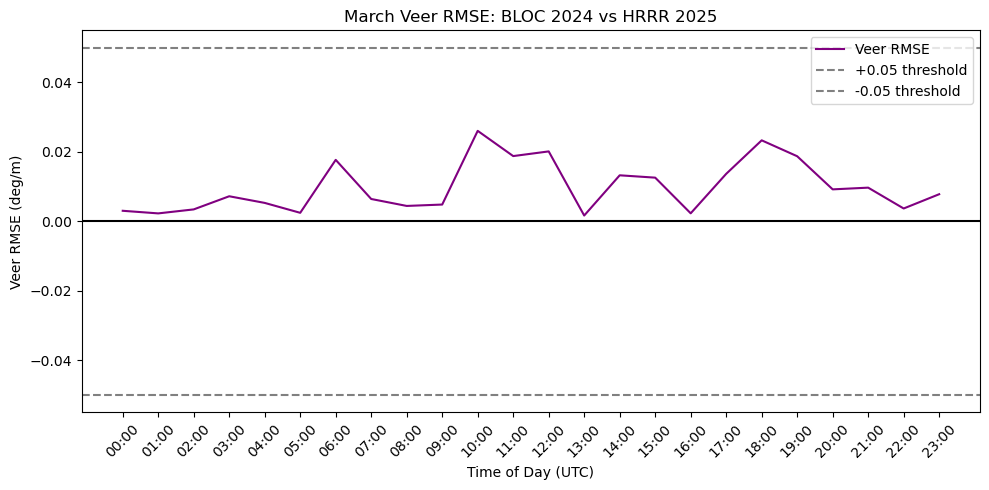

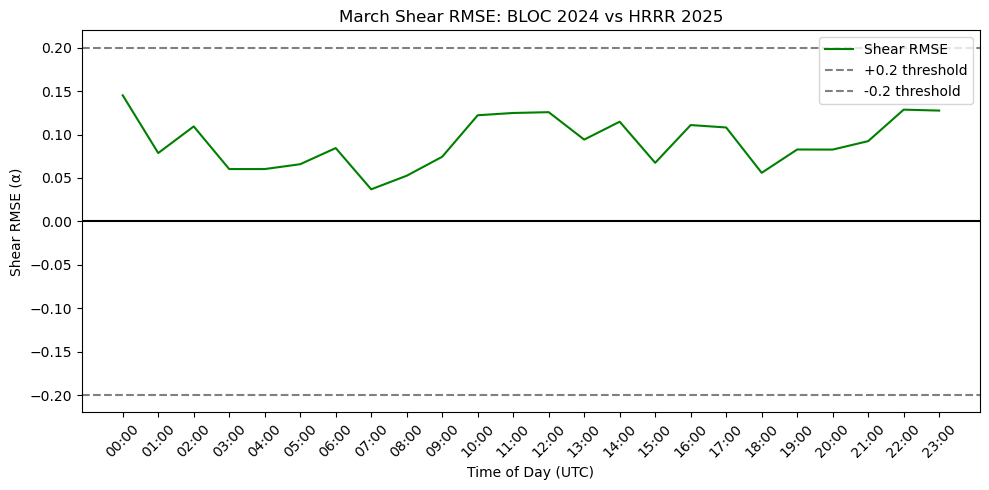


Processing APRIL
No HRRR files found for April 2024
Start Date:  None
End Date:  None


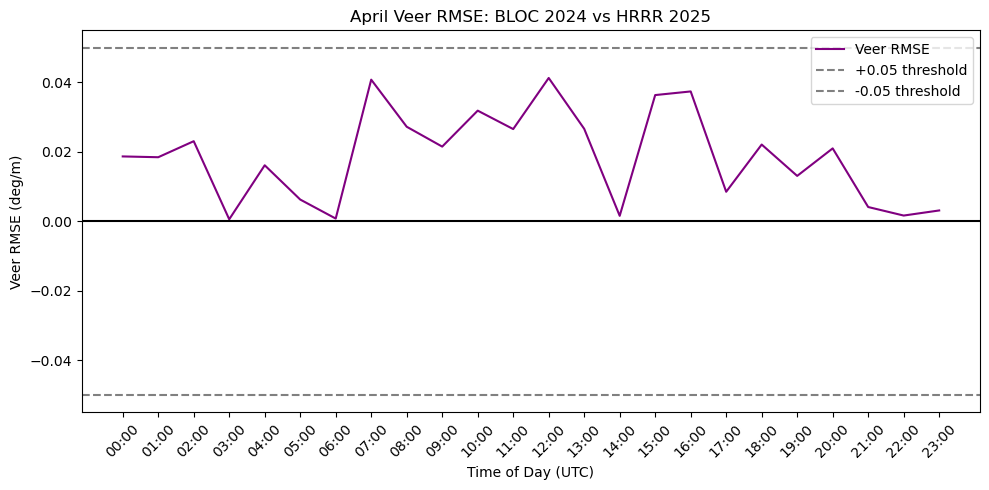

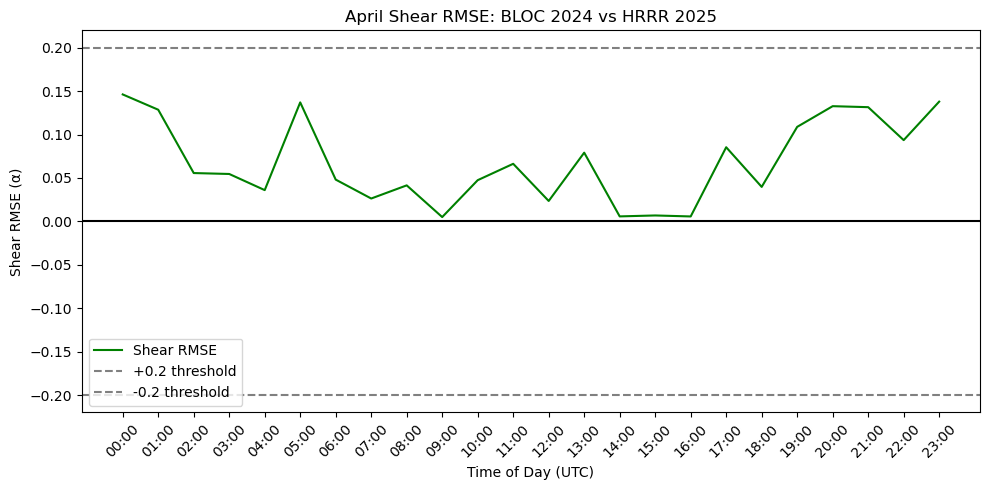


Processing MAY
No HRRR files found for May 2024
Start Date:  None
End Date:  None


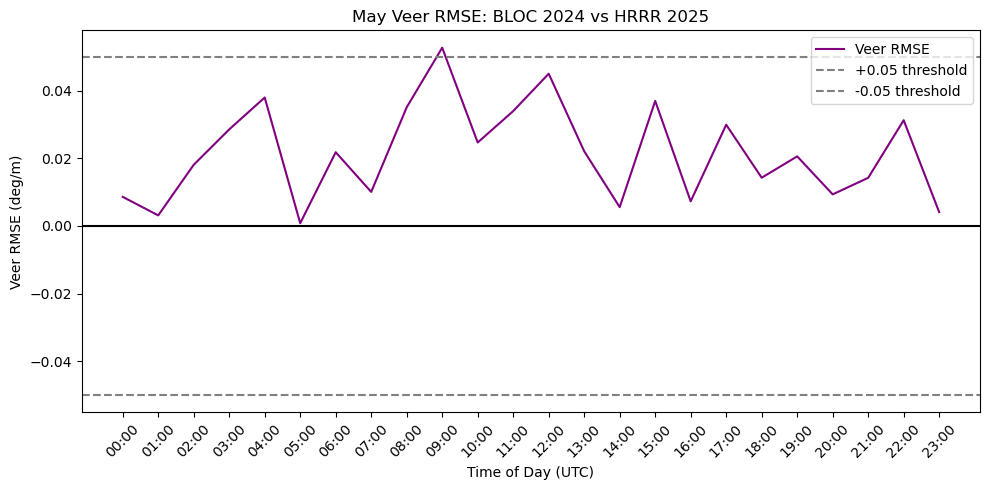

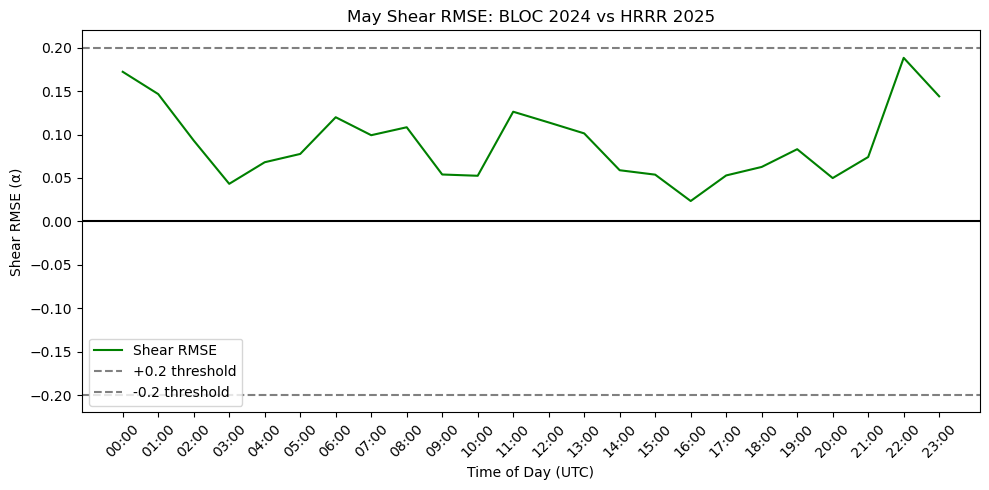


Processing JUNE
No HRRR files found for June 2024
Start Date:  None
End Date:  None


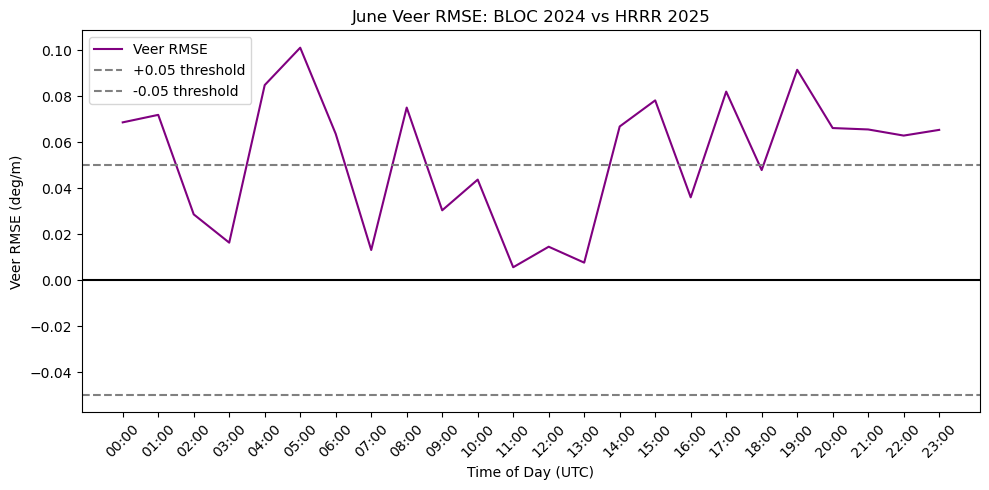

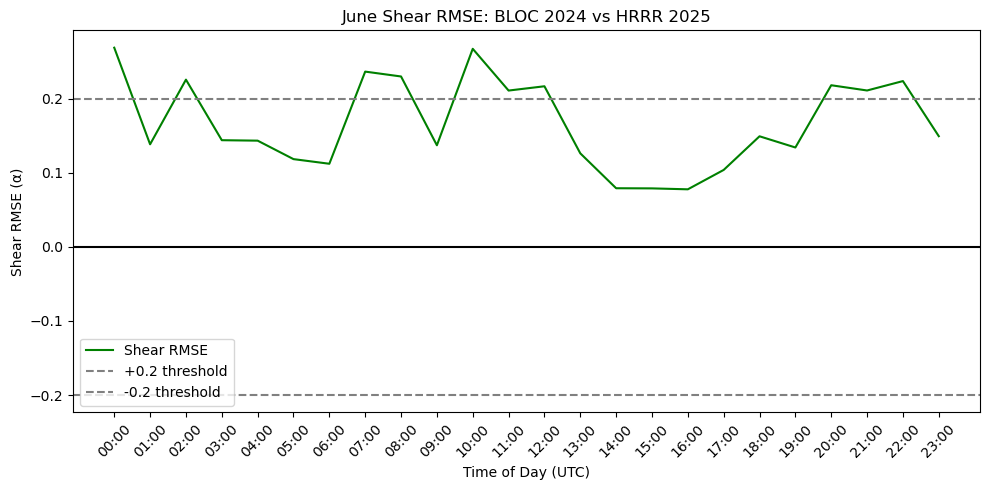


Processing JULY
No HRRR files found for July 2024
No HRRR files found for July 2025

Processing AUGUST
Start Date:  None
End Date:  None


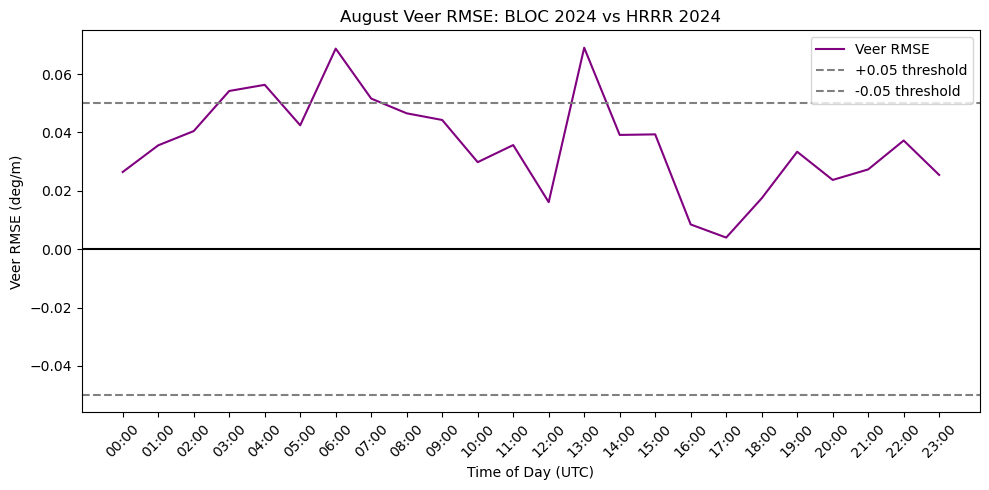

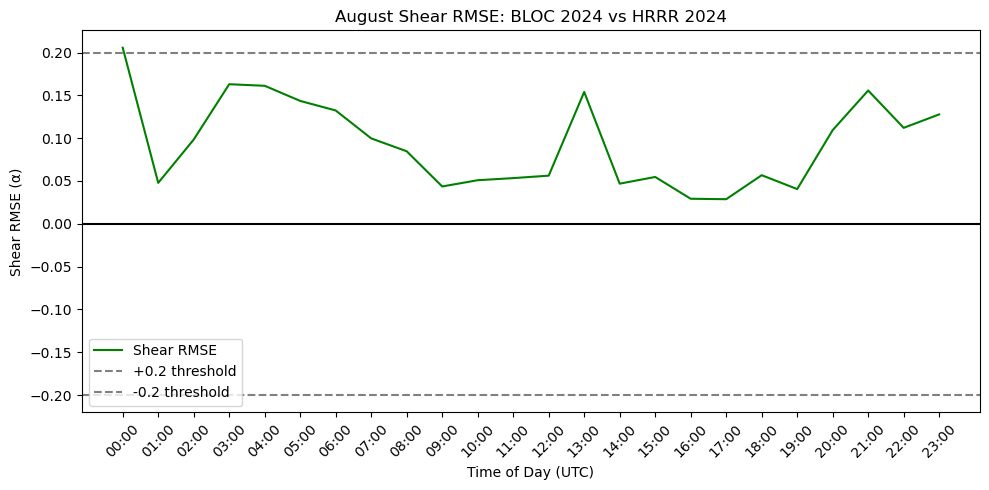

No HRRR files found for August 2025

Processing SEPTEMBER
Start Date:  None
End Date:  None


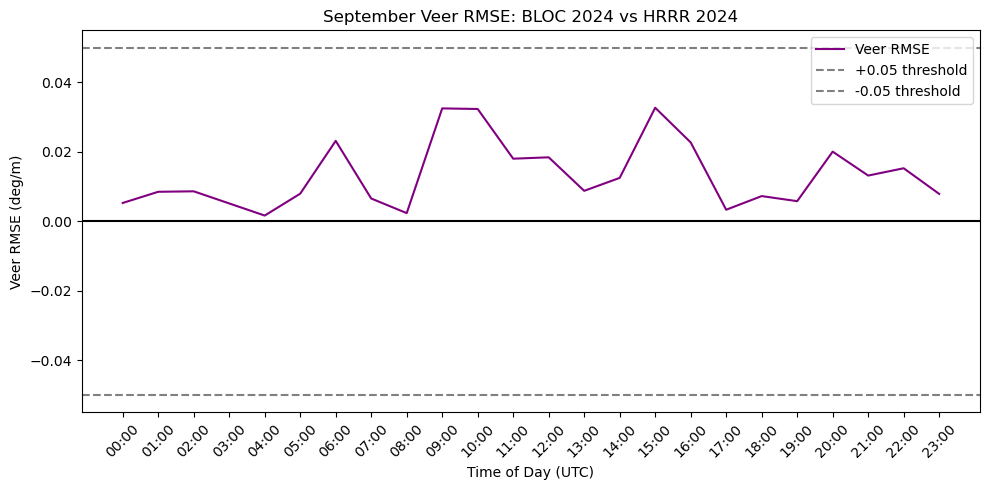

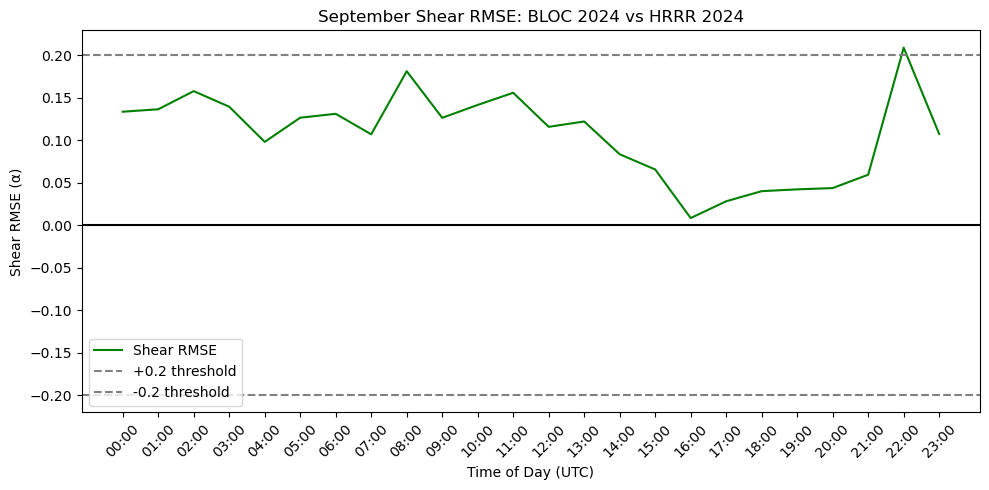

No HRRR files found for September 2025

Processing OCTOBER
Start Date:  None
End Date:  None


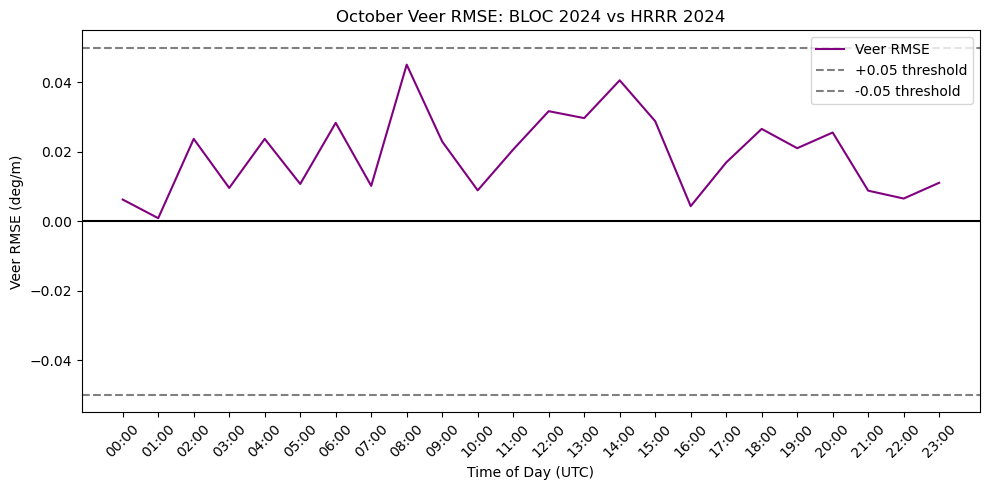

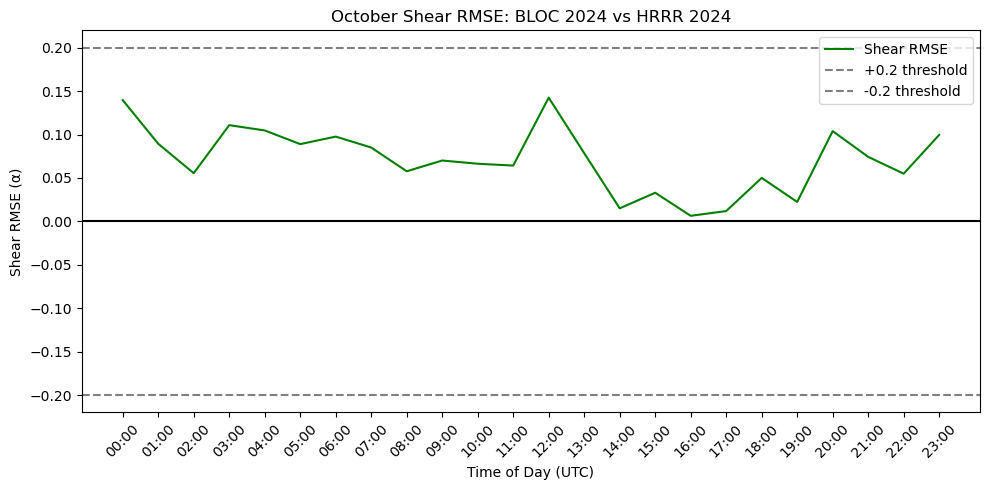

No HRRR files found for October 2025

Processing NOVEMBER
Start Date:  None
End Date:  None


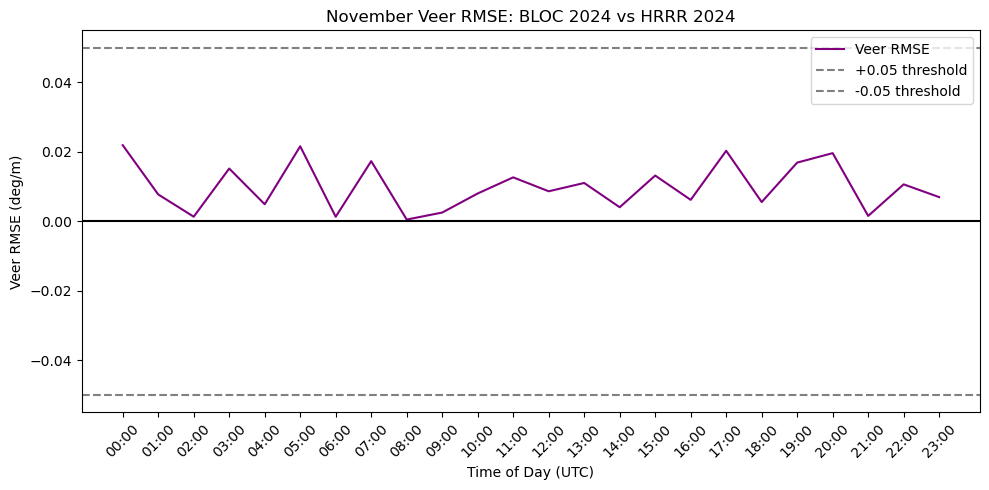

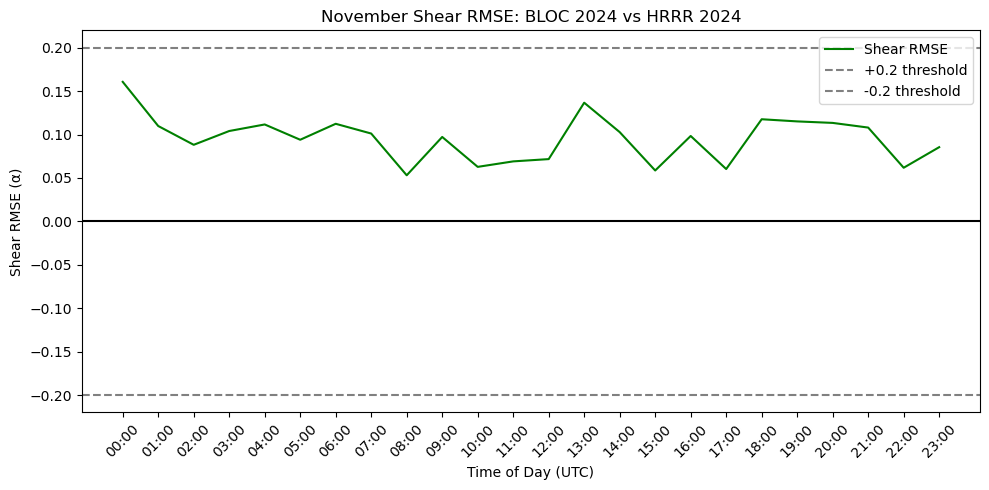

No HRRR files found for November 2025

Processing DECEMBER
Start Date:  None
End Date:  None
Start Date:  None
End Date:  None


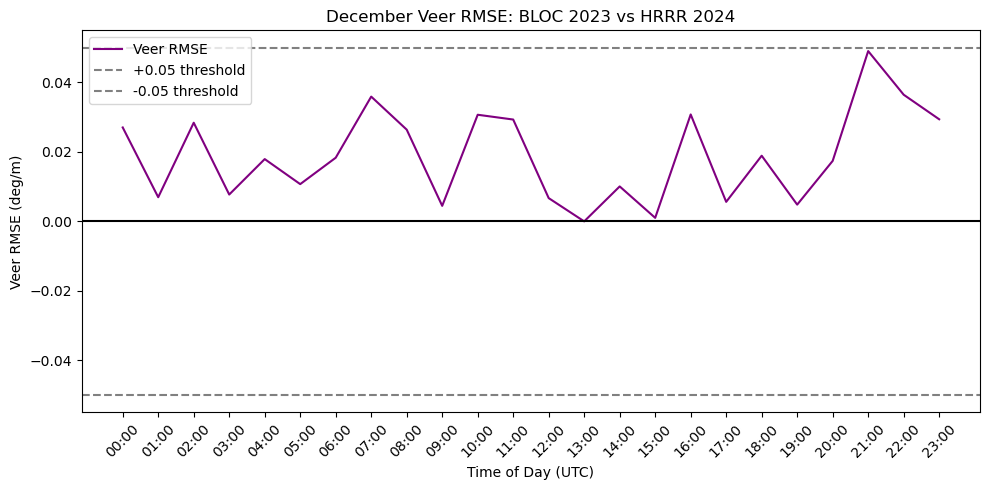

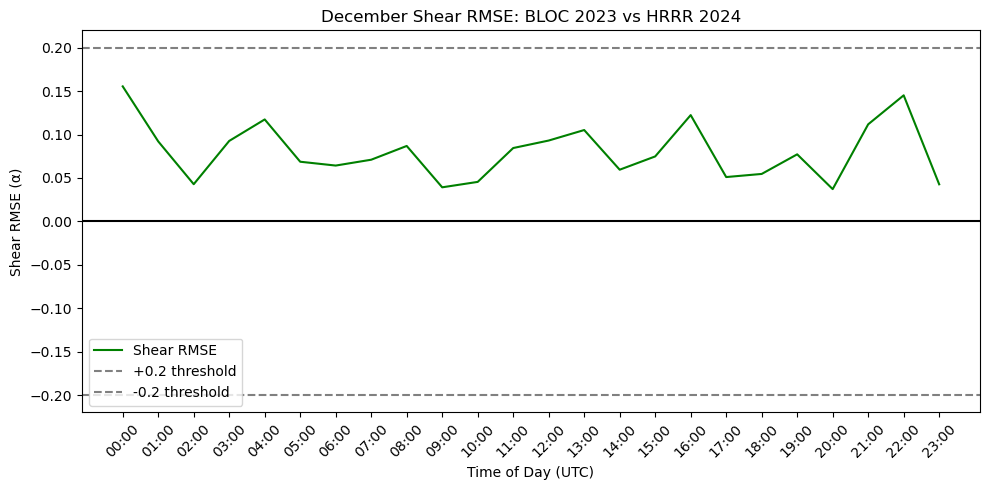

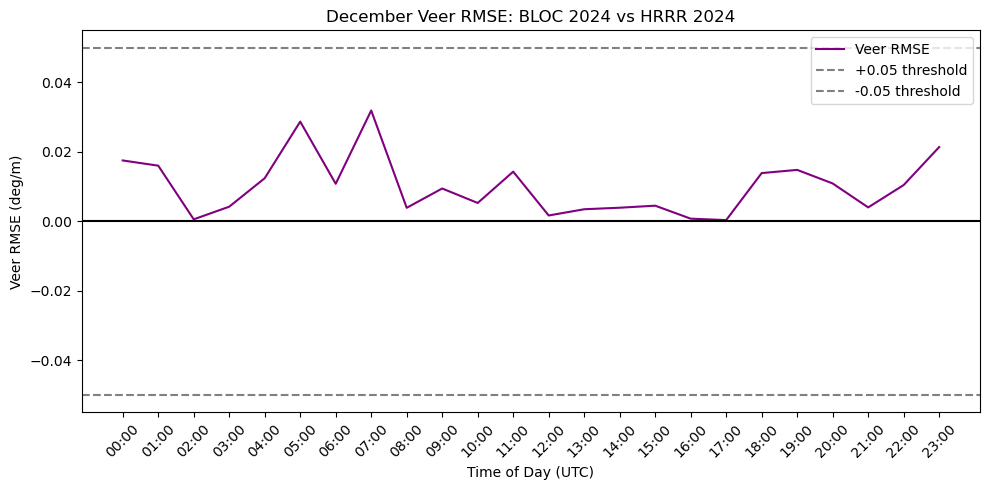

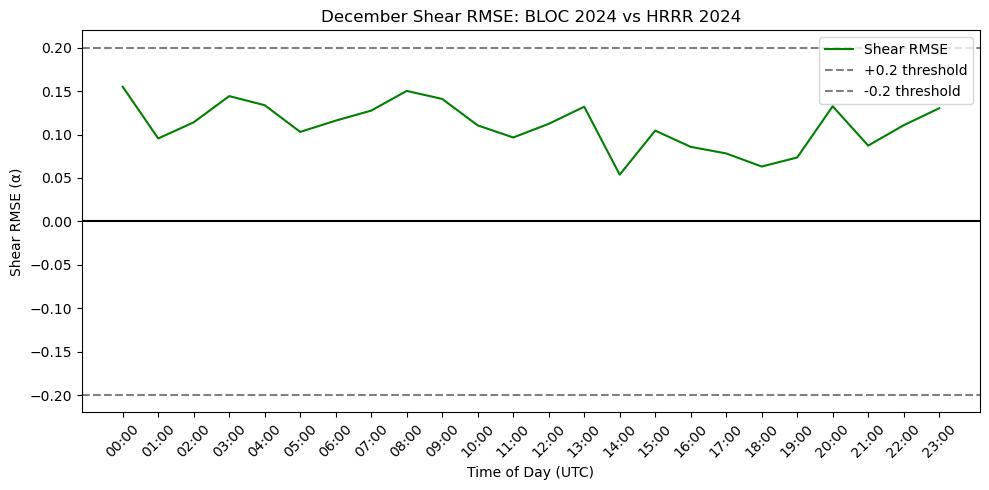

No HRRR files found for December 2025


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Directories
directory_BLOC = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_Data'
directory_HRRR = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/HRRR_Data'

# Define full months (Jan–Dec)
months_list = [
    ('January', '01'),
    ('February', '02'),
    ('March', '03'),
    ('April', '04'),
    ('May', '05'),
    ('June', '06'),
    ('July', '07'),
    ('August', '08'),
    ('September', '09'),
    ('October', '10'),
    ('November', '11'),
    ('December', '12')
]

# The HRRR model years you have loaded:
HRRR_years = [2024, 2025]
BLOC_years = [2023, 2024, 2025]

for month_name, month_str in months_list:
    print(f"\nProcessing {month_name.upper()}")

    for year in HRRR_years:
        hrrr_start = f"{year}{month_str}01"
        hrrr_end = pd.to_datetime(hrrr_start).replace(day=1) + pd.offsets.MonthEnd(0)
        hrrr_end = hrrr_end.strftime('%Y%m%d')

        HRRR_files = filter_BLOC_files_by_date(directory_HRRR, hrrr_start, hrrr_end)

        if not HRRR_files:
            print(f"No HRRR files found for {month_name} {year}")
            continue

        times_HRRR, veer_HRRR = calculate_wind_veer_HRRR(HRRR_files)
        times_HRRR, shear_HRRR = calculate_wind_shear_HRRR(HRRR_files)

        HRRR_avg_veer = getDailyAvgWindVeerHRRR(times_HRRR, veer_HRRR, pd.to_datetime(hrrr_start), pd.to_datetime(hrrr_end))
        HRRR_avg_shear = getDailyAvgWindShearHRRR(times_HRRR, shear_HRRR, pd.to_datetime(hrrr_start), pd.to_datetime(hrrr_end))

        bloc_dfs_veer = []
        bloc_dfs_shear = []
        bloc_labels = []

        for bloc_year in BLOC_years:
            bloc_start = f"{bloc_year}{month_str}01"
            try:
                bloc_end = pd.to_datetime(bloc_start).replace(day=1) + pd.offsets.MonthEnd(0)
            except:
                continue

            bloc_end = bloc_end.strftime('%Y%m%d')
            BLOC_files = filter_files_by_date(directory_BLOC, bloc_start, bloc_end)

            if not BLOC_files:
                continue

            times_BLOC, veer_BLOC = calculate_wind_veer(BLOC_files)
            times_BLOC, shear_BLOC = calculate_wind_shear_with_alpha(BLOC_files)

            bloc_avg_veer = getDailyAvgWindVeer(times_BLOC, veer_BLOC, pd.to_datetime(bloc_start), pd.to_datetime(bloc_end))
            bloc_avg_shear = getDailyAvgWindShear(times_BLOC, shear_BLOC, pd.to_datetime(bloc_start), pd.to_datetime(bloc_end))

            bloc_dfs_veer.append(bloc_avg_veer)
            bloc_dfs_shear.append(bloc_avg_shear)
            bloc_labels.append(f"BLOC {bloc_year}")

        ### Plot Veer RMSE for each BLOC year
        for bloc_df_veer, bloc_df_shear, bloc_label in zip(bloc_dfs_veer, bloc_dfs_shear, bloc_labels):
            merged_veer = pd.merge(HRRR_avg_veer, bloc_df_veer, on='time_of_day', suffixes=('_hrrr','_bloc'))
            rmse_veer = np.abs(merged_veer['average_wind_veer_bloc'] - merged_veer['average_wind_veer_hrrr'])

            plt.figure(figsize=(10, 5))
            plt.plot(merged_veer['time_of_day'], rmse_veer, color='purple', label='Veer RMSE')
            plt.title(f"{month_name} Veer RMSE: {bloc_label} vs HRRR {year}")
            plt.xlabel("Time of Day (UTC)")
            plt.ylabel("Veer RMSE (deg/m)")
            
            plt.axhline(0, color='black')

            # Add significance thresholds for shear
            plt.axhline(0.05, linestyle='--', color='gray', label='+0.05 threshold')
            plt.axhline(-0.05, linestyle='--', color='gray', label='-0.05 threshold')
            
            plt.xticks(rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()

            ### Same for Shear RMSE
            merged_shear = pd.merge(HRRR_avg_shear, bloc_df_shear, on='time_of_day', suffixes=('_hrrr','_bloc'))
            rmse_shear = np.abs(merged_shear['average_wind_shear_bloc'] - merged_shear['average_wind_shear_hrrr'])

            plt.figure(figsize=(10, 5))
            plt.plot(merged_shear['time_of_day'], rmse_shear, color='green', label='Shear RMSE')
            plt.title(f"{month_name} Shear RMSE: {bloc_label} vs HRRR {year}")
            plt.xlabel("Time of Day (UTC)")
            plt.ylabel("Shear RMSE (α)")
            plt.axhline(0, color='black')

            # Add significance thresholds for shear
            plt.axhline(0.2, linestyle='--', color='gray', label='+0.2 threshold')
            plt.axhline(-0.2, linestyle='--', color='gray', label='-0.2 threshold')

            plt.xticks(rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()



Processing JANUARY
No HRRR files found for January 2024
Start Date:  None
End Date:  None
Start Date:  None
End Date:  None


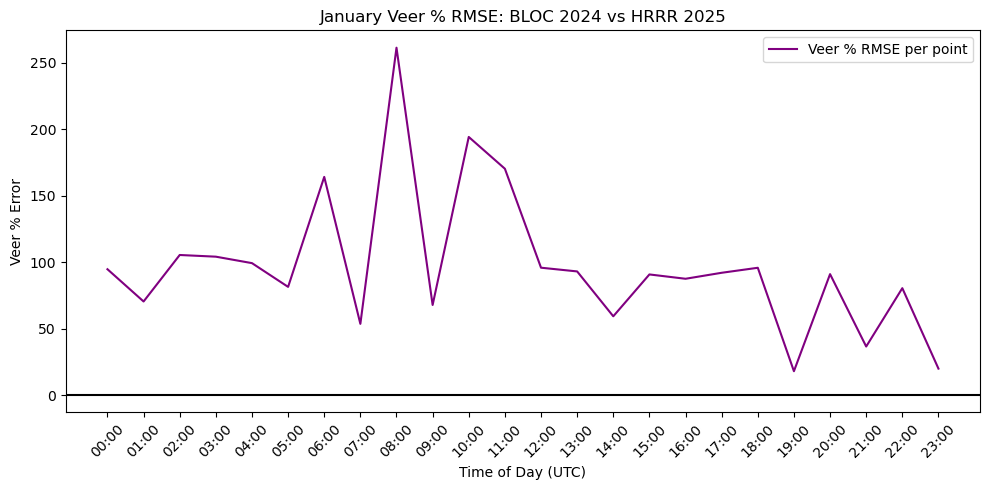

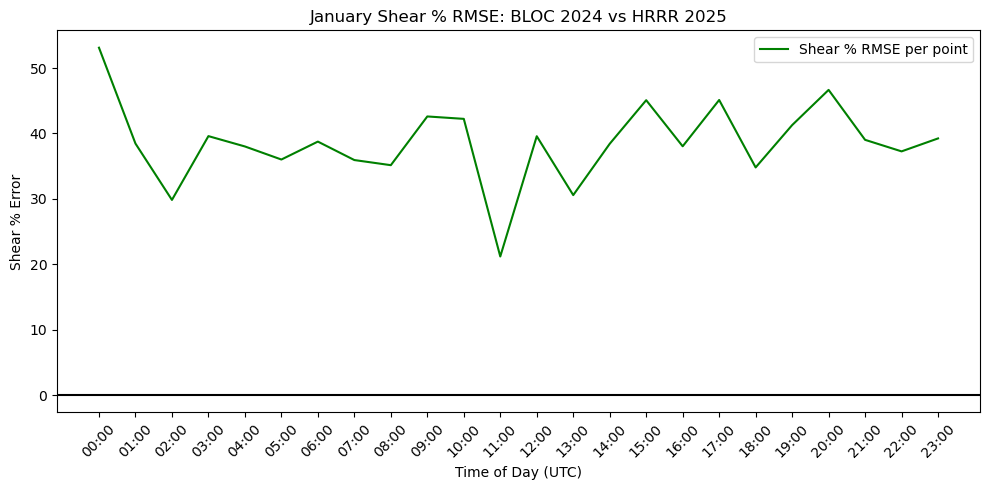

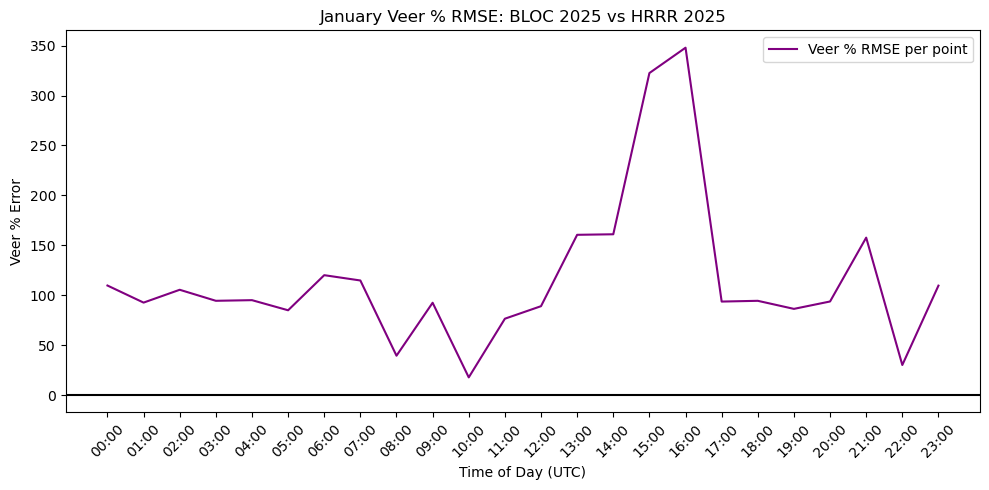

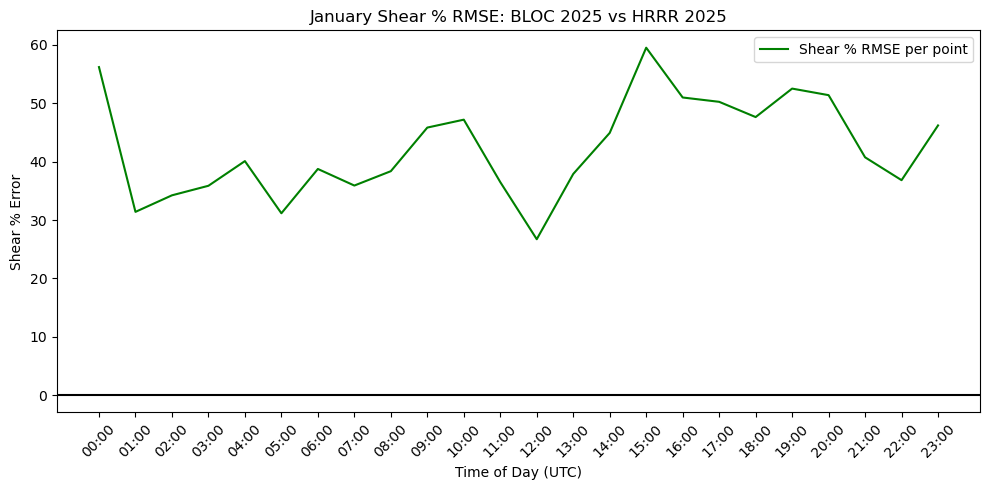


Processing FEBRUARY
No HRRR files found for February 2024
Start Date:  None
End Date:  None


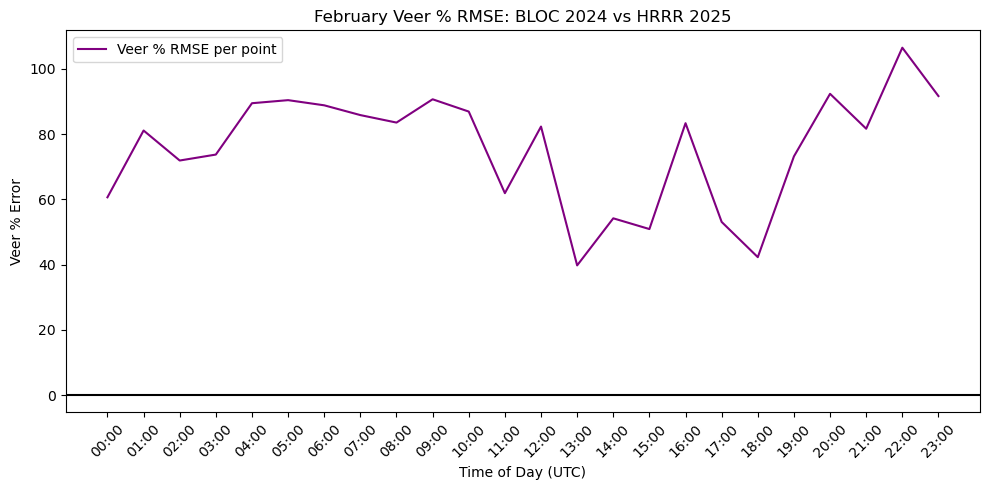

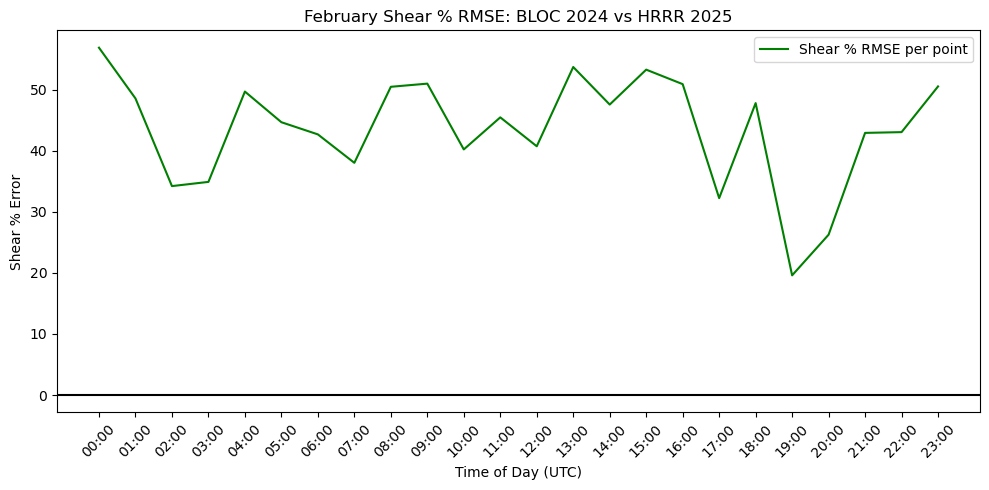


Processing MARCH
No HRRR files found for March 2024
Start Date:  None
End Date:  None


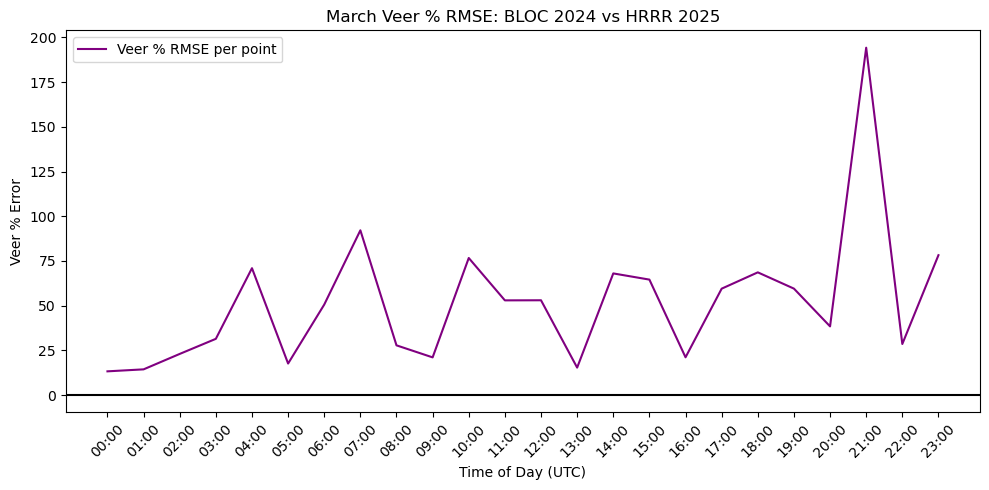

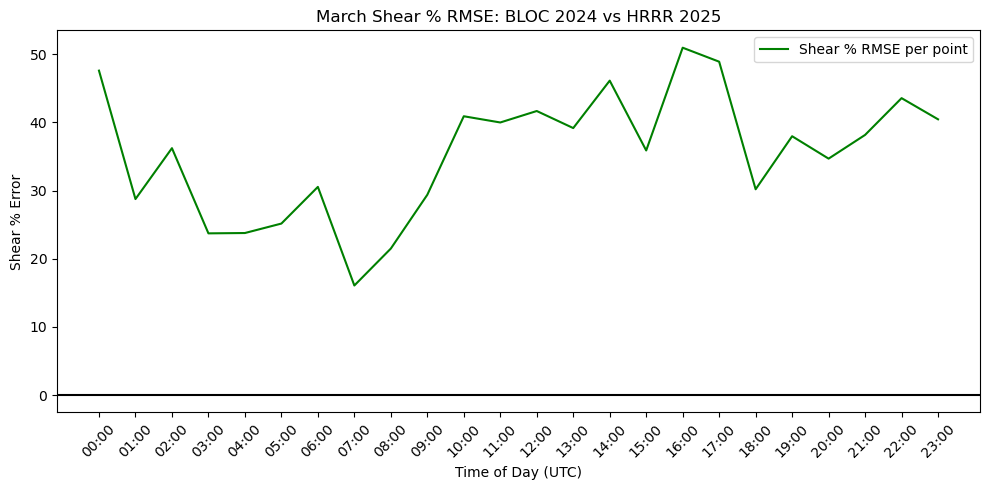


Processing APRIL
No HRRR files found for April 2024
Start Date:  None
End Date:  None


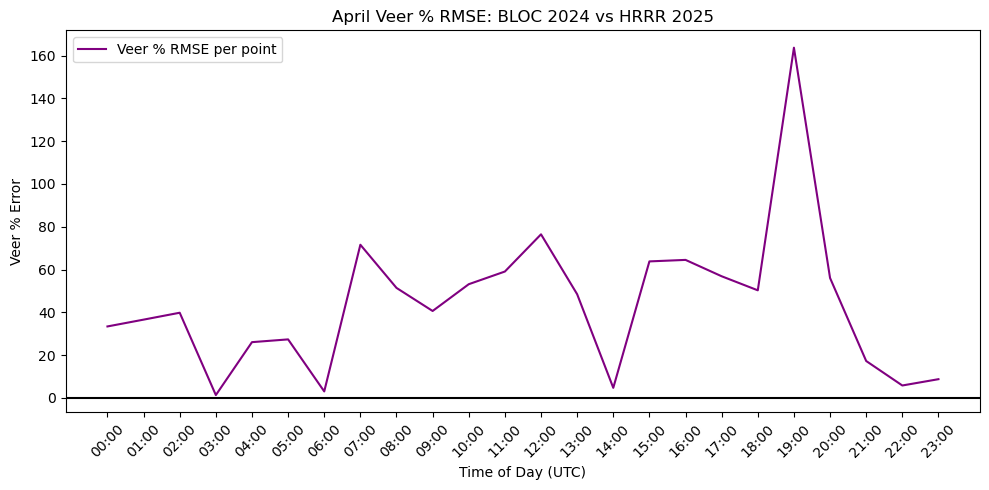

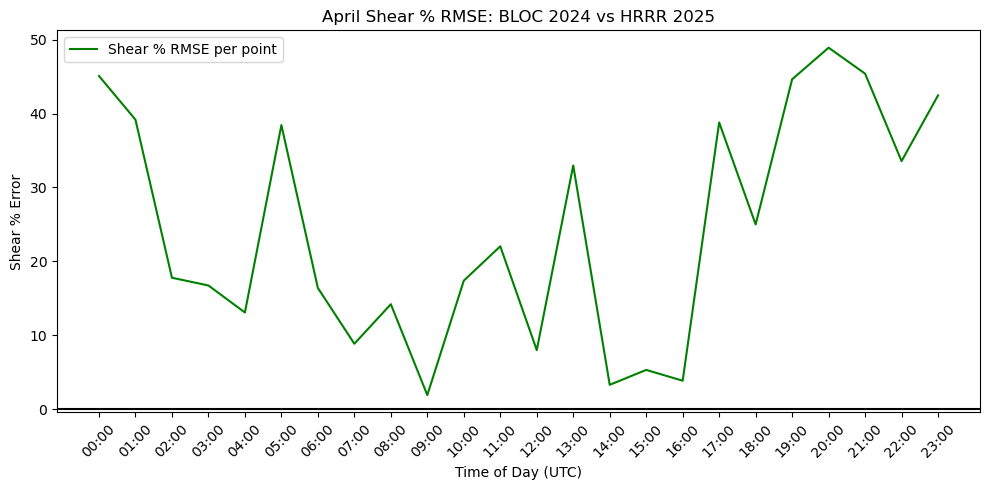


Processing MAY
No HRRR files found for May 2024
Start Date:  None
End Date:  None


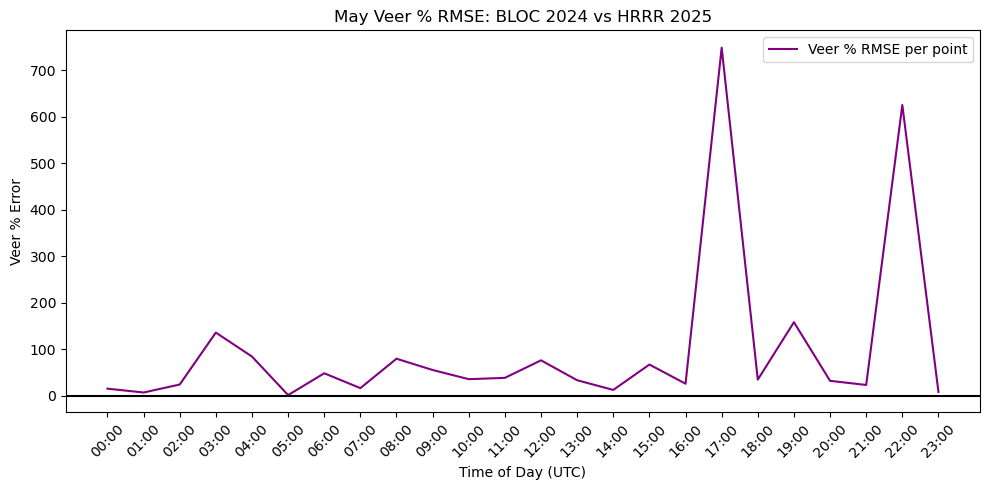

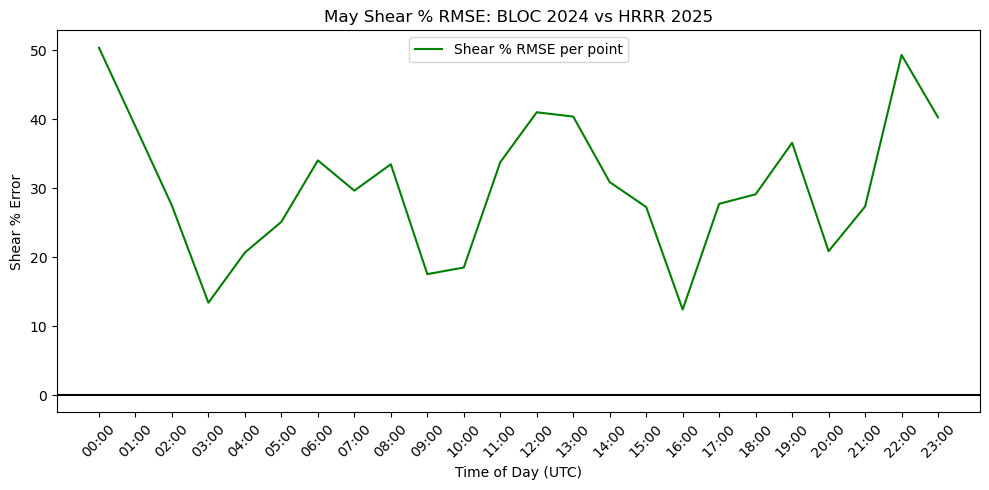


Processing JUNE
No HRRR files found for June 2024
Start Date:  None
End Date:  None


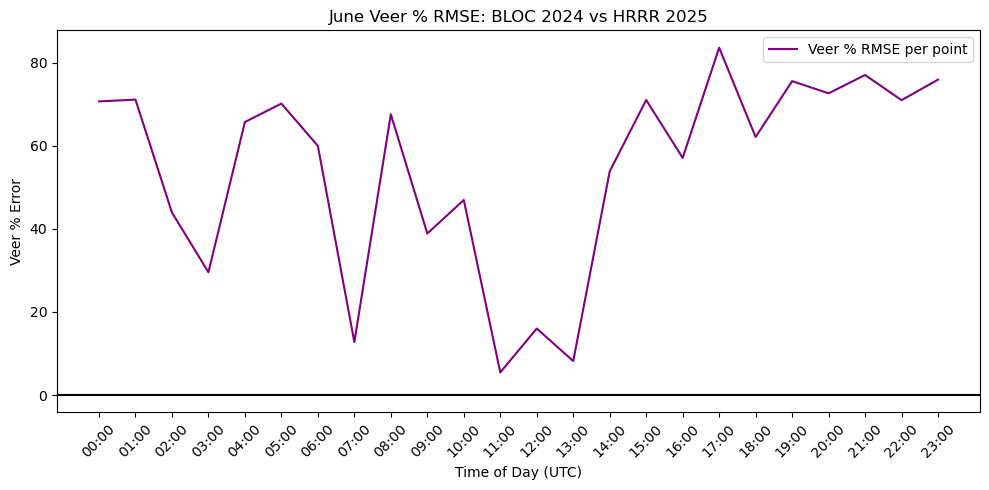

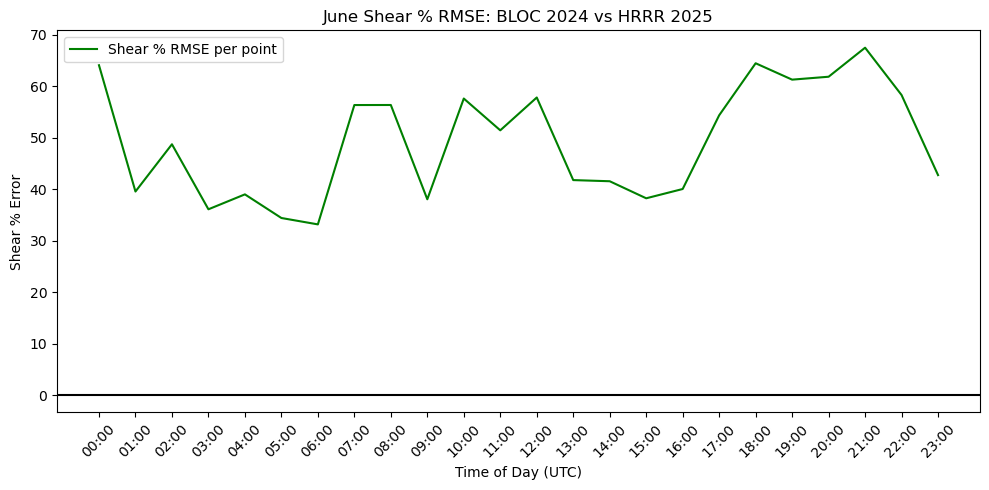


Processing JULY
No HRRR files found for July 2024
No HRRR files found for July 2025

Processing AUGUST
Start Date:  None
End Date:  None


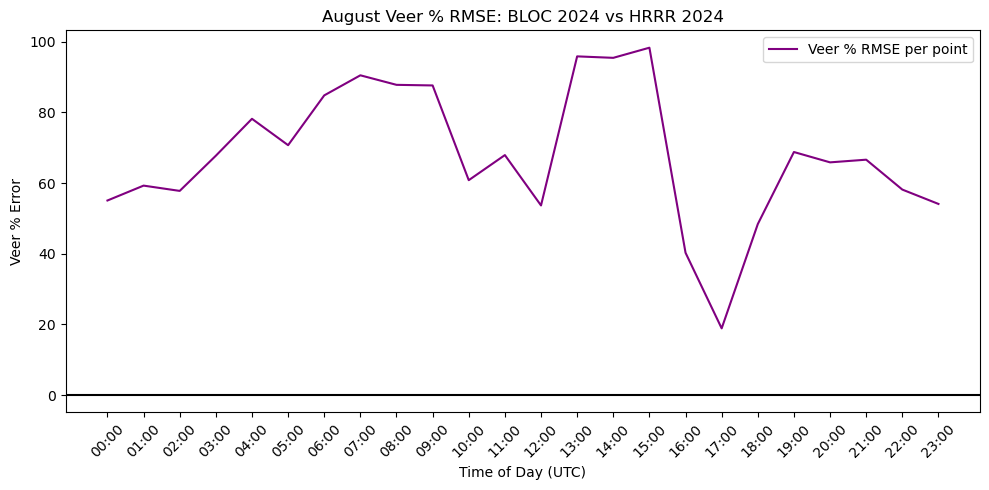

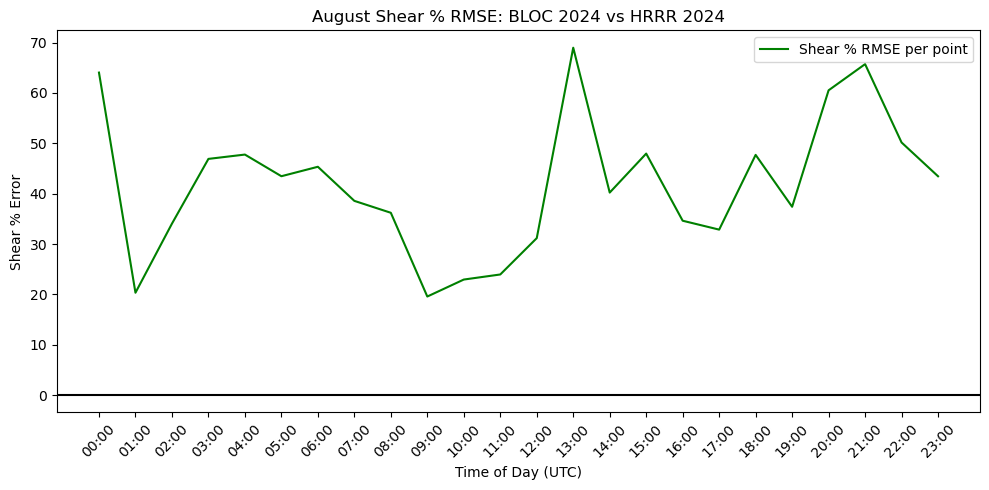

No HRRR files found for August 2025

Processing SEPTEMBER
Start Date:  None
End Date:  None


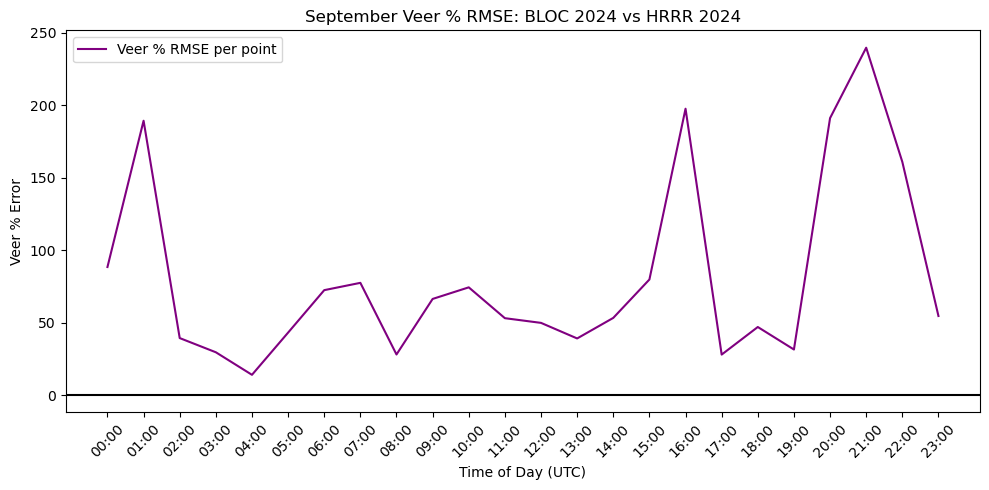

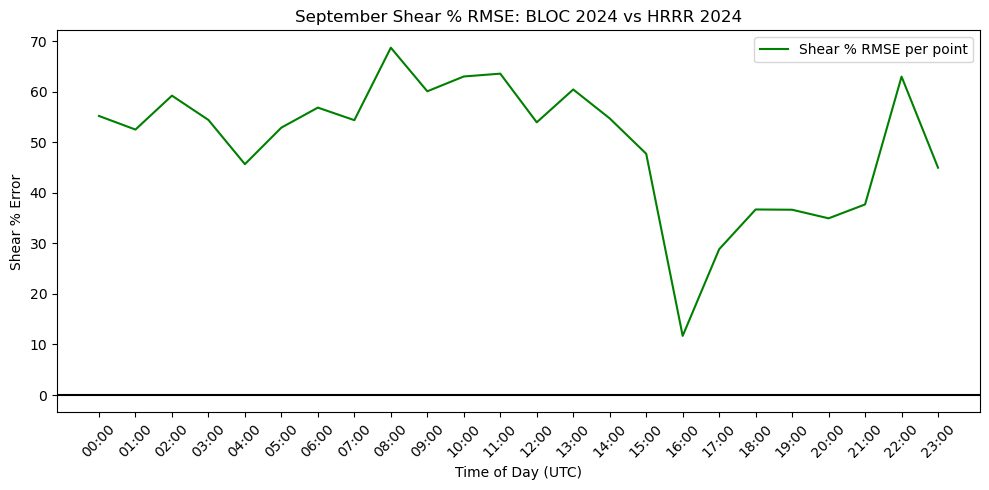

No HRRR files found for September 2025

Processing OCTOBER
Start Date:  None
End Date:  None


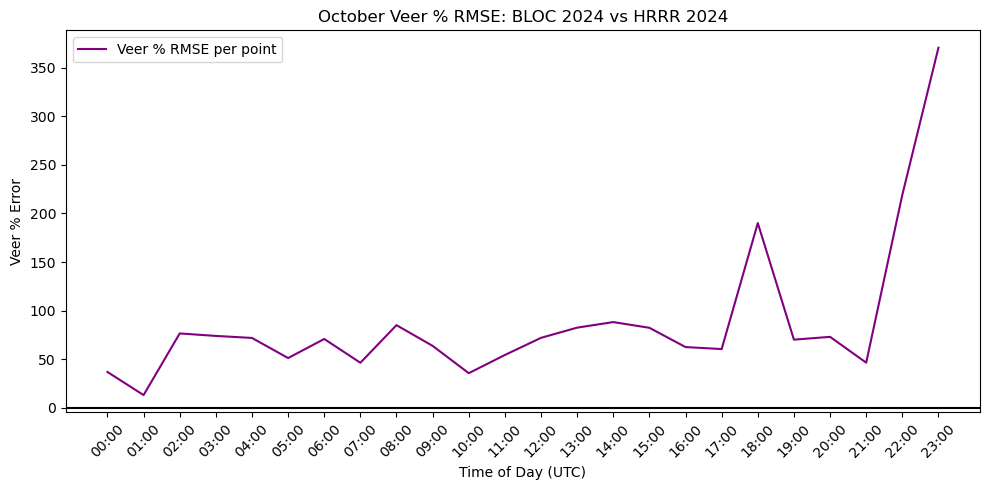

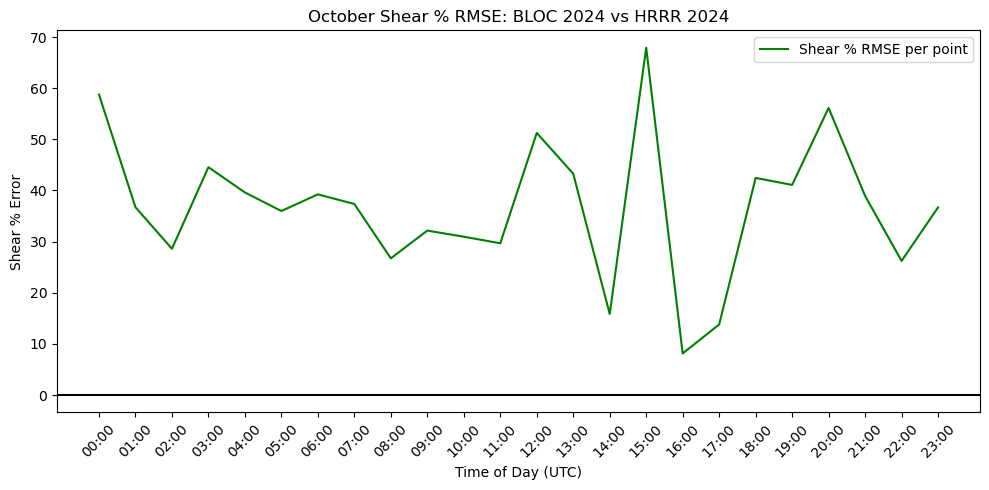

No HRRR files found for October 2025

Processing NOVEMBER
Start Date:  None
End Date:  None


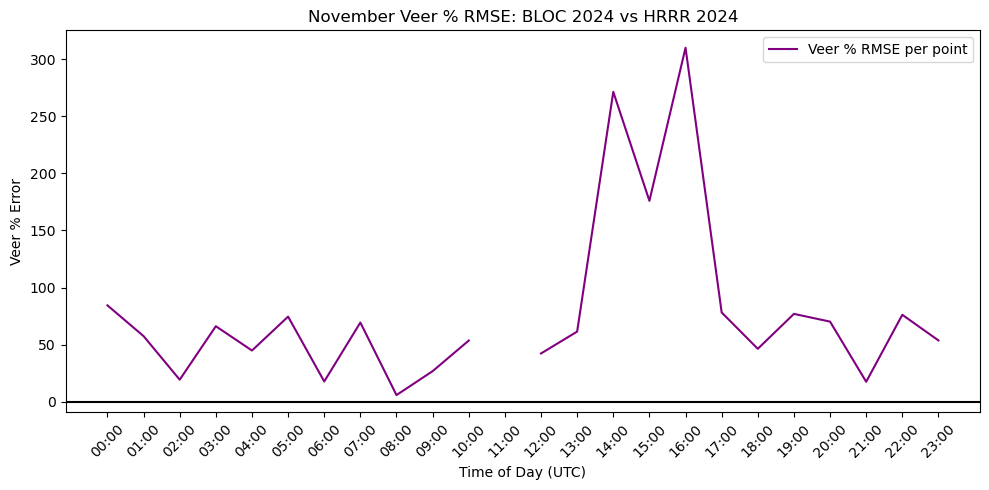

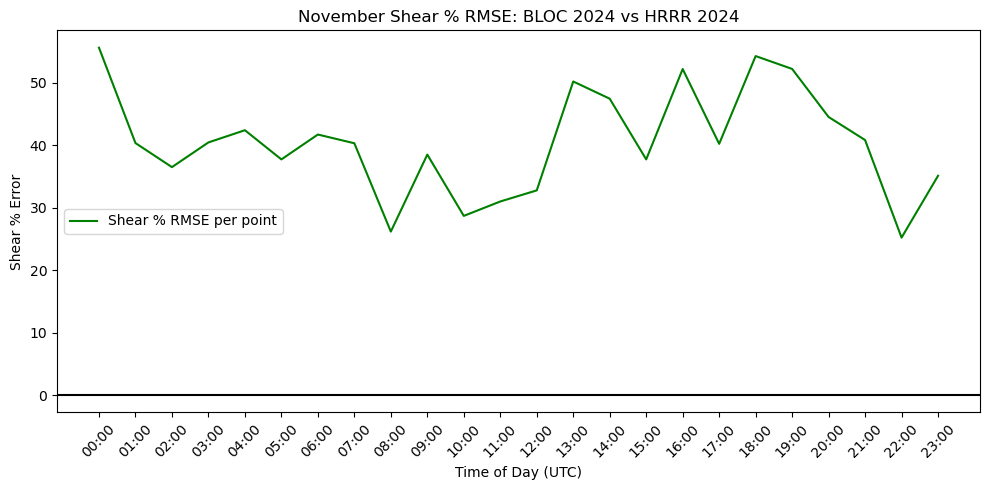

No HRRR files found for November 2025

Processing DECEMBER
Start Date:  None
End Date:  None
Start Date:  None
End Date:  None


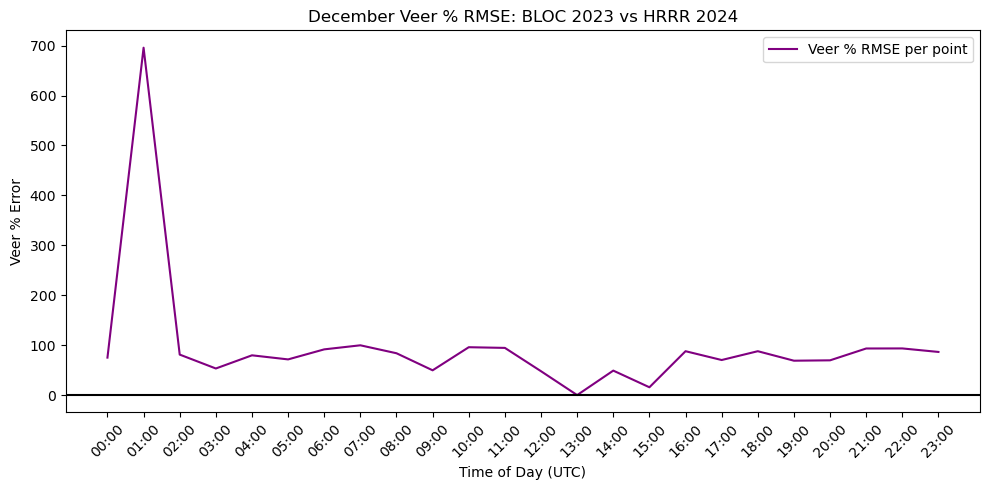

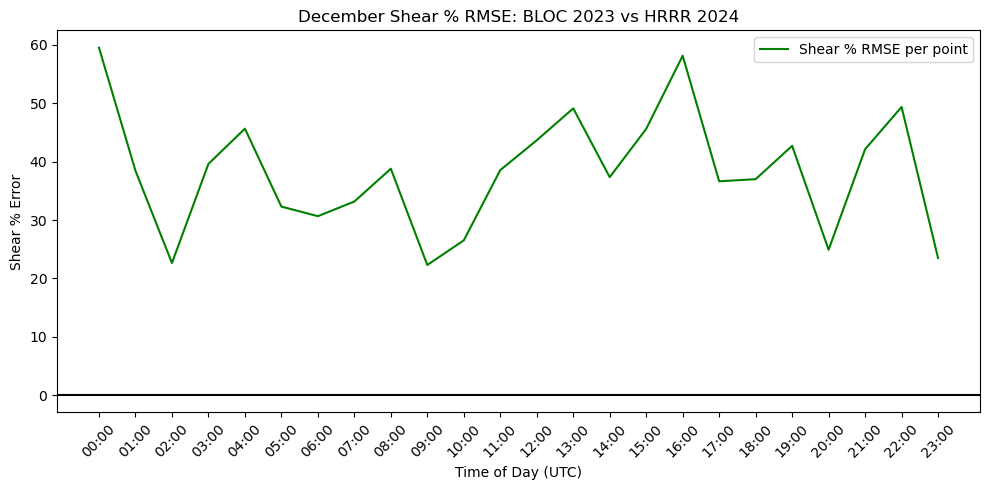

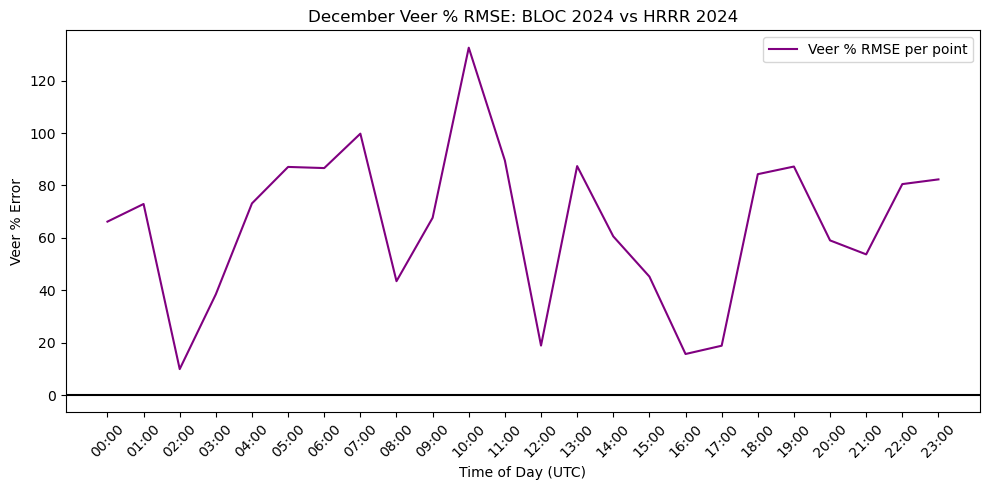

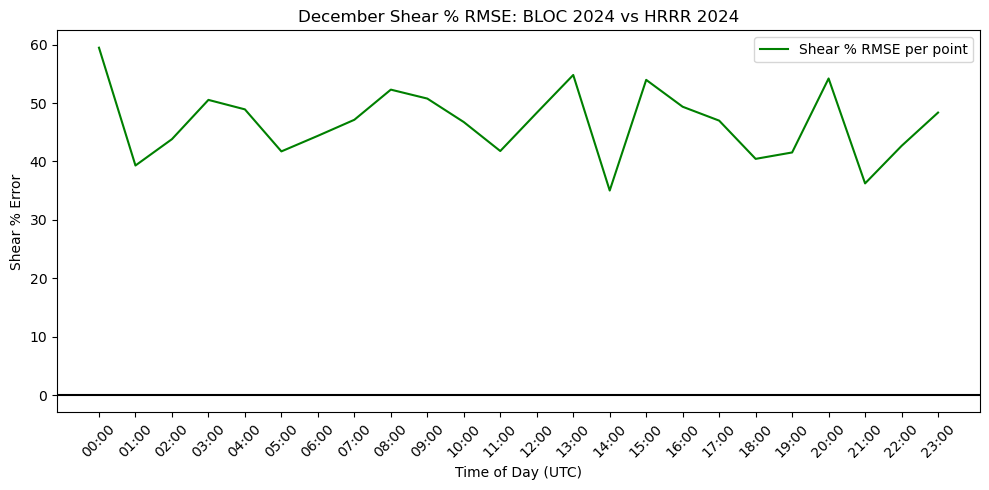

No HRRR files found for December 2025


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Directories
directory_BLOC = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_Data'
directory_HRRR = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/HRRR_Data'

# Define full months (Jan–Dec)
months_list = [
    ('January', '01'),
    ('February', '02'),
    ('March', '03'),
    ('April', '04'),
    ('May', '05'),
    ('June', '06'),
    ('July', '07'),
    ('August', '08'),
    ('September', '09'),
    ('October', '10'),
    ('November', '11'),
    ('December', '12')
]

# The HRRR model years you have loaded:
HRRR_years = [2024, 2025]
BLOC_years = [2023, 2024, 2025]

for month_name, month_str in months_list:
    print(f"\nProcessing {month_name.upper()}")

    for year in HRRR_years:
        hrrr_start = f"{year}{month_str}01"
        hrrr_end = pd.to_datetime(hrrr_start).replace(day=1) + pd.offsets.MonthEnd(0)
        hrrr_end = hrrr_end.strftime('%Y%m%d')

        HRRR_files = filter_BLOC_files_by_date(directory_HRRR, hrrr_start, hrrr_end)

        if not HRRR_files:
            print(f"No HRRR files found for {month_name} {year}")
            continue

        times_HRRR, veer_HRRR = calculate_wind_veer_HRRR(HRRR_files)
        times_HRRR, shear_HRRR = calculate_wind_shear_HRRR(HRRR_files)

        HRRR_avg_veer = getDailyAvgWindVeerHRRR(times_HRRR, veer_HRRR, pd.to_datetime(hrrr_start), pd.to_datetime(hrrr_end))
        HRRR_avg_shear = getDailyAvgWindShearHRRR(times_HRRR, shear_HRRR, pd.to_datetime(hrrr_start), pd.to_datetime(hrrr_end))

        bloc_dfs_veer = []
        bloc_dfs_shear = []
        bloc_labels = []

        for bloc_year in BLOC_years:
            bloc_start = f"{bloc_year}{month_str}01"
            try:
                bloc_end = pd.to_datetime(bloc_start).replace(day=1) + pd.offsets.MonthEnd(0)
            except:
                continue

            bloc_end = bloc_end.strftime('%Y%m%d')
            BLOC_files = filter_files_by_date(directory_BLOC, bloc_start, bloc_end)

            if not BLOC_files:
                continue

            times_BLOC, veer_BLOC = calculate_wind_veer(BLOC_files)
            times_BLOC, shear_BLOC = calculate_wind_shear_with_alpha(BLOC_files)

            bloc_avg_veer = getDailyAvgWindVeer(times_BLOC, veer_BLOC, pd.to_datetime(bloc_start), pd.to_datetime(bloc_end))
            bloc_avg_shear = getDailyAvgWindShear(times_BLOC, shear_BLOC, pd.to_datetime(bloc_start), pd.to_datetime(bloc_end))

            bloc_dfs_veer.append(bloc_avg_veer)
            bloc_dfs_shear.append(bloc_avg_shear)
            bloc_labels.append(f"BLOC {bloc_year}")

        ### Calculate % RMSE for each BLOC year
        for bloc_df_veer, bloc_df_shear, bloc_label in zip(bloc_dfs_veer, bloc_dfs_shear, bloc_labels):
            merged_veer = pd.merge(HRRR_avg_veer, bloc_df_veer, on='time_of_day', suffixes=('_hrrr','_bloc'))
            diff_veer = np.abs(merged_veer['average_wind_veer_bloc'] - merged_veer['average_wind_veer_hrrr'])

            # Calculate % error per point, handle division by zero
            percent_rmse_veer = np.where(
                merged_veer['average_wind_veer_bloc'] != 0,
                (diff_veer / np.abs(merged_veer['average_wind_veer_bloc'])) * 100,
                np.nan
            )

            plt.figure(figsize=(10, 5))
            plt.plot(merged_veer['time_of_day'], percent_rmse_veer, color='purple', label='Veer % RMSE per point')
            plt.title(f"{month_name} Veer % RMSE: {bloc_label} vs HRRR {year}")
            plt.xlabel("Time of Day (UTC)")
            plt.ylabel("Veer % Error")
            plt.axhline(0, color='black')
            plt.xticks(rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()

            ### Same for Shear
            merged_shear = pd.merge(HRRR_avg_shear, bloc_df_shear, on='time_of_day', suffixes=('_hrrr','_bloc'))
            diff_shear = np.abs(merged_shear['average_wind_shear_bloc'] - merged_shear['average_wind_shear_hrrr'])

            percent_rmse_shear = np.where(
                merged_shear['average_wind_shear_bloc'] != 0,
                (diff_shear / np.abs(merged_shear['average_wind_shear_bloc'])) * 100,
                np.nan
            )

            plt.figure(figsize=(10, 5))
            plt.plot(merged_shear['time_of_day'], percent_rmse_shear, color='green', label='Shear % RMSE per point')
            plt.title(f"{month_name} Shear % RMSE: {bloc_label} vs HRRR {year}")
            plt.xlabel("Time of Day (UTC)")
            plt.ylabel("Shear % Error")
            plt.axhline(0, color='black')
            plt.xticks(rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()
